In [1]:
import subprocess 
import torch as ch
from torch import Tensor
import torch.linalg as LA
from torch.distributions import Uniform, Laplace
from torch.distributions.multivariate_normal import MultivariateNormal
import pandas as pd
import numpy as np
import csv
import json
from cox.utils import Parameters
from cox.store import Store

from cox.readers import CollectionReader
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import math 

import sys 
sys.path.append('../..')
from delphi.stats.linear_regression import TruncatedRegression
from delphi import oracle
from delphi.utils import constants as consts
from delphi.utils.helpers import setup_store_with_metadata


OUT_DIR = '/home/gridsan/stefanou/Regression/'
TABLE_NAME = 'logs'

# set environment variable so that stores can create output files
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

In [2]:
args = Parameters({
    "bias": True,
    "samples": 1000,
    "c": 0,
    "batch_size": 5,
    "lr": 1e-1,
    "var_": 1,
    "trials": 3,
    "workers": 8,
    "steps": 1000,
    "x_lower": -10,
    "x_upper": 10,
    "lower": -1,
    "upper": 1,
})
mse_loss = ch.nn.MSELoss()

I will start by generating the ground-truth for our expriment.

gt weight:  Parameter containing:
tensor([[1.]], requires_grad=True)
gt bias:  Parameter containing:
tensor([[1.]], requires_grad=True)
alpha:  tensor([0.4540])
gt ols coef:  [[1.0157692]]
gt ols intercept:  [1.066447]
trunc ols coef:  [[0.5316576]]
trunc ols intercept:  [-0.16779864]


Text(0, 0.5, 'y')

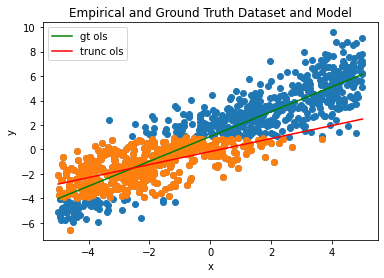

In [3]:
# distribution for generating feature vectors
d, k = 1, 1
# w = Uniform(-1, 1)
# m = MultivariateNormal(ch.zeros(d), ch.eye(d)/d)
m = Uniform(-5, 5)
# phi = oracle.Identity()
intervals = [(-8, -6), (-4, 1)]
phi = oracle.KIntervalUnion(intervals)

# generate ground truth
gt = ch.nn.Linear(in_features=k, out_features=1)
gt.weight = ch.nn.Parameter(ch.ones(k, d))

# gt.bias = ch.nn.Parameter(ch.ones(1, 1)) if args.bias else None
gt.bias = ch.nn.Parameter(ch.ones(1, 1)) if args.bias else None
print("gt weight: ", gt.weight)
print("gt bias: ", gt.bias)

# create base classifier
with ch.no_grad():
    # generate data
    X = m.sample(ch.Size([args.samples, d])) if isinstance(m, Uniform) else m.sample(ch.Size([args.samples]))
    y = gt(X)

noise_var = Tensor([2.0])[...,None]
# remove synthetic data from the computation graph
with ch.no_grad():
    # add noise to ground-truth pedictions
    noised = y + ch.sqrt(noise_var) * ch.randn(X.size(0), 1)
    # truncate based off of the standardized data
    indices = phi(noised).flatten().nonzero(as_tuple=False).flatten()
    y_trunc, x_trunc = noised[indices], X[indices]
    alpha = Tensor([y_trunc.size(0) / args.samples])
    print("alpha: ", alpha)
    
# ground-truth OLS
gt_ols = LinearRegression()
gt_ols.fit(X, noised)
print("gt ols coef: ", gt_ols.coef_)
print("gt ols intercept: ", gt_ols.intercept_)

trunc_ols = LinearRegression()
trunc_ols.fit(x_trunc, y_trunc)
trunc_ols_pred = trunc_ols.predict(x_trunc)
print("trunc ols coef: ", trunc_ols.coef_)
print("trunc ols intercept: ", trunc_ols.intercept_)

# data for plotting regressions
unnorm_data = np.linspace(-5, 5, 100).reshape(100, 1)
norm_data = np.linspace(-1, 1, 100).reshape(100, 1)

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised)
plt.scatter(x_trunc, y_trunc)
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt ols')
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='red', label='trunc ols')
plt.legend()
plt.title("Empirical and Ground Truth Dataset and Model")
ax.set_xlabel("x")
ax.set_ylabel("y")

Now, we want to standardize our truncated dataset, so that our empirical estimates are located on the l2 ball. First we will divide all of our covariate features by $B\sqrt{k}$, so that all of our covariate features $||x_{i}||_{2}^{2} \leq 1$, and reside on the $\ell_{2}$ ball. This way the norm of $w$ will be multiplied by $B\sqrt{k}$.

In [4]:
max_x_trunc_norm = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()
print("max truncated x norm", max_x_trunc_norm)

beta = max_x_trunc_norm*math.sqrt(X.size(1))
print("beta: ", beta)

x_trunc_norm = x_trunc / beta
print("x max l2: ", x_trunc_norm.norm(dim=-1).max())

max truncated x norm tensor(4.9922)
beta:  tensor(4.9922)
x max l2:  tensor(1.)


We now observe that the norm of the truncated x covariates is bounded by 1. So, now we will standardze our dependent variable so that it's ground-truth takes the form of the linear regression latent variable model with noise variance of 1. First, let's calculate the predicted values from our naive ols regression on the truncated data.

First, we will standardize our data for the case where we assume that the empirical noise variance is the underlying noise variance of the ground truth regression.

emp noise var:  tensor([1.1557])
trunc reg noise var:  tensor([1.0000])


Text(0, 0.5, 'y')

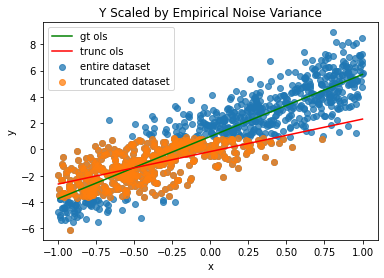

In [5]:
emp_noise_var = (y_trunc - trunc_ols_pred).var(0)
print("emp noise var: ", emp_noise_var)

emp_stand_intervals = [(int_[0]/emp_noise_var, int_[1]/emp_noise_var) for int_ in intervals]
emp_scaled_kinterval = oracle.KIntervalUnion(emp_stand_intervals)

emp_stand_y_trunc = y_trunc / ch.sqrt(emp_noise_var)
trunc_noise_var = (emp_stand_y_trunc - (trunc_ols_pred / ch.sqrt(emp_noise_var))).var(0)
print("trunc reg noise var: ", trunc_noise_var)

new_X, emp_stand_noised = X / beta, noised / ch.sqrt(emp_noise_var)

gt_emp_stand = LinearRegression()
gt_emp_stand.fit(new_X, emp_stand_noised)

trunc_emp_stand_ols = LinearRegression()
trunc_emp_stand_ols.fit(x_trunc_norm, emp_stand_y_trunc)

ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt ols')
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='red', label='trunc ols')
plt.legend()
plt.title('Y Scaled by Empirical Noise Variance')
ax.set_xlabel("x")
ax.set_ylabel("y")

First, we will standardize our data for the case where we assume that wee know the underlying ground-truth noise variance.

trunc reg noise var:  tensor([0.5779])
reg noise var:  tensor([1.0810])


Text(0, 0.5, 'y')

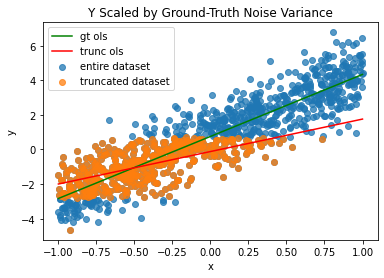

In [6]:
stand_noised, stand_y_trunc = noised / ch.sqrt(noise_var), y_trunc / ch.sqrt(noise_var)
stand_intervals = [(int_[0]/float(ch.sqrt(noise_var)), int_[1]/float(ch.sqrt(noise_var))) for int_ in intervals]
scaled_kinterval = oracle.KIntervalUnion(stand_intervals)

gt_stand = LinearRegression()
gt_stand.fit(new_X, stand_noised)

trunc_stand_ols = LinearRegression()
trunc_stand_ols.fit(x_trunc_norm, stand_y_trunc)

trunc_noise_var = (stand_y_trunc - trunc_stand_ols.predict(x_trunc_norm)).var(0)
print("trunc reg noise var: ", trunc_noise_var)

reg_noise_var = (stand_noised - gt_stand.predict(new_X)).var(0)
print("reg noise var: ", reg_noise_var)

ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, gt_stand.predict(norm_data), color='green', label='gt ols')
plt.plot(norm_data, trunc_stand_ols.predict(norm_data), color='red', label='trunc ols')
plt.legend()
plt.title("Y Scaled by Ground-Truth Noise Variance")
ax.set_xlabel("x")
ax.set_ylabel("y")

Truncated Regression with Known Empirical Variance

In [7]:
known_emp_trunc_reg = TruncatedRegression(phi=emp_scaled_kinterval, alpha=alpha, bias=True, unknown=False, val=100, bs=10, n=100, tol=1e-2)
known_emp_trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)
known_emp_w_unnorm = (known_emp_trunc_reg.weight * ch.sqrt(emp_noise_var)) / beta

known_emp_bias_unnorm = ch.zeros(1, 1)
if args.bias: 
    known_emp_bias_unnorm = (known_emp_trunc_reg.intercept * ch.sqrt(emp_noise_var))

/home/gridsan/stefanou/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:202: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return Variable._execution_engine.run_backward(


Iteration: 0.0 | Score: [0.005334249697625637]
Iteration: 1.0 | Score: [0.023505819961428642]
Iteration: 2.0 | Score: [0.05725365877151489]
Iteration: 3.0 | Score: [0.07684817910194397]
Iteration: 4.0 | Score: [-0.06513912975788116]
Iteration: 5.0 | Score: [0.008842214941978455]


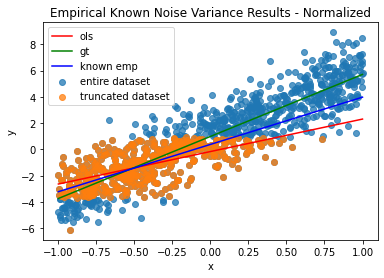

Text(0, 0.5, 'y')

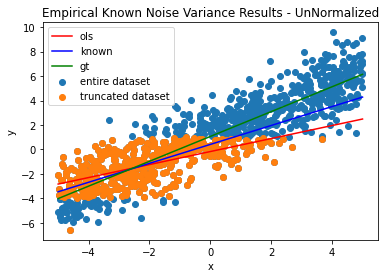

In [8]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, known_emp_trunc_reg(Tensor(norm_data)).detach().numpy(), label='known emp', color='blue')
plt.legend()
plt.title("Empirical Known Noise Variance Results - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='red', label='ols')
plt.plot(unnorm_data, (Tensor(unnorm_data)@known_emp_w_unnorm + known_emp_bias_unnorm).detach().numpy(), label='known', color='blue')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt')
plt.scatter(X, noised, label='entire dataset')
plt.scatter(x_trunc, y_trunc, label='truncated dataset')
plt.legend()
plt.title("Empirical Known Noise Variance Results - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")

Truncated Regression with Known Variance

In [62]:
known_trunc_reg = TruncatedRegression(phi=scaled_kinterval, alpha=alpha, bias=args.bias, unknown=False, val=100, bs=10, n=100, tol=1e-2, steps=2500)
known_trunc_reg.fit(x_trunc_norm, stand_y_trunc)
known_weight_unnorm = (known_trunc_reg.weight * ch.sqrt(noise_var)) / beta

known_bias_unnorm = ch.zeros(1, 1)
if args.bias:  
    known_bias_unnorm = known_trunc_reg.intercept * ch.sqrt(noise_var)

Iteration: 0.0 | Score: [-0.05916885286569595]
Iteration: 1.0 | Score: [0.04893818125128746]
Iteration: 2.0 | Score: [0.04145364463329315]
Iteration: 3.0 | Score: [0.05550083518028259]
Iteration: 4.0 | Score: [0.07267409563064575]
Iteration: 5.0 | Score: [0.06594416499137878]
Iteration: 6.0 | Score: [0.08675671368837357]
Iteration: 7.0 | Score: [0.07263945788145065]
Iteration: 8.0 | Score: [0.057985685765743256]
Iteration: 9.0 | Score: [0.06590069085359573]
Iteration: 10.0 | Score: [0.07685801386833191]
Iteration: 11.0 | Score: [0.07213655859231949]
Iteration: 12.0 | Score: [0.07778497040271759]
Iteration: 13.0 | Score: [0.0670495480298996]
Iteration: 14.0 | Score: [0.06817517429590225]
Iteration: 15.0 | Score: [0.06831635534763336]
Iteration: 16.0 | Score: [0.050778184086084366]
Iteration: 17.0 | Score: [0.07881157845258713]
Iteration: 18.0 | Score: [0.08631207048892975]
Iteration: 19.0 | Score: [0.0783863216638565]
Iteration: 20.0 | Score: [0.06319235265254974]
Iteration: 21.0 | Scor

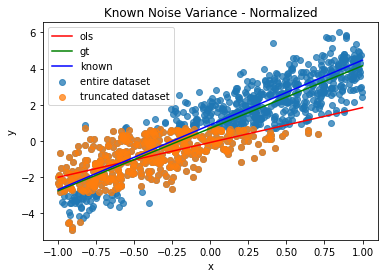

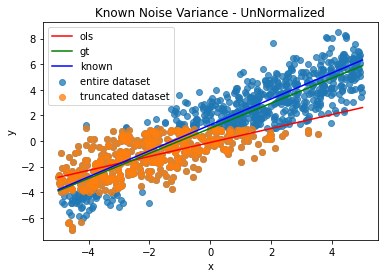

In [63]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, known_trunc_reg(Tensor(norm_data)).detach().numpy(), label='known', color='blue')
plt.legend()
plt.title("Known Noise Variance - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='r', label='ols')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt')
plt.plot(unnorm_data, (Tensor(unnorm_data)@known_weight_unnorm + known_bias_unnorm).detach().numpy(), label='known', color='blue')
plt.legend()
plt.title("Known Noise Variance - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

Truncated Regression with Unknown Noise Variance

In [64]:
unknown_trunc_reg = TruncatedRegression(phi=emp_scaled_kinterval, alpha=alpha, bias=True, unknown=True, bs=10, n=100, tol=1e-1, val=50, steps=3000)
unknown_trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)
with ch.no_grad():
    unknown_weight_unnorm = (((unknown_trunc_reg.weight * unknown_trunc_reg.variance) * ch.sqrt(emp_noise_var)) / beta)
    if args.bias: 
        unknown_bias_unnorm = ((unknown_trunc_reg.bias * unknown_trunc_reg.variance) * ch.sqrt(emp_noise_var))

Iteration: 0.0 | Score: [-0.047379814088344574, 0.1375025361776352]
Iteration: 1.0 | Score: [-0.02089824341237545, -0.180572971701622]
Iteration: 2.0 | Score: [0.10863552987575531, 0.06415006518363953]
Iteration: 3.0 | Score: [0.06737342476844788, 0.02363922819495201]


In [39]:
unknown_trunc_reg.weight, gt_emp_stand.coef_

(tensor([[3.0235]], grad_fn=<PermuteBackward>),
 array([[4.193836]], dtype=float32))

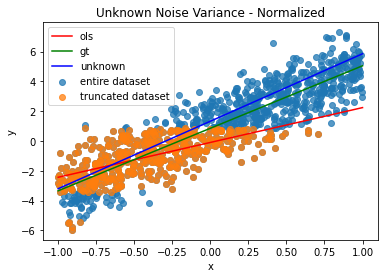

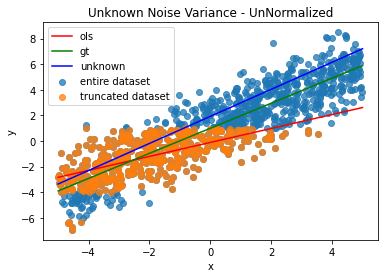

In [65]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, unknown_trunc_reg(Tensor(norm_data)).detach().numpy(), label='unknown', color='blue')
plt.legend()
ax.set_title("Unknown Noise Variance - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), label='ols', color='red')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='g', label='gt')
plt.plot(unnorm_data, (Tensor(unnorm_data)@unknown_weight_unnorm + unknown_bias_unnorm), color='blue', label='unknown')
plt.legend()
ax.set_title("Unknown Noise Variance - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

# Truncate at Zero and Run for High Variance

In [187]:
args.__setattr__('bs', 10)
args.__setattr__('steps', 2500)
args.__setattr__('step_lr', 100)
args.__setattr__('step_lr_gamma', .9)
args.__setattr__('tol', 1e-2)
args.__setattr__('trials', 20)
args.__setattr__('n', 100)


EXP = '50DimsArbitrary_'

In [188]:
def run_trial(kwargs, X, y):
    """
    Runs a trial of a truncated regression experiment. Runs a maximum 
    of three trials of an experiment. The experiment terminates when either 
    the norm of teh score is less than 3e-1, or when three trials is up. After 
    three trials it returns the best truncated regression experiment.
    :param kwargs: keyword arguments for experiment 
    :param X: independent variable
    :param y: dependent variable
    :return: truncated regression experiment and time that experiment took
    """
    st = datetime.datetime.now()        
    # run procedure until get reasonable score
    attempt, score, best_trunc_reg = 0, None, None
    while (score is None or score.norm() > 3e-1) and attempt < 3:
        trunc_reg = TruncatedRegression(**kwargs)
        trunc_reg.fit(X, y)
        grad = trunc_reg.score()
        if score is None or grad.norm() < score.norm(): 
            score, best_trunc_reg = grad, trunc_reg
        attempt += 1
    total_time = int((datetime.datetime.now() - st).total_seconds())
    return best_trunc_reg, total_time  

In [189]:
 # expriment parameters
w_lower, w_upper = -1, 1
d, k = 50, 1

# distribution for generating feature vectors
dist = MultivariateNormal(ch.zeros(d), ch.eye(d)/d)
dist = Uniform(-10, 10)
samples = [100, 125, 150, 175, 200, 225, 250, 275, 300, 400, 500, 750, 1000, 1500, 2000, 2500]
intervals = [(-20, -5), (-3, 0), (8, 10)]
phi = oracle.KIntervalUnion(intervals)
noise_var = Tensor([10.0])

stand_intervals = [(int_[0]/float(ch.sqrt(noise_var)), int_[1]/float(ch.sqrt(noise_var))) for int_ in intervals]
scaled_kinterval = oracle.KIntervalUnion(stand_intervals)

# generate ground truth
gt = ch.nn.Linear(in_features=d, out_features=k)
gt.weight = ch.nn.Parameter(ch.ones(k, d))
gt.bias = ch.nn.Parameter(ch.ones(1, 1)) if args.bias else None

for i in range(args.trials):
    # create store and add table
    store = Store(OUT_DIR + EXP)
    store.add_table(TABLE_NAME, { 
        'ols_r2': float,
        'ols_param_mse': float,
        'ols_var_l1': float,
#         'known_r2': float,
#         'known_param_mse': float,
#         'known_time': int,
        'unknown_r2': float, 
        'unknown_param_mse': float,
        'unknown_var_l1': float,
        'unknown_time': int,
        'alpha': float, 
        'num_samples': int,
        'noise_var': float, 
    })
    
    
    for s in samples: 
        X, noised = Tensor([]), Tensor([])
        x_trunc, y_trunc = Tensor([]), Tensor([])
        
        # generate data until s number of samples fall within the truncation set
        with ch.no_grad():
            while x_trunc.size(0) < s: 
                x_ = dist.sample(ch.Size([s, d])) if isinstance(dist, Uniform) else dist.sample(ch.Size([s]))
                new_noised = gt(x_) + ch.sqrt(noise_var) * ch.randn(s, 1)
                # add noise to ground-truth pedictions
                # truncate based off of the standardized data
                indices = phi(new_noised).flatten().nonzero(as_tuple=False).flatten()
                y_trunc, x_trunc = ch.cat([y_trunc, new_noised[indices]]), ch.cat([x_trunc, x_[indices]])
                X, noised = ch.cat([X, x_]), ch.cat([noised, new_noised])
        x_trunc, y_trunc = x_trunc[:s], y_trunc[:s]
        alpha = Tensor([y_trunc.size(0) / noised.size(0)])
        print("alpha: ", alpha)
        val = int(.1*s)
        
        # normalize x features so that ||x_{i}||_{2}^{2} <= 1
        l_inf = LA.norm(x_trunc, dim=-1, ord=float('inf')).max() # find max l_inf
        # calculate normalizing constant
        beta = l_inf*math.sqrt(d)
        """
        Divide input features by normalizing constant. By doing so, 
        the weights will be increased by a magnitude of beta.
        """
        x_trunc_norm = x_trunc / beta
         # normalize entire dataset by beta
        x_norm = X / beta
        
        # ground-truth ols
        gt_ols = LinearRegression()
        gt_ols.fit(X, noised)
        gt_params = ch.cat([Tensor(gt_ols.coef_).T, Tensor(gt_ols.intercept_)[..., None]]).flatten()
        
        # empirical linear regression
        ols = LinearRegression() 
        ols.fit(x_trunc, y_trunc)
        ols_var = ch.var(Tensor(ols.predict(x_trunc)) - y_trunc, dim=0)[..., None]
        ols_params = ch.cat([Tensor(ols.coef_).T, Tensor(ols.intercept_)[..., None]]).flatten()
        # check r2 for entire dataset
        ols_pred = ols.predict(X)

        # ols results
        store[TABLE_NAME].update_row({
            'ols_r2': r2_score(noised.flatten(), ols_pred.flatten()), 
            'ols_var_l1': ch.abs(ols_var - noise_var),
            'ols_param_mse': mse_loss(ols_params, gt_params),
        })
        
        """
        Run dataset on truncated regression with known variance, while 
        assuming that the empirical noise variance is the underlying noise 
        variance of our linear regression. This means that we want to standardize 
        our dependent variable by the empirical noise variance. 
        """
        # variance of the residuals
        emp_noise_var = (y_trunc - ols.predict(x_trunc)).var(0)
        emp_stand_intervals = [(int_[0]/math.sqrt(float(emp_noise_var)), int_[1]/math.sqrt(float(emp_noise_var))) for int_ in intervals]
        emp_scaled_kinterval = oracle.KIntervalUnion(emp_stand_intervals)
        # standardize y trunc by the empirical noise variance
        emp_stand_y_trunc = y_trunc / ch.sqrt(emp_noise_var)        
        
        """
        Run dataset on truncated regression with known variance. This means that we want to standardize 
        our dependent variable by the true noise variance. 
        """
        # standardize y trunc by actual noise variance
        stand_y_trunc = y_trunc / ch.sqrt(noise_var)
        # standardize noised by actual noise variance
#         known_kwargs = { 
#             'phi': scaled_kinterval, 
#             'alpha': alpha, 
#             'bias': args.bias, 
#             'unknown': False, 
#             'bs': args.bs, 
#             'n': args.n, 
#             'tol': args.tol, 
#             'steps': args.steps, 
#             'val': val
#         }
#         known_trunc_reg, total_time = run_trial(known_kwargs, x_trunc_norm, stand_y_trunc)

#         with ch.no_grad():
#             w, w0 = (known_trunc_reg.weight * ch.sqrt(noise_var)) / beta, known_trunc_reg.intercept[..., None] * ch.sqrt(noise_var)
#             known_params = ch.cat([w, w0]).flatten()
#             # known results
#             store[TABLE_NAME].update_row({
#                 'known_r2': r2_score(noised.flatten(), X@w + w0), 
#                 'known_param_mse': mse_loss(known_params, gt_params),
#                 'known_time': total_time, 
#             })
        
        # truncated regression with unknown variance
            
        unknown_kwargs = { 
            'phi': emp_scaled_kinterval, 
            'alpha': alpha, 
            'bias': args.bias, 
            'unknown': True, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps, 
            'val': val
        }
        unknown_trunc_reg, total_time = run_trial(unknown_kwargs, x_trunc_norm, emp_stand_y_trunc)
    
        with ch.no_grad():
            unknown_var = unknown_trunc_reg.variance * emp_noise_var
            w, w0 = (((unknown_trunc_reg.weight * unknown_trunc_reg.variance) * ch.sqrt(emp_noise_var)) / beta).detach(), ((unknown_trunc_reg.intercept * unknown_trunc_reg.variance * ch.sqrt(emp_noise_var)))
            unknown_params = ch.cat([w, w0]).flatten()
            
            # known emp results
            store[TABLE_NAME].update_row({
                'unknown_r2': r2_score(noised.flatten(), X@w + w0), 
                'unknown_param_mse': mse_loss(unknown_params, gt_params),
                'unknown_var_l1': float(ch.abs(unknown_var - noise_var)),
                'unknown_time': total_time, 
            })
        
        
        # add additional exp data to store
        store[TABLE_NAME].update_row({ 
            'alpha': float(alpha.flatten()),
            'num_samples': x_trunc.size(0),
            'noise_var': noise_var, 
        })

        # append row to table
        store[TABLE_NAME].flush_row()
    store.close()    

Logging in: /home/gridsan/stefanou/Regression/50DimsArbitrary_/c4d6f9d3-322e-4a88-a86e-036715c57b23
alpha:  tensor([0.1429])
Iteration: 0.0 | Score: [0.014092741534113884, -1.9892480373382568]
Iteration: 1.0 | Score: [-2.8914427757263184, -19.993398666381836]
Iteration: 2.0 | Score: [11.312782287597656, 15.2972993850708]
Iteration: 3.0 | Score: [-2.6309244632720947, -17.815959930419922]
Iteration: 4.0 | Score: [6.66946268081665, 26.09950065612793]
Iteration: 5.0 | Score: [6.669463157653809, 26.09950065612793]
Iteration: 6.0 | Score: [-2.2547523975372314, -14.455583572387695]
Iteration: 7.0 | Score: [-0.08250244706869125, 2.3728256225585938]
Iteration: 8.0 | Score: [6.66946268081665, 26.09950065612793]
Iteration: 9.0 | Score: [6.669462203979492, 26.09950065612793]
Iteration: 10.0 | Score: [0.05138441547751427, 3.649012804031372]
Iteration: 11.0 | Score: [3.054619073867798, 18.809175491333008]
Iteration: 12.0 | Score: [-2.0055177211761475, -12.695539474487305]
Iteration: 13.0 | Score: [6

Iteration: 18.0 | Score: [-0.05850422382354736, -0.31874608993530273]
Iteration: 19.0 | Score: [-0.089108407497406, -0.3899434208869934]
Iteration: 20.0 | Score: [-0.2677496075630188, -1.5416796207427979]
Iteration: 21.0 | Score: [-0.17273534834384918, -0.9033956527709961]
Iteration: 22.0 | Score: [-0.20614226162433624, -1.4209060668945312]
Iteration: 23.0 | Score: [-0.207883819937706, -1.4080042839050293]
Iteration: 24.0 | Score: [-0.06803873181343079, -0.3688134253025055]
Iteration: 25.0 | Score: [-0.24498513340950012, -1.4500913619995117]
Iteration: 0.0 | Score: [-0.17266665399074554, 0.8988101482391357]
Iteration: 1.0 | Score: [0.5370427966117859, 2.8106045722961426]
Iteration: 2.0 | Score: [0.39428430795669556, 7.412606716156006]
Iteration: 3.0 | Score: [-0.3581477701663971, 4.079132556915283]
Iteration: 4.0 | Score: [3.9607067108154297, 14.488931655883789]
Iteration: 5.0 | Score: [0.04314751178026199, 5.6495161056518555]
Iteration: 6.0 | Score: [3.9607067108154297, 14.48893165588

Iteration: 12.0 | Score: [0.09390505403280258, 0.5915660262107849]
Iteration: 13.0 | Score: [0.11962831765413284, 0.7059614062309265]
Iteration: 14.0 | Score: [-0.2914646565914154, -1.3817020654678345]
Iteration: 15.0 | Score: [-0.08468298614025116, -0.39448827505111694]
Iteration: 16.0 | Score: [0.12013830244541168, 0.5220432281494141]
Iteration: 17.0 | Score: [0.044082313776016235, 0.3250162899494171]
Iteration: 18.0 | Score: [-0.1614927053451538, -0.7143518328666687]
Iteration: 19.0 | Score: [-0.06517442315816879, -0.2015070915222168]
Iteration: 20.0 | Score: [0.07768426835536957, 0.18055051565170288]
Iteration: 21.0 | Score: [0.05309978500008583, 0.24779245257377625]
Iteration: 22.0 | Score: [-0.12210844457149506, -0.7582923173904419]
Iteration: 23.0 | Score: [-0.295136034488678, 0.126034677028656]
Iteration: 24.0 | Score: [0.024686945602297783, 0.16791963577270508]
Iteration: 25.0 | Score: [0.026327911764383316, 0.24500392377376556]
alpha:  tensor([0.1667])
Iteration: 0.0 | Score:

Iteration: 5.0 | Score: [-0.5037519335746765, -2.3960373401641846]
Iteration: 6.0 | Score: [0.11393732577562332, 0.3959624767303467]
Iteration: 7.0 | Score: [0.08447986096143723, 0.14521627128124237]
Iteration: 8.0 | Score: [-0.3338986039161682, -1.5531280040740967]
Iteration: 9.0 | Score: [-0.3750702440738678, -1.9956004619598389]
Iteration: 10.0 | Score: [0.2939663529396057, 1.0815167427062988]
Iteration: 11.0 | Score: [-0.17439687252044678, -0.9164382815361023]
Iteration: 12.0 | Score: [-0.15090718865394592, -0.8659862279891968]
Iteration: 13.0 | Score: [-0.07201030850410461, -0.5918992757797241]
Iteration: 14.0 | Score: [-0.0069704484194517136, -0.29399263858795166]
Iteration: 15.0 | Score: [-0.10395130515098572, -0.7030411958694458]
Iteration: 16.0 | Score: [-0.07356680184602737, -0.5691628456115723]
Iteration: 17.0 | Score: [-0.13523051142692566, -0.9244151711463928]
Iteration: 18.0 | Score: [0.026113925501704216, -0.09333349764347076]
Iteration: 19.0 | Score: [-0.041285853832960

Iteration: 23.0 | Score: [-0.1137666180729866, -0.5779454708099365]
Iteration: 24.0 | Score: [-0.015494180843234062, -0.006459027528762817]
Iteration: 25.0 | Score: [-0.07986470311880112, -0.4150664210319519]
alpha:  tensor([0.1667])
Iteration: 0.0 | Score: [-0.08001141250133514, 0.6190266609191895]
Iteration: 1.0 | Score: [-0.0701199322938919, 0.23264220356941223]
Iteration: 2.0 | Score: [-0.0907668024301529, 0.2181660532951355]
Iteration: 3.0 | Score: [-0.11796285957098007, -0.1752413660287857]
Iteration: 4.0 | Score: [-0.03506628796458244, 0.4284302294254303]
Iteration: 5.0 | Score: [-0.03674938902258873, 0.3602861762046814]
Iteration: 6.0 | Score: [-0.009131872095167637, 0.5784809589385986]
Iteration: 7.0 | Score: [-0.0510171614587307, 0.5227256417274475]
Iteration: 8.0 | Score: [-0.0023276880383491516, 0.6140221357345581]
Iteration: 9.0 | Score: [-0.0339343398809433, 0.47062447667121887]
Iteration: 10.0 | Score: [-0.00462565291672945, 0.6116458177566528]
Iteration: 11.0 | Score: [

Iteration: 14.0 | Score: [0.059198763221502304, 0.9791316986083984]
Iteration: 15.0 | Score: [-0.015845471993088722, 0.7539716958999634]
Iteration: 16.0 | Score: [0.013951333239674568, 0.7336339950561523]
Iteration: 17.0 | Score: [0.005301202647387981, 0.7350033521652222]
Iteration: 18.0 | Score: [-0.12091841548681259, 0.18285463750362396]
Iteration: 19.0 | Score: [-0.08149167895317078, 0.14892515540122986]
Iteration: 20.0 | Score: [0.048163533210754395, 1.048553228378296]
Iteration: 21.0 | Score: [-0.09566889703273773, 0.1310553252696991]
Iteration: 22.0 | Score: [-0.026477031409740448, 0.534884512424469]
Iteration: 23.0 | Score: [-0.01608658768236637, 0.5313726663589478]
Iteration: 24.0 | Score: [-0.0006425126921385527, 0.6723610758781433]
Iteration: 25.0 | Score: [-0.006357787176966667, 0.7315741181373596]
Iteration: 0.0 | Score: [-0.3003675043582916, -0.3840440511703491]
Iteration: 1.0 | Score: [-0.8563547730445862, -3.8009538650512695]
Iteration: 2.0 | Score: [-0.35370883345603943

Iteration: 3.0 | Score: [0.0559086836874485, 0.33028560876846313]
Iteration: 4.0 | Score: [0.07383247464895248, 0.3573768734931946]
Iteration: 5.0 | Score: [-0.21611973643302917, -0.8660638928413391]
Iteration: 6.0 | Score: [-0.3297519385814667, -1.3035898208618164]
Iteration: 7.0 | Score: [-0.20999132096767426, -0.8094977736473083]
Iteration: 8.0 | Score: [-0.13203011453151703, -0.4084235429763794]
Iteration: 9.0 | Score: [-0.04261033982038498, -0.027830734848976135]
Iteration: 10.0 | Score: [-0.18206295371055603, -0.6706229448318481]
Iteration: 11.0 | Score: [-0.2565315067768097, -0.9600934982299805]
Iteration: 12.0 | Score: [-0.16382072865962982, -0.5680046081542969]
Iteration: 13.0 | Score: [0.0035105564165860415, 0.16139215230941772]
Iteration: 14.0 | Score: [-0.1976914256811142, -0.6840134263038635]
Iteration: 15.0 | Score: [-0.28414225578308105, -0.9984241724014282]
Iteration: 16.0 | Score: [-0.12265487015247345, -0.3726631999015808]
Iteration: 17.0 | Score: [-0.1042855381965637

Iteration: 21.0 | Score: [-1.1930625438690186, -1.0811710357666016]
Iteration: 22.0 | Score: [-0.601243257522583, 1.228962779045105]
Iteration: 23.0 | Score: [-0.9215390682220459, -0.23617279529571533]
Iteration: 24.0 | Score: [-0.7644548416137695, 0.2457418143749237]
Iteration: 25.0 | Score: [-1.2257542610168457, -1.8932292461395264]
Iteration: 0.0 | Score: [0.13647152483463287, 1.1819006204605103]
Iteration: 1.0 | Score: [-0.09584346413612366, -0.6834906935691833]
Iteration: 2.0 | Score: [-0.5348587036132812, 1.344881296157837]
Iteration: 3.0 | Score: [-1.3402338027954102, -1.9767168760299683]
Iteration: 4.0 | Score: [3.1531267166137695, 8.874463081359863]
Iteration: 5.0 | Score: [3.1531267166137695, 8.874463081359863]
Iteration: 6.0 | Score: [3.1531271934509277, 8.874463081359863]
Iteration: 7.0 | Score: [3.1531269550323486, 8.874463081359863]
Iteration: 8.0 | Score: [-0.35771751403808594, 2.1623504161834717]
Iteration: 9.0 | Score: [-1.5942933559417725, -3.646357536315918]
Iteratio

Iteration: 12.0 | Score: [-0.7170331478118896, 0.48138973116874695]
Iteration: 13.0 | Score: [-0.10730648785829544, 1.9892557859420776]
Iteration: 14.0 | Score: [-0.6696997284889221, 0.10626152157783508]
Iteration: 15.0 | Score: [-0.8182862997055054, -0.40898042917251587]
Iteration: 16.0 | Score: [-0.7157586812973022, -0.16277459263801575]
Iteration: 17.0 | Score: [2.812809467315674, 7.552990913391113]
Iteration: 18.0 | Score: [2.812809705734253, 7.552990913391113]
Iteration: 19.0 | Score: [-1.5481234788894653, -2.602998733520508]
Iteration: 20.0 | Score: [-0.9313271641731262, -0.1505918949842453]
Iteration: 21.0 | Score: [-0.8302726745605469, 0.06873509287834167]
Iteration: 22.0 | Score: [-0.7012791633605957, 0.34582823514938354]
Iteration: 23.0 | Score: [-0.8045004606246948, -0.2780802845954895]
Iteration: 24.0 | Score: [-0.8254858255386353, -0.6484574675559998]
Iteration: 25.0 | Score: [-0.6849040389060974, -0.3318742513656616]
Iteration: 26.0 | Score: [-0.6050251722335815, -0.21026

Iteration: 1.0 | Score: [0.612687885761261, 2.2581844329833984]
Iteration: 2.0 | Score: [0.8512384295463562, 1.4973762035369873]
Iteration: 3.0 | Score: [0.5401136875152588, 3.0960822105407715]
Iteration: 4.0 | Score: [0.44552239775657654, 1.635322093963623]
Iteration: 5.0 | Score: [0.2422623336315155, 0.153300479054451]
Iteration: 6.0 | Score: [0.3586694598197937, 1.1641238927841187]
Iteration: 7.0 | Score: [0.37635791301727295, 0.8574002385139465]
Iteration: 8.0 | Score: [0.052549008280038834, -0.12807849049568176]
Iteration: 9.0 | Score: [0.19899418950080872, 0.5681535005569458]
Iteration: 10.0 | Score: [0.24600079655647278, 0.6781654953956604]
Iteration: 11.0 | Score: [0.22892463207244873, 0.19219368696212769]
Iteration: 12.0 | Score: [0.2551085352897644, 0.04427054524421692]
Iteration: 13.0 | Score: [0.18014471232891083, 0.7486514449119568]
Iteration: 14.0 | Score: [0.193475142121315, 0.07708518207073212]
Iteration: 15.0 | Score: [0.27103477716445923, -0.04894697666168213]
Iterati

Iteration: 21.0 | Score: [-1.2267059087753296, -2.2822842597961426]
Iteration: 22.0 | Score: [-0.8689801096916199, -0.31644704937934875]
Iteration: 23.0 | Score: [-1.73346745967865, -5.240854740142822]
Iteration: 24.0 | Score: [-1.0482593774795532, -1.530427098274231]
Iteration: 25.0 | Score: [-0.6293414235115051, 0.4681497812271118]
Iteration: 0.0 | Score: [0.4233352243900299, 2.1901237964630127]
Iteration: 1.0 | Score: [4.352132797241211, 14.591261863708496]
Iteration: 2.0 | Score: [-0.46667343378067017, 2.6004106998443604]
Iteration: 3.0 | Score: [-1.992332100868225, -6.0137248039245605]
Iteration: 4.0 | Score: [-1.0924104452133179, -0.8966844081878662]
Iteration: 5.0 | Score: [-1.307538628578186, -2.482074499130249]
Iteration: 6.0 | Score: [0.3416348397731781, 4.668129920959473]
Iteration: 7.0 | Score: [0.8623621463775635, 5.428750038146973]
Iteration: 8.0 | Score: [0.4070298373699188, 2.4326415061950684]
Iteration: 9.0 | Score: [-0.252780556678772, -1.8635917901992798]
Iteration: 

Iteration: 13.0 | Score: [-1.4608755111694336, -2.155001163482666]
Iteration: 14.0 | Score: [-2.8718199729919434, -10.585247039794922]
Iteration: 15.0 | Score: [-1.7939109802246094, -3.7721261978149414]
Iteration: 16.0 | Score: [2.8584814071655273, 8.536300659179688]
Iteration: 17.0 | Score: [-1.6777106523513794, -2.60653018951416]
Iteration: 18.0 | Score: [-1.6878739595413208, -2.918015956878662]
Iteration: 19.0 | Score: [-1.650500774383545, -3.135413885116577]
Iteration: 20.0 | Score: [-1.7986928224563599, -4.024268627166748]
Iteration: 21.0 | Score: [-1.4724537134170532, -2.6672184467315674]
Iteration: 22.0 | Score: [-1.6982393264770508, -3.6121985912323]
Iteration: 23.0 | Score: [-1.7930821180343628, -4.729454517364502]
Iteration: 24.0 | Score: [-1.682945728302002, -3.5665767192840576]
Iteration: 25.0 | Score: [-1.986963152885437, -5.518980503082275]
Iteration: 0.0 | Score: [-0.056932881474494934, -0.9548511505126953]
Iteration: 1.0 | Score: [-0.12973859906196594, -0.91332507133483

Iteration: 5.0 | Score: [-0.305855929851532, -1.622413992881775]
Iteration: 6.0 | Score: [0.12720586359500885, 0.23766547441482544]
Iteration: 7.0 | Score: [-0.1452816277742386, -0.8415215015411377]
Iteration: 8.0 | Score: [0.03205754980444908, -0.11880896240472794]
Iteration: 9.0 | Score: [-0.6274958252906799, -3.0144078731536865]
Iteration: 10.0 | Score: [0.23651549220085144, 0.7552663683891296]
Iteration: 11.0 | Score: [0.07429912686347961, -0.02997685968875885]
Iteration: 12.0 | Score: [0.1677430421113968, 0.4663618803024292]
Iteration: 13.0 | Score: [-0.40141573548316956, -2.093733549118042]
Iteration: 14.0 | Score: [0.1592704802751541, 0.33111968636512756]
Iteration: 15.0 | Score: [0.06879142671823502, 0.029473870992660522]
Iteration: 16.0 | Score: [0.0731196328997612, 0.0973077118396759]
Iteration: 17.0 | Score: [-0.2607644498348236, -1.449108600616455]
Iteration: 18.0 | Score: [0.13030636310577393, 0.2650448977947235]
Iteration: 19.0 | Score: [0.12866534292697906, 0.17988145351

Iteration: 23.0 | Score: [-0.46988964080810547, -2.102566957473755]
Iteration: 24.0 | Score: [-0.46940621733665466, -1.9854283332824707]
Iteration: 25.0 | Score: [-0.45965948700904846, -2.2636830806732178]
Iteration: 0.0 | Score: [0.07813942432403564, 0.958316445350647]
Iteration: 1.0 | Score: [0.7530336380004883, 3.5254809856414795]
Iteration: 2.0 | Score: [2.507967472076416, 8.597024917602539]
Iteration: 3.0 | Score: [0.22094912827014923, 1.9171241521835327]
Iteration: 4.0 | Score: [0.4441837966442108, 2.0155763626098633]
Iteration: 5.0 | Score: [0.4373801648616791, 1.8793385028839111]
Iteration: 6.0 | Score: [0.4410042464733124, 1.921204924583435]
Iteration: 7.0 | Score: [0.384050190448761, 1.6798630952835083]
Iteration: 8.0 | Score: [0.3920832574367523, 1.6102310419082642]
Iteration: 9.0 | Score: [0.3578052222728729, 1.3816285133361816]
Iteration: 10.0 | Score: [0.27297455072402954, 1.1934261322021484]
Iteration: 11.0 | Score: [0.321687787771225, 1.18209707736969]
Iteration: 12.0 |

Iteration: 17.0 | Score: [-0.02626504749059677, 0.2352461963891983]
Iteration: 18.0 | Score: [-0.020473025739192963, 0.3004794120788574]
Iteration: 19.0 | Score: [-0.06836293637752533, 0.22636567056179047]
Iteration: 20.0 | Score: [-0.07705889642238617, 0.25167033076286316]
Iteration: 21.0 | Score: [-0.03222961723804474, 0.5606125593185425]
Iteration: 22.0 | Score: [-0.041678451001644135, 0.2868008017539978]
Iteration: 23.0 | Score: [-0.08516203612089157, 0.07897716015577316]
Iteration: 24.0 | Score: [-0.05562041699886322, 0.34231168031692505]
Iteration: 25.0 | Score: [-0.11370567977428436, 0.04529382288455963]
alpha:  tensor([0.1667])
Iteration: 0.0 | Score: [-0.16000127792358398, -0.09114667028188705]
Iteration: 1.0 | Score: [0.1771603226661682, 0.6488980650901794]
Iteration: 2.0 | Score: [0.3169991075992584, 1.301632046699524]
Iteration: 3.0 | Score: [-0.2995479702949524, -1.7234784364700317]
Iteration: 4.0 | Score: [-0.14203959703445435, -1.1465246677398682]
Iteration: 5.0 | Score:

Iteration: 13.0 | Score: [-0.3313225507736206, -0.2163565456867218]
Iteration: 14.0 | Score: [3.625302314758301, 9.350231170654297]
Iteration: 15.0 | Score: [0.1569635421037674, 2.6388468742370605]
Iteration: 16.0 | Score: [0.48932939767837524, 3.413470506668091]
Iteration: 17.0 | Score: [0.20114541053771973, 1.94512140750885]
Iteration: 18.0 | Score: [0.3403744697570801, 2.265394449234009]
Iteration: 19.0 | Score: [0.32203614711761475, 2.3144707679748535]
Iteration: 20.0 | Score: [0.4621095061302185, 2.7529377937316895]
Iteration: 21.0 | Score: [0.12784220278263092, 1.4113469123840332]
Iteration: 22.0 | Score: [0.17985159158706665, 1.7123275995254517]
Iteration: 23.0 | Score: [-0.31066858768463135, -0.7782013416290283]
Iteration: 24.0 | Score: [3.62530255317688, 9.350231170654297]
Iteration: 25.0 | Score: [3.62530255317688, 9.350231170654297]
Iteration: 0.0 | Score: [-0.016091881319880486, 0.489179402589798]
Iteration: 1.0 | Score: [0.26323428750038147, 1.3612792491912842]
Iteration: 

Iteration: 5.0 | Score: [-0.299260675907135, -1.2455896139144897]
Iteration: 6.0 | Score: [-0.07950185984373093, -0.33452266454696655]
Iteration: 7.0 | Score: [0.00507487915456295, 0.04999187961220741]
Iteration: 8.0 | Score: [-0.1563865840435028, -0.634865939617157]
Iteration: 9.0 | Score: [-0.37586963176727295, -1.3566150665283203]
Iteration: 10.0 | Score: [-0.19955947995185852, -0.6989620923995972]
Iteration: 11.0 | Score: [-0.05783199518918991, -0.2687242329120636]
Iteration: 12.0 | Score: [-0.03469761088490486, -0.13660861551761627]
Iteration: 13.0 | Score: [-0.23870933055877686, -0.9512224197387695]
Iteration: 14.0 | Score: [-0.14389654994010925, -0.5946152210235596]
Iteration: 15.0 | Score: [-0.2132561057806015, -0.8510066270828247]
Iteration: 16.0 | Score: [-0.21538805961608887, -0.8463530540466309]
Iteration: 17.0 | Score: [-0.3405204713344574, -1.2337769269943237]
Iteration: 18.0 | Score: [-0.07902206480503082, -0.31073832511901855]
Iteration: 19.0 | Score: [-0.23492051661014

Iteration: 23.0 | Score: [-0.2821823060512543, 1.46323561668396]
Iteration: 24.0 | Score: [-0.7874476313591003, -0.6065682768821716]
Iteration: 25.0 | Score: [-0.6341190338134766, -0.0828348696231842]
Iteration: 26.0 | Score: [-0.18312188982963562, 1.1565017700195312]
Iteration: 27.0 | Score: [-0.11334634572267532, 1.8365938663482666]
Iteration: 0.0 | Score: [0.006676270626485348, 0.5656775832176208]
Iteration: 1.0 | Score: [0.1570446640253067, 0.6119272112846375]
Iteration: 2.0 | Score: [0.17289359867572784, 0.7884038090705872]
Iteration: 3.0 | Score: [0.02555030770599842, -0.014801636338233948]
Iteration: 4.0 | Score: [0.1428474634885788, 0.5084001421928406]
Iteration: 5.0 | Score: [0.05468610301613808, 0.21426984667778015]
Iteration: 6.0 | Score: [0.060804035514593124, 0.3509576916694641]
Iteration: 7.0 | Score: [0.13327525556087494, 0.5738640427589417]
Iteration: 8.0 | Score: [0.09945628046989441, 0.35101479291915894]
Iteration: 9.0 | Score: [0.01283485908061266, 0.0243384540081024

Iteration: 12.0 | Score: [-2.383347272872925, -5.710165023803711]
Iteration: 13.0 | Score: [-2.09674334526062, -4.012450218200684]
Iteration: 14.0 | Score: [-2.1430106163024902, -4.562570095062256]
Iteration: 15.0 | Score: [-2.401517152786255, -6.647881984710693]
Iteration: 16.0 | Score: [-2.205003499984741, -6.326512813568115]
Iteration: 17.0 | Score: [5.098043441772461, 12.884122848510742]
Iteration: 18.0 | Score: [-2.0573620796203613, -3.6981122493743896]
Iteration: 19.0 | Score: [-1.9149868488311768, -2.8958706855773926]
Iteration: 20.0 | Score: [-1.7450895309448242, -1.982743501663208]
Iteration: 21.0 | Score: [-2.087106704711914, -4.1592583656311035]
Iteration: 22.0 | Score: [-1.8101611137390137, -2.677419900894165]
Iteration: 23.0 | Score: [-1.6441394090652466, -1.9078991413116455]
Iteration: 24.0 | Score: [-1.8191187381744385, -3.206944465637207]
Iteration: 25.0 | Score: [-1.6220686435699463, -2.5653629302978516]
Iteration: 0.0 | Score: [-1.119474172592163, -3.3042049407958984]

Iteration: 5.0 | Score: [0.35948890447616577, 0.9120751619338989]
Iteration: 6.0 | Score: [0.4382401406764984, 1.3246368169784546]
Iteration: 7.0 | Score: [0.42039841413497925, 1.1180613040924072]
Iteration: 8.0 | Score: [0.3035278618335724, 0.548096239566803]
Iteration: 9.0 | Score: [0.2779926061630249, 0.40529492497444153]
Iteration: 10.0 | Score: [-0.10007931292057037, -1.5604853630065918]
Iteration: 11.0 | Score: [0.23436126112937927, 0.21986261010169983]
Iteration: 12.0 | Score: [0.2539485692977905, 0.2690320909023285]
Iteration: 13.0 | Score: [0.3798947036266327, 0.9322279691696167]
Iteration: 14.0 | Score: [0.44742730259895325, 1.2602343559265137]
Iteration: 15.0 | Score: [0.36346861720085144, 0.7936581373214722]
Iteration: 16.0 | Score: [0.26593154668807983, 0.34402284026145935]
Iteration: 17.0 | Score: [0.05337934568524361, -0.7300622463226318]
Iteration: 18.0 | Score: [0.12823757529258728, -0.325581431388855]
Iteration: 19.0 | Score: [0.16003185510635376, -0.19184230268001556

Iteration: 24.0 | Score: [0.033831171691417694, -0.6256592273712158]
Iteration: 25.0 | Score: [0.04688930884003639, -0.49388590455055237]
Iteration: 0.0 | Score: [-0.3177139461040497, -0.6908668875694275]
Iteration: 1.0 | Score: [-0.30041414499282837, -1.5001542568206787]
Iteration: 2.0 | Score: [-0.2919010818004608, -1.4001429080963135]
Iteration: 3.0 | Score: [0.17610803246498108, 0.634112536907196]
Iteration: 4.0 | Score: [-0.17307284474372864, -0.8502170443534851]
Iteration: 5.0 | Score: [-0.09558872133493423, -0.7170818448066711]
Iteration: 6.0 | Score: [-0.3506917655467987, -1.868027687072754]
Iteration: 7.0 | Score: [-0.6106540560722351, -3.0600361824035645]
Iteration: 8.0 | Score: [-0.3826345205307007, -2.152853012084961]
Iteration: 9.0 | Score: [-0.3814164698123932, -2.2894201278686523]
Iteration: 10.0 | Score: [-0.08152788877487183, -1.3010199069976807]
Iteration: 11.0 | Score: [-0.31906160712242126, -2.125688314437866]
Iteration: 12.0 | Score: [-0.0814758688211441, -1.116266

Iteration: 17.0 | Score: [0.022040853276848793, 1.0702778100967407]
Iteration: 18.0 | Score: [0.11725207418203354, 1.1819108724594116]
Iteration: 19.0 | Score: [0.15121935307979584, 1.3583780527114868]
Iteration: 20.0 | Score: [0.07415882498025894, 1.2675460577011108]
Iteration: 21.0 | Score: [-0.10673988610506058, 1.3919413089752197]
Iteration: 22.0 | Score: [0.081752710044384, 1.268087387084961]
Iteration: 23.0 | Score: [0.0858532041311264, 1.0154132843017578]
Iteration: 24.0 | Score: [-0.014347711578011513, 1.4379920959472656]
Iteration: 25.0 | Score: [-0.13467146456241608, 1.2606016397476196]
alpha:  tensor([0.1429])
Iteration: 0.0 | Score: [-0.0793987363576889, -0.45811712741851807]
Iteration: 1.0 | Score: [0.01143628265708685, -0.2734530568122864]
Iteration: 2.0 | Score: [-1.2566721439361572, -5.019582748413086]
Iteration: 3.0 | Score: [-0.03920939564704895, -0.3498185873031616]
Iteration: 4.0 | Score: [-0.436971515417099, -2.1487386226654053]
Iteration: 5.0 | Score: [-0.49582329

Iteration: 8.0 | Score: [0.0202487763017416, 0.29690515995025635]
Iteration: 9.0 | Score: [0.06299284845590591, 0.5139668583869934]
Iteration: 10.0 | Score: [0.10447273403406143, 0.6750184297561646]
Iteration: 11.0 | Score: [0.03603585064411163, 0.37903499603271484]
Iteration: 12.0 | Score: [0.09329797327518463, 0.6210993528366089]
Iteration: 13.0 | Score: [0.07017899304628372, 0.46851709485054016]
Iteration: 14.0 | Score: [0.09500008076429367, 0.5996153354644775]
Iteration: 15.0 | Score: [0.021701684221625328, 0.29114168882369995]
Iteration: 16.0 | Score: [0.09781965613365173, 0.7130948901176453]
Iteration: 17.0 | Score: [0.06131955236196518, 0.4931510090827942]
Iteration: 18.0 | Score: [0.07604905217885971, 0.47820496559143066]
Iteration: 19.0 | Score: [0.06879566609859467, 0.5122106075286865]
Iteration: 20.0 | Score: [0.04002748429775238, 0.33091187477111816]
Iteration: 21.0 | Score: [0.03641289845108986, 0.47602561116218567]
Iteration: 22.0 | Score: [0.06575940549373627, 0.56506878

Iteration: 1.0 | Score: [0.4262591004371643, 2.1312918663024902]
Iteration: 2.0 | Score: [-0.3280178904533386, -1.3645395040512085]
Iteration: 3.0 | Score: [0.042288437485694885, 0.3629973530769348]
Iteration: 4.0 | Score: [-0.06866239756345749, -0.18397746980190277]
Iteration: 5.0 | Score: [0.35002994537353516, 1.6686336994171143]
Iteration: 6.0 | Score: [0.2760126292705536, 1.3311829566955566]
Iteration: 7.0 | Score: [0.22803182899951935, 1.1866682767868042]
Iteration: 8.0 | Score: [0.3854101300239563, 1.906139850616455]
Iteration: 9.0 | Score: [0.2524322271347046, 1.2576693296432495]
Iteration: 10.0 | Score: [0.36050036549568176, 1.7194228172302246]
Iteration: 11.0 | Score: [-0.12694001197814941, -0.6174246072769165]
Iteration: 12.0 | Score: [0.08756933361291885, 0.5642591714859009]
Iteration: 13.0 | Score: [0.033955708146095276, 0.3930601477622986]
Iteration: 14.0 | Score: [0.2930624783039093, 1.4007428884506226]
Iteration: 15.0 | Score: [0.22924961149692535, 1.0856213569641113]
It

Iteration: 19.0 | Score: [0.0567501001060009, 0.4218103885650635]
Iteration: 20.0 | Score: [0.11202588677406311, 0.62550288438797]
Iteration: 21.0 | Score: [0.08783576637506485, 0.48512327671051025]
Iteration: 22.0 | Score: [0.06638091802597046, 0.4269416630268097]
Iteration: 23.0 | Score: [0.22098828852176666, 1.1615482568740845]
Iteration: 24.0 | Score: [0.1036379262804985, 0.6642993092536926]
Iteration: 25.0 | Score: [0.20669563114643097, 1.1155829429626465]
Iteration: 0.0 | Score: [-0.07344399392604828, 1.0058284997940063]
Iteration: 1.0 | Score: [-0.142912358045578, 0.11145615577697754]
Iteration: 2.0 | Score: [-0.11019337177276611, 0.06949030607938766]
Iteration: 3.0 | Score: [0.22161869704723358, 1.9954519271850586]
Iteration: 4.0 | Score: [0.31259992718696594, 2.0118534564971924]
Iteration: 5.0 | Score: [-0.1288544088602066, 0.09011854231357574]
Iteration: 6.0 | Score: [-0.2168632298707962, -0.45316997170448303]
Iteration: 7.0 | Score: [-0.1329299807548523, 0.20903055369853973]

Iteration: 11.0 | Score: [-0.6497657299041748, 0.29297325015068054]
Iteration: 12.0 | Score: [-1.8609116077423096, -5.775335311889648]
Iteration: 13.0 | Score: [-0.255286306142807, 2.00946044921875]
Iteration: 14.0 | Score: [-0.5490084886550903, 0.453886479139328]
Iteration: 15.0 | Score: [-0.796248197555542, -0.6179189085960388]
Iteration: 16.0 | Score: [-1.0197045803070068, -1.2899155616760254]
Iteration: 17.0 | Score: [-0.43793588876724243, 0.5194019675254822]
Iteration: 18.0 | Score: [-0.494259774684906, 0.14792516827583313]
Iteration: 19.0 | Score: [2.8808236122131348, 7.537299156188965]
Iteration: 20.0 | Score: [2.8808236122131348, 7.537299156188965]
Iteration: 21.0 | Score: [2.8808236122131348, 7.537299156188965]
Iteration: 22.0 | Score: [2.8808233737945557, 7.537299156188965]
Iteration: 23.0 | Score: [2.8808233737945557, 7.537299156188965]
Iteration: 24.0 | Score: [2.8808236122131348, 7.537299156188965]
Iteration: 25.0 | Score: [2.8808233737945557, 7.537299156188965]
Iteration:

Iteration: 26.0 | Score: [0.10156458616256714, 0.3347383141517639]
Iteration: 27.0 | Score: [0.06935882568359375, 0.1350499391555786]
Logging in: /home/gridsan/stefanou/Regression/50DimsArbitrary_/d06266c3-927e-48cb-9f10-05fd94fa669e
alpha:  tensor([0.2000])
Iteration: 0.0 | Score: [-1.180693507194519, -3.202807903289795]
Iteration: 1.0 | Score: [-1.5122328996658325, 3.5579452514648438]
Iteration: 2.0 | Score: [-5.2429423332214355, -21.562124252319336]
Iteration: 3.0 | Score: [-0.748371422290802, 7.160284042358398]
Iteration: 4.0 | Score: [-2.3271379470825195, -0.6277403831481934]
Iteration: 5.0 | Score: [0.8489232063293457, 12.482284545898438]
Iteration: 6.0 | Score: [-1.8759844303131104, 1.4015190601348877]
Iteration: 7.0 | Score: [-5.337640762329102, -22.407285690307617]
Iteration: 8.0 | Score: [3.396591901779175, 16.2362003326416]
Iteration: 9.0 | Score: [-1.6037770509719849, 2.8686628341674805]
Iteration: 10.0 | Score: [3.396591901779175, 16.2362003326416]
Iteration: 11.0 | Score:

Iteration: 17.0 | Score: [0.700221061706543, 2.88620662689209]
Iteration: 18.0 | Score: [0.9955372214317322, 4.345245361328125]
Iteration: 19.0 | Score: [0.6270979642868042, 2.699080228805542]
Iteration: 20.0 | Score: [0.7516571879386902, 3.043191909790039]
Iteration: 21.0 | Score: [0.883873462677002, 3.760528087615967]
Iteration: 22.0 | Score: [0.7385520935058594, 3.063671827316284]
Iteration: 23.0 | Score: [0.7257974743843079, 3.0139710903167725]
Iteration: 24.0 | Score: [0.8203437924385071, 3.5030741691589355]
Iteration: 25.0 | Score: [0.6549264192581177, 2.761051893234253]
Iteration: 0.0 | Score: [-0.03663431107997894, 0.8219420909881592]
Iteration: 1.0 | Score: [3.63584566116333, 12.350467681884766]
Iteration: 2.0 | Score: [0.8968327641487122, 8.359806060791016]
Iteration: 3.0 | Score: [-1.276955485343933, -0.4471876919269562]
Iteration: 4.0 | Score: [-0.3766268491744995, 3.848656415939331]
Iteration: 5.0 | Score: [-0.33702847361564636, 4.157824516296387]
Iteration: 6.0 | Score: [

Iteration: 10.0 | Score: [0.5519117712974548, 1.239571452140808]
Iteration: 11.0 | Score: [0.7327242493629456, 2.201005458831787]
Iteration: 12.0 | Score: [0.6798147559165955, 1.8803588151931763]
Iteration: 13.0 | Score: [0.6799344420433044, 1.8313239812850952]
Iteration: 14.0 | Score: [0.5733927488327026, 1.3797473907470703]
Iteration: 15.0 | Score: [0.7786076664924622, 2.3373725414276123]
Iteration: 16.0 | Score: [0.7462761998176575, 2.1507515907287598]
Iteration: 17.0 | Score: [0.6916133165359497, 1.8797636032104492]
Iteration: 18.0 | Score: [0.5842557549476624, 1.304752230644226]
Iteration: 19.0 | Score: [0.7368527054786682, 2.0390405654907227]
Iteration: 20.0 | Score: [0.7238732576370239, 2.1074182987213135]
Iteration: 21.0 | Score: [0.6306065320968628, 1.7101845741271973]
Iteration: 22.0 | Score: [0.6077541708946228, 1.58014714717865]
Iteration: 23.0 | Score: [0.7768282890319824, 2.2701752185821533]
Iteration: 24.0 | Score: [0.7375211715698242, 2.041736364364624]
Iteration: 25.0 

Iteration: 3.0 | Score: [-0.3581925630569458, -2.5995583534240723]
Iteration: 4.0 | Score: [-0.3834860026836395, -3.5969719886779785]
Iteration: 5.0 | Score: [0.2838127017021179, 1.177518367767334]
Iteration: 6.0 | Score: [-0.22961659729480743, -1.396981120109558]
Iteration: 7.0 | Score: [-0.19562508165836334, -1.2875003814697266]
Iteration: 8.0 | Score: [-0.587915301322937, -4.046590805053711]
Iteration: 9.0 | Score: [0.0008541993447579443, -0.23979702591896057]
Iteration: 10.0 | Score: [0.1245969831943512, 0.41916561126708984]
Iteration: 11.0 | Score: [-0.02993861958384514, -0.4743400812149048]
Iteration: 12.0 | Score: [0.13600695133209229, 0.4388248324394226]
Iteration: 13.0 | Score: [0.07607446610927582, 0.19028863310813904]
Iteration: 14.0 | Score: [0.08329266309738159, 0.1320703625679016]
Iteration: 15.0 | Score: [-0.265140563249588, -1.605728268623352]
Iteration: 16.0 | Score: [-0.009364158846437931, -0.27064210176467896]
Iteration: 17.0 | Score: [0.0163454357534647, -0.25651052

Iteration: 22.0 | Score: [-0.07920221984386444, 0.14466387033462524]
Iteration: 23.0 | Score: [-0.03314041346311569, 0.21492376923561096]
Iteration: 24.0 | Score: [-0.16559384763240814, -0.3191377818584442]
Iteration: 25.0 | Score: [-0.05958962067961693, 0.14503023028373718]
alpha:  tensor([0.1667])
Iteration: 0.0 | Score: [0.12674495577812195, 0.6423619389533997]
Iteration: 1.0 | Score: [0.3804704248905182, 2.0496368408203125]
Iteration: 2.0 | Score: [4.185622692108154, 12.62881851196289]
Iteration: 3.0 | Score: [1.4414777755737305, 9.63123893737793]
Iteration: 4.0 | Score: [4.052822589874268, 13.335047721862793]
Iteration: 5.0 | Score: [4.052822589874268, 13.335047721862793]
Iteration: 6.0 | Score: [4.052822589874268, 13.335047721862793]
Iteration: 7.0 | Score: [4.052822589874268, 13.335047721862793]
Iteration: 8.0 | Score: [-1.814449667930603, -4.632568359375]
Iteration: 9.0 | Score: [-1.058646321296692, -0.6420331001281738]
Iteration: 10.0 | Score: [-1.1472610235214233, -1.67428696

Iteration: 17.0 | Score: [-1.4177353382110596, -1.6635409593582153]
Iteration: 18.0 | Score: [-1.2929617166519165, -1.3245450258255005]
Iteration: 19.0 | Score: [-0.8210393786430359, 0.664515495300293]
Iteration: 20.0 | Score: [-1.0421139001846313, -0.6929308176040649]
Iteration: 21.0 | Score: [-1.0024425983428955, -0.7757976055145264]
Iteration: 22.0 | Score: [-0.9337674379348755, -0.532921552658081]
Iteration: 23.0 | Score: [-0.9125295877456665, -0.3906886577606201]
Iteration: 24.0 | Score: [-0.8884279727935791, -0.24932515621185303]
Iteration: 25.0 | Score: [-1.0364632606506348, -1.044150710105896]
Iteration: 0.0 | Score: [0.3255104124546051, 1.9008204936981201]
Iteration: 1.0 | Score: [1.1628624200820923, 5.1791253089904785]
Iteration: 2.0 | Score: [0.7295507192611694, 3.2914035320281982]
Iteration: 3.0 | Score: [-0.007547374814748764, -0.3056180775165558]
Iteration: 4.0 | Score: [0.5673825740814209, 2.475754737854004]
Iteration: 5.0 | Score: [0.18701601028442383, 0.649090051651001

Iteration: 8.0 | Score: [0.012409615330398083, 0.06873183697462082]
Iteration: 9.0 | Score: [0.23602893948554993, 0.9024879932403564]
Iteration: 10.0 | Score: [0.23517774045467377, 1.1203192472457886]
Iteration: 11.0 | Score: [-0.03775159642100334, -0.12563803791999817]
Iteration: 12.0 | Score: [0.2557331621646881, 1.12282133102417]
Iteration: 13.0 | Score: [0.10668046772480011, 0.5595548152923584]
Iteration: 14.0 | Score: [0.3266340494155884, 1.580392599105835]
Iteration: 15.0 | Score: [-0.10386761277914047, -0.5773910880088806]
Iteration: 16.0 | Score: [0.047575268894433975, 0.08459030091762543]
Iteration: 17.0 | Score: [0.023138483986258507, -0.012514419853687286]
Iteration: 18.0 | Score: [0.05925428122282028, 0.24626727402210236]
Iteration: 19.0 | Score: [0.07558436691761017, 0.3415977358818054]
Iteration: 20.0 | Score: [0.1407717764377594, 0.49354735016822815]
Iteration: 21.0 | Score: [0.11378190666437149, 0.570002555847168]
Iteration: 22.0 | Score: [0.155275359749794, 0.776912033

Iteration: 25.0 | Score: [-0.15534622967243195, -0.590842068195343]
Iteration: 0.0 | Score: [0.0714164674282074, 0.8043199777603149]
Iteration: 1.0 | Score: [0.5151932239532471, 2.308035373687744]
Iteration: 2.0 | Score: [0.06888575106859207, 0.43201109766960144]
Iteration: 3.0 | Score: [0.3577370345592499, 1.6167027950286865]
Iteration: 4.0 | Score: [-0.26969900727272034, -1.1076642274856567]
Iteration: 5.0 | Score: [-0.013030021451413631, 0.03768062964081764]
Iteration: 6.0 | Score: [-0.14028529822826385, -0.4421767592430115]
Iteration: 7.0 | Score: [0.02836179919540882, 0.18226896226406097]
Iteration: 8.0 | Score: [0.31656503677368164, 1.347032070159912]
Iteration: 9.0 | Score: [0.1096678152680397, 0.5293751955032349]
Iteration: 10.0 | Score: [0.08605394512414932, 0.4327456057071686]
Iteration: 11.0 | Score: [0.22045747935771942, 1.003578782081604]
Iteration: 12.0 | Score: [0.17129236459732056, 0.8391878604888916]
Iteration: 13.0 | Score: [0.1367698460817337, 0.6589227914810181]
Ite

Iteration: 14.0 | Score: [0.10463938862085342, 0.3452046513557434]
Iteration: 15.0 | Score: [-0.05250965803861618, -0.31860384345054626]
Iteration: 16.0 | Score: [0.06103907525539398, 0.16588599979877472]
Iteration: 17.0 | Score: [0.05728767067193985, 0.12325885891914368]
Iteration: 18.0 | Score: [0.061174433678388596, 0.1509009152650833]
Iteration: 19.0 | Score: [-0.0925733670592308, -0.4532003402709961]
Iteration: 20.0 | Score: [-0.026984959840774536, -0.12371876090765]
Iteration: 21.0 | Score: [-0.16082756221294403, -0.7082679271697998]
Iteration: 22.0 | Score: [0.015145971439778805, -0.014587417244911194]
Iteration: 23.0 | Score: [0.0670875757932663, 0.19282564520835876]
Iteration: 24.0 | Score: [-0.04060197249054909, -0.3173704147338867]
Iteration: 25.0 | Score: [0.0596560463309288, 0.16327349841594696]
Iteration: 26.0 | Score: [0.06754808872938156, 0.17541813850402832]
Iteration: 27.0 | Score: [0.018270060420036316, -0.012405039742588997]
Logging in: /home/gridsan/stefanou/Regres

Iteration: 5.0 | Score: [3.331662178039551, 12.687045097351074]
Iteration: 6.0 | Score: [-4.396501064300537, -17.70947265625]
Iteration: 7.0 | Score: [-2.4392008781433105, -4.699345111846924]
Iteration: 8.0 | Score: [3.331662178039551, 12.687045097351074]
Iteration: 9.0 | Score: [-4.326435089111328, -17.226449966430664]
Iteration: 10.0 | Score: [-1.7474336624145508, -1.4300271272659302]
Iteration: 11.0 | Score: [3.33166241645813, 12.687045097351074]
Iteration: 12.0 | Score: [-2.0731656551361084, -3.113328695297241]
Iteration: 13.0 | Score: [-1.026675820350647, 1.366371750831604]
Iteration: 14.0 | Score: [-0.4654029905796051, 1.7726441621780396]
Iteration: 15.0 | Score: [-0.3828662037849426, -2.3387694358825684]
Iteration: 16.0 | Score: [0.7072989344596863, 2.7548837661743164]
Iteration: 17.0 | Score: [0.5211426019668579, 1.6055445671081543]
Iteration: 18.0 | Score: [-0.04372204467654228, -1.2157435417175293]
Iteration: 19.0 | Score: [0.594607412815094, 2.1376349925994873]
Iteration: 20

Iteration: 25.0 | Score: [-0.025714583694934845, 0.544600784778595]
Iteration: 0.0 | Score: [-0.8817927241325378, -3.5668561458587646]
Iteration: 1.0 | Score: [-1.2578836679458618, -6.348628997802734]
Iteration: 2.0 | Score: [-1.0398160219192505, -5.313786506652832]
Iteration: 3.0 | Score: [-0.12457532435655594, -0.5112809538841248]
Iteration: 4.0 | Score: [-0.7900899648666382, -3.876474618911743]
Iteration: 5.0 | Score: [-0.8964831233024597, -4.4112935066223145]
Iteration: 6.0 | Score: [-1.0005990266799927, -5.011502265930176]
Iteration: 7.0 | Score: [-0.21902376413345337, -1.0826151371002197]
Iteration: 8.0 | Score: [-0.8597704768180847, -4.211367130279541]
Iteration: 9.0 | Score: [-0.7358660101890564, -3.622354507446289]
Iteration: 10.0 | Score: [-0.8939082026481628, -4.428552150726318]
Iteration: 11.0 | Score: [-0.3675420880317688, -1.7047080993652344]
Iteration: 12.0 | Score: [-0.7806410789489746, -3.9064135551452637]
Iteration: 13.0 | Score: [-0.7688016891479492, -3.8557646274566

Iteration: 18.0 | Score: [-1.571452021598816, -0.24895620346069336]
Iteration: 19.0 | Score: [-1.6689683198928833, -1.0040295124053955]
Iteration: 20.0 | Score: [-1.385312795639038, 0.2979154586791992]
Iteration: 21.0 | Score: [-1.7294265031814575, -1.3629398345947266]
Iteration: 22.0 | Score: [-1.6522977352142334, -1.0249032974243164]
Iteration: 23.0 | Score: [-1.5978500843048096, -0.7044638395309448]
Iteration: 24.0 | Score: [-1.1818695068359375, 1.303335428237915]
Iteration: 25.0 | Score: [-0.8577602505683899, 2.902039051055908]
alpha:  tensor([0.1667])
Iteration: 0.0 | Score: [-0.48509615659713745, 0.6211901307106018]
Iteration: 1.0 | Score: [-0.3030506670475006, -0.4682829976081848]
Iteration: 2.0 | Score: [-0.3835503160953522, -0.29065313935279846]
Iteration: 3.0 | Score: [-0.5193619132041931, -1.3266018629074097]
Iteration: 4.0 | Score: [-0.14362727105617523, 0.5457174777984619]
Iteration: 5.0 | Score: [-0.4272712469100952, -0.939908504486084]
Iteration: 6.0 | Score: [-0.3261708

Iteration: 10.0 | Score: [-1.227121114730835, 1.6237194538116455]
Iteration: 11.0 | Score: [-1.9623122215270996, -2.0055606365203857]
Iteration: 12.0 | Score: [-1.6535876989364624, -0.6097173690795898]
Iteration: 13.0 | Score: [-1.6070427894592285, -0.4264826774597168]
Iteration: 14.0 | Score: [-2.19514536857605, -3.429064989089966]
Iteration: 15.0 | Score: [-1.5079984664916992, 0.27041155099868774]
Iteration: 16.0 | Score: [3.037123918533325, 11.721506118774414]
Iteration: 17.0 | Score: [3.037123918533325, 11.721506118774414]
Iteration: 18.0 | Score: [-1.4128423929214478, 0.30920135974884033]
Iteration: 19.0 | Score: [-1.8671554327011108, -1.8924438953399658]
Iteration: 20.0 | Score: [-2.588684320449829, -5.515854835510254]
Iteration: 21.0 | Score: [-1.6310856342315674, -0.7113921642303467]
Iteration: 22.0 | Score: [-1.288431167602539, 0.8415400385856628]
Iteration: 23.0 | Score: [-1.4884556531906128, -0.08405196666717529]
Iteration: 24.0 | Score: [-1.2869255542755127, 0.3523665666580

Iteration: 2.0 | Score: [0.4207570254802704, 1.8247359991073608]
Iteration: 3.0 | Score: [-0.2872122824192047, -0.7245899438858032]
Iteration: 4.0 | Score: [-0.2860502600669861, -1.8715455532073975]
Iteration: 5.0 | Score: [-0.01870061457157135, -0.17223994433879852]
Iteration: 6.0 | Score: [0.20096755027770996, 0.5257219672203064]
Iteration: 7.0 | Score: [-0.0035927246790379286, 0.6390634179115295]
Iteration: 8.0 | Score: [0.049823928624391556, -0.13201136887073517]
Iteration: 9.0 | Score: [-0.1978052854537964, -0.3180311322212219]
Iteration: 10.0 | Score: [0.17281079292297363, 0.6141855716705322]
Iteration: 11.0 | Score: [0.10667204111814499, 0.38520312309265137]
Iteration: 12.0 | Score: [0.1591789722442627, 0.4125896990299225]
Iteration: 13.0 | Score: [0.09649624675512314, 0.6108845472335815]
Iteration: 14.0 | Score: [0.06821692734956741, 0.3948650360107422]
Iteration: 15.0 | Score: [-0.13289430737495422, 0.10611619055271149]
Iteration: 16.0 | Score: [0.034629326313734055, 0.1407373

Iteration: 19.0 | Score: [-0.4087197482585907, -1.5327726602554321]
Iteration: 20.0 | Score: [-0.25587448477745056, -0.9553443193435669]
Iteration: 21.0 | Score: [-0.1874629259109497, -0.6495479345321655]
Iteration: 22.0 | Score: [-0.12663276493549347, -0.4314671754837036]
Iteration: 23.0 | Score: [-0.27823570370674133, -0.8694659471511841]
Iteration: 24.0 | Score: [-0.214835524559021, -0.3442714810371399]
Iteration: 25.0 | Score: [-0.2510004937648773, -0.6424984931945801]
Iteration: 0.0 | Score: [0.02607560344040394, 0.4229150712490082]
Iteration: 1.0 | Score: [0.30306437611579895, 1.0133450031280518]
Iteration: 2.0 | Score: [-0.03559902682900429, -0.7231403589248657]
Iteration: 3.0 | Score: [0.33285510540008545, 1.255986213684082]
Iteration: 4.0 | Score: [0.15787290036678314, 0.1887890100479126]
Iteration: 5.0 | Score: [-0.07443275302648544, -0.8272944688796997]
Iteration: 6.0 | Score: [0.15271185338497162, 0.28582504391670227]
Iteration: 7.0 | Score: [-0.0675082579255104, -0.6576915

Iteration: 11.0 | Score: [-0.9560219645500183, -0.9558144211769104]
Iteration: 12.0 | Score: [-0.5198950171470642, 0.6409173011779785]
Iteration: 13.0 | Score: [-0.4621133506298065, 0.6751927137374878]
Iteration: 14.0 | Score: [0.4788176715373993, 3.476449966430664]
Iteration: 15.0 | Score: [3.0425727367401123, 8.323366165161133]
Iteration: 16.0 | Score: [-0.8754539489746094, -0.08431142568588257]
Iteration: 17.0 | Score: [-0.6613471508026123, 0.5238175392150879]
Iteration: 18.0 | Score: [-1.1984319686889648, -2.1394777297973633]
Iteration: 19.0 | Score: [-0.7060120105743408, -0.13520056009292603]
Iteration: 20.0 | Score: [-0.7903376221656799, -0.5697997212409973]
Iteration: 21.0 | Score: [-0.3731488287448883, 0.9386834502220154]
Iteration: 22.0 | Score: [-0.1460837721824646, 1.669266939163208]
Iteration: 23.0 | Score: [0.09253554791212082, 2.4015283584594727]
Iteration: 24.0 | Score: [-0.17334993183612823, 1.352135419845581]
Iteration: 25.0 | Score: [-0.6739294528961182, -0.3911664485

Iteration: 1.0 | Score: [0.5404897332191467, 2.1615476608276367]
Iteration: 2.0 | Score: [0.28202715516090393, 1.0001590251922607]
Iteration: 3.0 | Score: [0.2863083481788635, 1.1166268587112427]
Iteration: 4.0 | Score: [-0.08474062383174896, -0.5291949510574341]
Iteration: 5.0 | Score: [-0.3032074272632599, -1.2781999111175537]
Iteration: 6.0 | Score: [0.12904569506645203, 0.26316189765930176]
Iteration: 7.0 | Score: [0.16752368211746216, 0.8074204921722412]
Iteration: 8.0 | Score: [-0.16953164339065552, -1.0187852382659912]
Iteration: 9.0 | Score: [0.31681331992149353, 1.2889280319213867]
Iteration: 10.0 | Score: [0.06798664480447769, 0.11474606394767761]
Iteration: 11.0 | Score: [0.08030708879232407, 0.15516594052314758]
Iteration: 12.0 | Score: [0.23234157264232635, 0.823413074016571]
Iteration: 13.0 | Score: [-0.0560174435377121, -0.4440804719924927]
Iteration: 14.0 | Score: [-0.07630202174186707, -0.4595273435115814]
Iteration: 15.0 | Score: [0.027879176661372185, -0.013302303850

Iteration: 16.0 | Score: [0.5263292789459229, 0.5350748896598816]
Iteration: 17.0 | Score: [0.6775388121604919, 1.5214030742645264]
Iteration: 18.0 | Score: [0.10344455391168594, -1.7477796077728271]
Iteration: 19.0 | Score: [0.5413790941238403, 0.8331501483917236]
Iteration: 20.0 | Score: [0.5270954966545105, 0.9671182632446289]
Iteration: 21.0 | Score: [0.4138704538345337, -0.03238874673843384]
Iteration: 22.0 | Score: [0.5076097249984741, 0.7845333814620972]
Iteration: 23.0 | Score: [0.723236620426178, 1.968193531036377]
Iteration: 24.0 | Score: [0.8401311039924622, 2.863697052001953]
Iteration: 25.0 | Score: [0.7362154126167297, 1.8490173816680908]
alpha:  tensor([0.1667])
Iteration: 0.0 | Score: [-1.0674383640289307, -5.300742149353027]
Iteration: 1.0 | Score: [3.865837574005127, 12.322073936462402]
Iteration: 2.0 | Score: [3.865837574005127, 12.322073936462402]
Iteration: 3.0 | Score: [3.865837574005127, 12.322073936462402]
Iteration: 4.0 | Score: [3.865837812423706, 12.322073936

Iteration: 11.0 | Score: [-1.2558672428131104, 2.050018310546875]
Iteration: 12.0 | Score: [-1.6908085346221924, -0.25679636001586914]
Iteration: 13.0 | Score: [-1.9092448949813843, -1.3509998321533203]
Iteration: 14.0 | Score: [-2.478930711746216, -4.3586578369140625]
Iteration: 15.0 | Score: [-2.937481641769409, -7.038129806518555]
Iteration: 16.0 | Score: [-2.388852119445801, -4.272510051727295]
Iteration: 17.0 | Score: [-2.2050764560699463, -3.238199234008789]
Iteration: 18.0 | Score: [-1.371153712272644, 1.0620872974395752]
Iteration: 19.0 | Score: [-1.8648816347122192, -1.337563157081604]
Iteration: 20.0 | Score: [-1.8432615995407104, -1.2418382167816162]
Iteration: 21.0 | Score: [-2.624999523162842, -5.490545749664307]
Iteration: 22.0 | Score: [-3.8105270862579346, -12.435616493225098]
Iteration: 23.0 | Score: [-1.5290849208831787, 0.2339440882205963]
Iteration: 24.0 | Score: [-1.7634729146957397, -1.4497604370117188]
Iteration: 25.0 | Score: [2.5722217559814453, 10.510262489318

Iteration: 5.0 | Score: [0.14142200350761414, 1.0525199174880981]
Iteration: 6.0 | Score: [0.018343564122915268, 0.412223219871521]
Iteration: 7.0 | Score: [0.13489437103271484, 1.0963809490203857]
Iteration: 8.0 | Score: [-0.14548993110656738, -0.1963747888803482]
Iteration: 9.0 | Score: [0.4144522249698639, 2.4242684841156006]
Iteration: 10.0 | Score: [0.0012780867982655764, 0.29681164026260376]
Iteration: 11.0 | Score: [0.3142777383327484, 1.9301745891571045]
Iteration: 12.0 | Score: [0.03985539451241493, 0.5264499187469482]
Iteration: 13.0 | Score: [0.09122069180011749, 0.8007271885871887]
Iteration: 14.0 | Score: [0.07183105498552322, 0.6187423467636108]
Iteration: 15.0 | Score: [0.11978457868099213, 1.0373328924179077]
Iteration: 16.0 | Score: [0.1677015870809555, 1.1416189670562744]
Iteration: 17.0 | Score: [0.036949511617422104, 0.4927208423614502]
Iteration: 18.0 | Score: [0.2820774018764496, 1.7186853885650635]
Iteration: 19.0 | Score: [0.028987303376197815, 0.543043196201324

Iteration: 24.0 | Score: [-0.3694302439689636, 0.05800348520278931]
Iteration: 25.0 | Score: [0.008430766873061657, 1.422734260559082]
Iteration: 0.0 | Score: [0.19520677626132965, 1.048205852508545]
Iteration: 1.0 | Score: [-0.12431754916906357, -0.6480989456176758]
Iteration: 2.0 | Score: [-0.07013329863548279, -0.3100178837776184]
Iteration: 3.0 | Score: [-0.14367108047008514, -0.7237343788146973]
Iteration: 4.0 | Score: [0.1763433963060379, 0.8306549191474915]
Iteration: 5.0 | Score: [0.13086248934268951, 0.13689815998077393]
Iteration: 6.0 | Score: [-0.1312723606824875, -0.7288026809692383]
Iteration: 7.0 | Score: [-0.03355574235320091, -0.10550954192876816]
Iteration: 8.0 | Score: [0.06705570220947266, 0.30229026079177856]
Iteration: 9.0 | Score: [-0.034283485263586044, -0.2895992398262024]
Iteration: 10.0 | Score: [0.08004412800073624, 0.3090505003929138]
Iteration: 11.0 | Score: [0.13207124173641205, 0.6256244778633118]
Iteration: 12.0 | Score: [0.01894937828183174, 0.009316250

Iteration: 17.0 | Score: [0.06419950723648071, -0.25965484976768494]
Iteration: 18.0 | Score: [0.04138908162713051, -0.22617577016353607]
Iteration: 19.0 | Score: [0.01725071296095848, -0.4514787197113037]
Iteration: 20.0 | Score: [0.014588095247745514, -0.5229234099388123]
Iteration: 21.0 | Score: [-0.02665642835199833, -0.37117499113082886]
Iteration: 22.0 | Score: [0.0019006660440936685, -0.4321262836456299]
Iteration: 23.0 | Score: [0.05776054039597511, -0.29907891154289246]
Iteration: 24.0 | Score: [0.04563319683074951, -0.3347701132297516]
Iteration: 25.0 | Score: [0.0682508647441864, -0.19203564524650574]
alpha:  tensor([0.1667])
Iteration: 0.0 | Score: [-0.023582367226481438, 1.0072581768035889]
Iteration: 1.0 | Score: [0.7713329792022705, 5.188974857330322]
Iteration: 2.0 | Score: [-0.5409679412841797, -2.456407308578491]
Iteration: 3.0 | Score: [0.22661614418029785, 1.835195779800415]
Iteration: 4.0 | Score: [0.3469923436641693, 2.877370834350586]
Iteration: 5.0 | Score: [-0.

Iteration: 10.0 | Score: [0.14843185245990753, 0.7529356479644775]
Iteration: 11.0 | Score: [-0.2711315155029297, -1.2424635887145996]
Iteration: 12.0 | Score: [-0.1325768232345581, -0.43907174468040466]
Iteration: 13.0 | Score: [-0.11079652607440948, -0.4190250635147095]
Iteration: 14.0 | Score: [-0.041679032146930695, -0.03897735849022865]
Iteration: 15.0 | Score: [-0.06444944441318512, -0.13941431045532227]
Iteration: 16.0 | Score: [-0.15808922052383423, -0.6342170238494873]
Iteration: 17.0 | Score: [-0.20723377168178558, -0.7968013286590576]
Iteration: 18.0 | Score: [-0.05300663411617279, -0.240972101688385]
Iteration: 19.0 | Score: [0.012052280828356743, 0.1428050696849823]
Iteration: 20.0 | Score: [-0.20862255990505219, -0.851344108581543]
Iteration: 21.0 | Score: [-0.1483040153980255, -0.5805050134658813]
Iteration: 22.0 | Score: [-0.07455496490001678, -0.23677310347557068]
Iteration: 23.0 | Score: [-0.018635636195540428, 0.07815118879079819]
Iteration: 24.0 | Score: [-0.1099952

Iteration: 0.0 | Score: [-0.1585635542869568, 0.4395538568496704]
Iteration: 1.0 | Score: [3.158726453781128, 9.3631591796875]
Iteration: 2.0 | Score: [3.158726215362549, 9.3631591796875]
Iteration: 3.0 | Score: [3.158726453781128, 9.3631591796875]
Iteration: 4.0 | Score: [3.158726215362549, 9.3631591796875]
Iteration: 5.0 | Score: [0.21738259494304657, 4.052624702453613]
Iteration: 6.0 | Score: [-0.4754391312599182, 1.7104471921920776]
Iteration: 7.0 | Score: [-0.2519286572933197, 2.7673873901367188]
Iteration: 8.0 | Score: [-0.43234771490097046, 1.616016149520874]
Iteration: 9.0 | Score: [3.158726453781128, 9.3631591796875]
Iteration: 10.0 | Score: [-0.5943652987480164, 0.6754550337791443]
Iteration: 11.0 | Score: [-0.7278777360916138, 0.8647192716598511]
Iteration: 12.0 | Score: [-0.3369296193122864, 2.0599584579467773]
Iteration: 13.0 | Score: [-2.2921926975250244, -6.203576564788818]
Iteration: 14.0 | Score: [-0.17126739025115967, 2.9251792430877686]
Iteration: 15.0 | Score: [-0.6

Iteration: 18.0 | Score: [0.21078144013881683, 0.5549858808517456]
Iteration: 19.0 | Score: [0.00646737776696682, -0.38436460494995117]
Iteration: 20.0 | Score: [0.029692308977246284, -0.19600945711135864]
Iteration: 21.0 | Score: [-0.008069195784628391, -0.34255924820899963]
Iteration: 22.0 | Score: [0.1283111423254013, 0.27672696113586426]
Iteration: 23.0 | Score: [0.12147508561611176, 0.2711787223815918]
Iteration: 24.0 | Score: [0.08016129583120346, 0.07739336788654327]
Iteration: 25.0 | Score: [0.13649232685565948, 0.38364776968955994]
Iteration: 0.0 | Score: [0.09525901079177856, 1.0029886960983276]
Iteration: 1.0 | Score: [0.39039918780326843, 1.8092572689056396]
Iteration: 2.0 | Score: [0.34282615780830383, 1.5302777290344238]
Iteration: 3.0 | Score: [0.03545721247792244, 0.24738474190235138]
Iteration: 4.0 | Score: [0.18463468551635742, 0.8440079092979431]
Iteration: 5.0 | Score: [-0.18134082853794098, -0.8553006052970886]
Iteration: 6.0 | Score: [0.09781928360462189, 0.533494

Iteration: 8.0 | Score: [-1.454850435256958, -2.550997018814087]
Iteration: 9.0 | Score: [-0.16497114300727844, 2.0692691802978516]
Iteration: 10.0 | Score: [-1.456666350364685, -2.288715362548828]
Iteration: 11.0 | Score: [-0.7289214730262756, 0.4119747579097748]
Iteration: 12.0 | Score: [-1.2497645616531372, -2.0635488033294678]
Iteration: 13.0 | Score: [-0.5235311985015869, 1.6517826318740845]
Iteration: 14.0 | Score: [-0.4845651388168335, 1.3757593631744385]
Iteration: 15.0 | Score: [-0.08881966024637222, 2.073911190032959]
Iteration: 16.0 | Score: [-0.8057795166969299, -0.21234874427318573]
Iteration: 17.0 | Score: [-1.301694631576538, -2.0335659980773926]
Iteration: 18.0 | Score: [-0.12226570397615433, 1.6409319639205933]
Iteration: 19.0 | Score: [-1.0982149839401245, -2.001743793487549]
Iteration: 20.0 | Score: [2.797210693359375, 7.673868656158447]
Iteration: 21.0 | Score: [2.797210693359375, 7.673868656158447]
Iteration: 22.0 | Score: [2.797210454940796, 7.673868656158447]
Ite

Iteration: 22.0 | Score: [-0.014596117660403252, 0.3486878573894501]
Iteration: 23.0 | Score: [-0.1735745370388031, -0.5636781454086304]
Iteration: 24.0 | Score: [-0.09472297132015228, -0.159890815615654]
Iteration: 25.0 | Score: [-0.03408876433968544, 0.2189215123653412]
alpha:  tensor([0.2000])
Iteration: 0.0 | Score: [-0.9424543380737305, -2.6108598709106445]
Iteration: 1.0 | Score: [-2.664414882659912, -3.9297409057617188]
Iteration: 2.0 | Score: [-2.831468105316162, -5.115800857543945]
Iteration: 3.0 | Score: [-3.984534978866577, -12.97648811340332]
Iteration: 4.0 | Score: [-1.1442512273788452, 3.7705979347229004]
Iteration: 5.0 | Score: [-3.508124351501465, -9.945865631103516]
Iteration: 6.0 | Score: [-4.407654285430908, -16.29828453063965]
Iteration: 7.0 | Score: [-1.4058363437652588, 2.3689661026000977]
Iteration: 8.0 | Score: [3.2587010860443115, 13.896886825561523]
Iteration: 9.0 | Score: [-4.668540000915527, -18.22440528869629]
Iteration: 10.0 | Score: [-2.1959705352783203, 

Iteration: 15.0 | Score: [-0.5888880491256714, 2.4697251319885254]
Iteration: 16.0 | Score: [-1.0564045906066895, -0.12001979351043701]
Iteration: 17.0 | Score: [0.8079622387886047, 7.424633502960205]
Iteration: 18.0 | Score: [3.9670395851135254, 13.795821189880371]
Iteration: 19.0 | Score: [-0.9778245091438293, 1.0353387594223022]
Iteration: 20.0 | Score: [-1.3304067850112915, -1.02753484249115]
Iteration: 21.0 | Score: [-0.9901919364929199, 0.5242340564727783]
Iteration: 22.0 | Score: [-0.8641641139984131, 0.8702380061149597]
Iteration: 23.0 | Score: [-0.9310427904129028, 0.4295734465122223]
Iteration: 24.0 | Score: [-0.9767065644264221, 0.09099572896957397]
Iteration: 25.0 | Score: [-1.0199973583221436, -0.2158498764038086]
Iteration: 0.0 | Score: [-0.36930403113365173, -5.099349021911621]
Iteration: 1.0 | Score: [4.933226108551025, 15.029770851135254]
Iteration: 2.0 | Score: [1.609869122505188, 8.14733600616455]
Iteration: 3.0 | Score: [4.933226108551025, 15.029770851135254]
Iterat

Iteration: 10.0 | Score: [0.19747141003608704, 1.1429271697998047]
Iteration: 11.0 | Score: [0.6770795583724976, 3.2936534881591797]
Iteration: 12.0 | Score: [0.28007832169532776, 0.9476363062858582]
Iteration: 13.0 | Score: [0.4134202003479004, 1.8675936460494995]
Iteration: 14.0 | Score: [0.2319059669971466, 0.9687192440032959]
Iteration: 15.0 | Score: [0.504067599773407, 2.108720064163208]
Iteration: 16.0 | Score: [0.21926169097423553, 0.8312263488769531]
Iteration: 17.0 | Score: [0.3853582441806793, 1.629757046699524]
Iteration: 18.0 | Score: [0.27977287769317627, 1.1564414501190186]
Iteration: 19.0 | Score: [0.4086158275604248, 1.7903820276260376]
Iteration: 20.0 | Score: [0.46834105253219604, 2.001401424407959]
Iteration: 21.0 | Score: [0.36229246854782104, 1.6516422033309937]
Iteration: 22.0 | Score: [0.4018155336380005, 1.8890807628631592]
Iteration: 23.0 | Score: [0.33424025774002075, 1.391595721244812]
Iteration: 24.0 | Score: [0.44248801469802856, 1.901764154434204]
Iteratio

Iteration: 3.0 | Score: [2.0446438789367676, 7.277367115020752]
Iteration: 4.0 | Score: [-1.7288278341293335, -0.2551894187927246]
Iteration: 5.0 | Score: [-2.1063191890716553, -1.647113561630249]
Iteration: 6.0 | Score: [-0.4977017641067505, 3.1447927951812744]
Iteration: 7.0 | Score: [-2.3961269855499268, -3.476494312286377]
Iteration: 8.0 | Score: [2.0446436405181885, 7.277367115020752]
Iteration: 9.0 | Score: [2.0446438789367676, 7.277367115020752]
Iteration: 10.0 | Score: [2.0446438789367676, 7.277367115020752]
Iteration: 11.0 | Score: [-2.3457608222961426, -2.687191963195801]
Iteration: 12.0 | Score: [-2.0049777030944824, -1.478050947189331]
Iteration: 13.0 | Score: [-1.3469958305358887, 0.10501277446746826]
Iteration: 14.0 | Score: [-0.23000413179397583, 0.45106929540634155]
Iteration: 15.0 | Score: [-3.0872199535369873, -8.1661376953125]
Iteration: 16.0 | Score: [-2.7301971912384033, -6.064432621002197]
Iteration: 17.0 | Score: [-2.3397021293640137, -4.197507858276367]
Iteratio

Iteration: 21.0 | Score: [-0.28614214062690735, -0.14571446180343628]
Iteration: 22.0 | Score: [-0.29823604226112366, -0.23923242092132568]
Iteration: 23.0 | Score: [-0.35624900460243225, -0.23872649669647217]
Iteration: 24.0 | Score: [-0.296641081571579, -0.20463627576828003]
Iteration: 25.0 | Score: [-0.36324456334114075, -0.17030993103981018]
alpha:  tensor([0.1667])
Iteration: 0.0 | Score: [0.08171502500772476, 0.1589607298374176]
Iteration: 1.0 | Score: [0.06382358819246292, -0.35428065061569214]
Iteration: 2.0 | Score: [0.3487277925014496, 0.8443270325660706]
Iteration: 3.0 | Score: [0.31880655884742737, 0.6430659890174866]
Iteration: 4.0 | Score: [-0.09280205518007278, -1.1691131591796875]
Iteration: 5.0 | Score: [0.12265437841415405, 0.011866152286529541]
Iteration: 6.0 | Score: [0.15453843772411346, 0.09296858310699463]
Iteration: 7.0 | Score: [0.05347283184528351, -0.41893115639686584]
Iteration: 8.0 | Score: [0.17392615973949432, 0.24967263638973236]
Iteration: 9.0 | Score: 

Iteration: 13.0 | Score: [0.2090582698583603, 0.288703978061676]
Iteration: 14.0 | Score: [0.4141622483730316, 1.103473424911499]
Iteration: 15.0 | Score: [0.15558825433254242, 0.20324572920799255]
Iteration: 16.0 | Score: [0.2753860056400299, 0.7448166608810425]
Iteration: 17.0 | Score: [0.19330327212810516, 0.2750505208969116]
Iteration: 18.0 | Score: [0.15711165964603424, 0.21309906244277954]
Iteration: 19.0 | Score: [0.16647323966026306, 0.15603390336036682]
Iteration: 20.0 | Score: [0.1794978827238083, 0.24988389015197754]
Iteration: 21.0 | Score: [0.1438685953617096, 0.1590508073568344]
Iteration: 22.0 | Score: [0.18226628005504608, 0.2811594009399414]
Iteration: 23.0 | Score: [0.2864473760128021, 0.6738406419754028]
Iteration: 24.0 | Score: [0.1673528403043747, 0.1263425201177597]
Iteration: 25.0 | Score: [0.2224574238061905, 0.44201603531837463]
alpha:  tensor([0.1667])
Iteration: 0.0 | Score: [-0.34370243549346924, -0.27326488494873047]
Iteration: 1.0 | Score: [-0.157341688871

Iteration: 3.0 | Score: [-0.014818520285189152, 2.6346447467803955]
Iteration: 4.0 | Score: [2.7611474990844727, 7.819865703582764]
Iteration: 5.0 | Score: [2.7611474990844727, 7.819865703582764]
Iteration: 6.0 | Score: [-0.5392723679542542, 1.7073392868041992]
Iteration: 7.0 | Score: [2.7611474990844727, 7.819865703582764]
Iteration: 8.0 | Score: [-1.2999335527420044, -1.5839850902557373]
Iteration: 9.0 | Score: [-0.20880109071731567, 2.775656223297119]
Iteration: 10.0 | Score: [-0.18998603522777557, 2.1519064903259277]
Iteration: 11.0 | Score: [2.7611477375030518, 7.819865703582764]
Iteration: 12.0 | Score: [-0.5170012712478638, 1.7919957637786865]
Iteration: 13.0 | Score: [-1.2325359582901, -1.614309310913086]
Iteration: 14.0 | Score: [-1.1216771602630615, -1.0842430591583252]
Iteration: 15.0 | Score: [-0.524564802646637, 1.3760440349578857]
Iteration: 16.0 | Score: [-0.2853032946586609, 1.753860354423523]
Iteration: 17.0 | Score: [2.761147975921631, 7.819865703582764]
Iteration: 18

Iteration: 18.0 | Score: [-1.4078360795974731, 2.9107816219329834]
Iteration: 19.0 | Score: [-1.3447918891906738, 3.036771774291992]
Iteration: 20.0 | Score: [-1.0839539766311646, 4.832910060882568]
Iteration: 21.0 | Score: [-2.980548858642578, -5.584244728088379]
Iteration: 22.0 | Score: [-0.46244949102401733, 8.345500946044922]
Iteration: 23.0 | Score: [3.6364216804504395, 18.715551376342773]
Iteration: 24.0 | Score: [-1.6661133766174316, 3.6330184936523438]
Iteration: 25.0 | Score: [-1.6510610580444336, 3.5000836849212646]
Iteration: 0.0 | Score: [-1.4576314687728882, -4.943328380584717]
Iteration: 1.0 | Score: [8.305679321289062, 5.586915493011475]
Iteration: 2.0 | Score: [4.265136241912842, 14.689102172851562]
Iteration: 3.0 | Score: [-0.41326573491096497, 1.1299870014190674]
Iteration: 4.0 | Score: [-0.5408030152320862, -4.466058254241943]
Iteration: 5.0 | Score: [-0.9375508427619934, -4.591931343078613]
Iteration: 6.0 | Score: [-0.025987790897488594, 1.9265859127044678]
Iteratio

Iteration: 11.0 | Score: [-0.2446264922618866, -1.5096855163574219]
Iteration: 12.0 | Score: [-0.28385674953460693, -2.0308010578155518]
Iteration: 13.0 | Score: [-0.18458563089370728, -1.2847753763198853]
Iteration: 14.0 | Score: [-0.24918101727962494, -1.604156255722046]
Iteration: 15.0 | Score: [-0.2485591024160385, -1.3993604183197021]
Iteration: 16.0 | Score: [-0.12464817613363266, -0.6954473257064819]
Iteration: 17.0 | Score: [-0.18075652420520782, -1.2525207996368408]
Iteration: 18.0 | Score: [-0.13030676543712616, -1.051865816116333]
Iteration: 19.0 | Score: [-0.08281259983778, -0.6718180179595947]
Iteration: 20.0 | Score: [-0.1937662810087204, -1.469305396080017]
Iteration: 21.0 | Score: [-0.2149912416934967, -1.4128499031066895]
Iteration: 22.0 | Score: [-0.08831857889890671, -0.7405158877372742]
Iteration: 23.0 | Score: [-0.12253253906965256, -0.9437974691390991]
Iteration: 24.0 | Score: [-0.1434379518032074, -1.2477779388427734]
Iteration: 25.0 | Score: [-0.0857966318726539

Iteration: 6.0 | Score: [-0.7215292453765869, -3.404693365097046]
Iteration: 7.0 | Score: [-0.28221702575683594, -0.8025814890861511]
Iteration: 8.0 | Score: [-0.6194285750389099, -2.8292760848999023]
Iteration: 9.0 | Score: [-0.41570982336997986, -1.520993709564209]
Iteration: 10.0 | Score: [-0.5750592350959778, -2.5802390575408936]
Iteration: 11.0 | Score: [-0.33348897099494934, -1.2149336338043213]
Iteration: 12.0 | Score: [-0.6379730105400085, -2.951655387878418]
Iteration: 13.0 | Score: [-0.37491509318351746, -1.627356767654419]
Iteration: 14.0 | Score: [-0.539912223815918, -2.411442756652832]
Iteration: 15.0 | Score: [-0.3223152756690979, -1.14604651927948]
Iteration: 16.0 | Score: [-0.6471182107925415, -3.1229381561279297]
Iteration: 17.0 | Score: [-0.45829713344573975, -1.7985564470291138]
Iteration: 18.0 | Score: [-0.4229016602039337, -1.7197598218917847]
Iteration: 19.0 | Score: [-0.3215709626674652, -1.126474142074585]
Iteration: 20.0 | Score: [-0.6215903162956238, -2.781125

Iteration: 25.0 | Score: [-0.28869500756263733, -0.6645714640617371]
alpha:  tensor([0.1667])
Iteration: 0.0 | Score: [-0.39490827918052673, -0.12289205193519592]
Iteration: 1.0 | Score: [-0.06828241050243378, -0.4041540324687958]
Iteration: 2.0 | Score: [-0.2147446572780609, -0.7590751647949219]
Iteration: 3.0 | Score: [0.011169785633683205, 0.29415279626846313]
Iteration: 4.0 | Score: [-0.42113733291625977, -1.563428282737732]
Iteration: 5.0 | Score: [0.05422638729214668, 0.43975359201431274]
Iteration: 6.0 | Score: [-0.05857376754283905, -0.2025250941514969]
Iteration: 7.0 | Score: [-0.26250481605529785, -0.9085012674331665]
Iteration: 8.0 | Score: [-0.06440117210149765, -0.22275155782699585]
Iteration: 9.0 | Score: [-0.08232057094573975, 0.006409838795661926]
Iteration: 10.0 | Score: [-0.09018129855394363, 0.25322049856185913]
Iteration: 11.0 | Score: [-0.13568927347660065, 0.21508577466011047]
Iteration: 12.0 | Score: [-0.29342782497406006, -1.1871334314346313]
Iteration: 13.0 | S

Iteration: 16.0 | Score: [0.8368793725967407, 3.3992528915405273]
Iteration: 17.0 | Score: [0.5282007455825806, 1.9124906063079834]
Iteration: 18.0 | Score: [0.6648527979850769, 2.402961254119873]
Iteration: 19.0 | Score: [0.6832178235054016, 2.7941813468933105]
Iteration: 20.0 | Score: [0.6599583029747009, 2.513266086578369]
Iteration: 21.0 | Score: [0.6710555553436279, 2.512416362762451]
Iteration: 22.0 | Score: [0.6923826932907104, 2.7659504413604736]
Iteration: 23.0 | Score: [0.7204647660255432, 2.6209750175476074]
Iteration: 24.0 | Score: [0.725856363773346, 2.8484268188476562]
Iteration: 25.0 | Score: [0.6823688745498657, 2.6396234035491943]
Iteration: 0.0 | Score: [0.14082534611225128, 0.39023494720458984]
Iteration: 1.0 | Score: [-0.6594049334526062, 1.60825514793396]
Iteration: 2.0 | Score: [-1.155155062675476, 0.24954336881637573]
Iteration: 3.0 | Score: [-1.1316875219345093, 0.4351988136768341]
Iteration: 4.0 | Score: [2.6635549068450928, 8.007433891296387]
Iteration: 5.0 | 

Iteration: 10.0 | Score: [4.000278472900391, 6.441190719604492]
Iteration: 11.0 | Score: [-1.8205739259719849, -1.153359293937683]
Iteration: 12.0 | Score: [-2.2697715759277344, -3.8535423278808594]
Iteration: 13.0 | Score: [-2.1524291038513184, -2.5046887397766113]
Iteration: 14.0 | Score: [-2.078162431716919, -2.270864486694336]
Iteration: 15.0 | Score: [-1.7729305028915405, -1.1019045114517212]
Iteration: 16.0 | Score: [-1.470711350440979, -0.44712525606155396]
Iteration: 17.0 | Score: [-1.0663626194000244, -1.3453829288482666]
Iteration: 18.0 | Score: [-1.2268792390823364, 0.4149896800518036]
Iteration: 19.0 | Score: [2.5791015625, 8.972569465637207]
Iteration: 20.0 | Score: [2.579101324081421, 8.972569465637207]
Iteration: 21.0 | Score: [-3.1076700687408447, -7.897767543792725]
Iteration: 22.0 | Score: [-2.5223681926727295, -4.884851455688477]
Iteration: 23.0 | Score: [-2.1883723735809326, -3.3247251510620117]
Iteration: 24.0 | Score: [-2.3830885887145996, -4.441350936889648]
Iter

Iteration: 1.0 | Score: [-1.0513052940368652, -0.7881774306297302]
Iteration: 2.0 | Score: [-0.23394103348255157, 2.595303535461426]
Iteration: 3.0 | Score: [-0.7298269867897034, 0.5842564105987549]
Iteration: 4.0 | Score: [0.27910304069519043, 1.140579104423523]
Iteration: 5.0 | Score: [-0.10082358866930008, -0.4366840720176697]
Iteration: 6.0 | Score: [0.138424351811409, 0.7227234840393066]
Iteration: 7.0 | Score: [-0.06326179206371307, -0.2862291932106018]
Iteration: 8.0 | Score: [-0.15031510591506958, -0.6297838687896729]
Iteration: 9.0 | Score: [-0.01345008797943592, -0.15658466517925262]
Iteration: 10.0 | Score: [0.09516145288944244, 0.3887987732887268]
Iteration: 11.0 | Score: [-0.013563958927989006, -0.07535010576248169]
Iteration: 12.0 | Score: [0.15760599076747894, 0.7782343029975891]
Iteration: 13.0 | Score: [0.02792654186487198, -0.06679770350456238]
Iteration: 14.0 | Score: [0.09861495345830917, 0.5373305678367615]
Iteration: 15.0 | Score: [-0.16819848120212555, -0.8500527

Iteration: 23.0 | Score: [0.03983049467206001, -0.17451316118240356]
Iteration: 24.0 | Score: [0.16197256743907928, 0.36029675602912903]
Iteration: 25.0 | Score: [0.08250424265861511, 0.010268285870552063]
alpha:  tensor([0.1667])
Iteration: 0.0 | Score: [-0.03318639099597931, 0.18045270442962646]
Iteration: 1.0 | Score: [0.31563588976860046, 1.118239402770996]
Iteration: 2.0 | Score: [2.877063751220703, 7.737756729125977]
Iteration: 3.0 | Score: [-0.9442970156669617, -3.3756418228149414]
Iteration: 4.0 | Score: [0.12070854753255844, 0.5155565738677979]
Iteration: 5.0 | Score: [-0.36906999349594116, -1.5602333545684814]
Iteration: 6.0 | Score: [-0.24646416306495667, -1.1923459768295288]
Iteration: 7.0 | Score: [-0.12006863206624985, -0.5358610153198242]
Iteration: 8.0 | Score: [0.306446373462677, 1.2964963912963867]
Iteration: 9.0 | Score: [-0.5478338003158569, -2.4351086616516113]
Iteration: 10.0 | Score: [0.09524329751729965, 0.08533237874507904]
Iteration: 11.0 | Score: [-0.18731644

Iteration: 10.0 | Score: [2.2582497596740723, 9.19405460357666]
Iteration: 11.0 | Score: [-2.931952476501465, -5.493721961975098]
Iteration: 12.0 | Score: [-1.9224414825439453, -0.8762662410736084]
Iteration: 13.0 | Score: [-4.385975360870361, -14.162836074829102]
Iteration: 14.0 | Score: [-2.5412232875823975, -3.3962693214416504]
Iteration: 15.0 | Score: [-3.0869576930999756, -6.774724006652832]
Iteration: 16.0 | Score: [-3.386531114578247, -8.432307243347168]
Iteration: 17.0 | Score: [-2.783343553543091, -5.165426254272461]
Iteration: 18.0 | Score: [-1.6828256845474243, -0.07202890515327454]
Iteration: 19.0 | Score: [-2.3085148334503174, -3.797825336456299]
Iteration: 20.0 | Score: [2.2582497596740723, 9.19405460357666]
Iteration: 21.0 | Score: [-2.6258773803710938, -3.7966420650482178]
Iteration: 22.0 | Score: [-2.800913095474243, -4.879056453704834]
Iteration: 23.0 | Score: [-2.6682913303375244, -4.510086536407471]
Iteration: 24.0 | Score: [-2.826564073562622, -5.496521949768066]
I

Iteration: 5.0 | Score: [0.11825008690357208, 3.5159192085266113]
Iteration: 6.0 | Score: [-0.531170666217804, 0.9295536279678345]
Iteration: 7.0 | Score: [-3.1969106197357178, -15.28547477722168]
Iteration: 8.0 | Score: [2.702322006225586, 10.881972312927246]
Iteration: 9.0 | Score: [4.191246509552002, 12.364581108093262]
Iteration: 10.0 | Score: [4.191246509552002, 12.364581108093262]
Iteration: 11.0 | Score: [-1.5356382131576538, -4.526285171508789]
Iteration: 12.0 | Score: [4.191246509552002, 12.364581108093262]
Iteration: 13.0 | Score: [-0.8466953039169312, -0.6470154523849487]
Iteration: 14.0 | Score: [-2.8222763538360596, -12.956808090209961]
Iteration: 15.0 | Score: [4.191246509552002, 12.364581108093262]
Iteration: 16.0 | Score: [4.191246509552002, 12.364581108093262]
Iteration: 17.0 | Score: [-1.1410499811172485, -2.207350254058838]
Iteration: 18.0 | Score: [-1.2765774726867676, -3.1326184272766113]
Iteration: 19.0 | Score: [-1.6950708627700806, -5.93556022644043]
Iteration: 

Iteration: 25.0 | Score: [-0.4617968499660492, -0.600898265838623]
Iteration: 0.0 | Score: [-0.042574357241392136, 0.5205414295196533]
Iteration: 1.0 | Score: [-0.17862918972969055, -0.41299521923065186]
Iteration: 2.0 | Score: [-0.42040932178497314, -1.3779191970825195]
Iteration: 3.0 | Score: [-0.3752756416797638, -1.1629180908203125]
Iteration: 4.0 | Score: [-0.21117983758449554, -0.5369143486022949]
Iteration: 5.0 | Score: [0.10273447632789612, 0.8996659517288208]
Iteration: 6.0 | Score: [-0.08956581354141235, 0.03745522350072861]
Iteration: 7.0 | Score: [-0.39989033341407776, -1.35568106174469]
Iteration: 8.0 | Score: [-0.032042212784290314, 0.21902237832546234]
Iteration: 9.0 | Score: [-0.3349344730377197, -1.0301722288131714]
Iteration: 10.0 | Score: [-0.14839038252830505, -0.23170039057731628]
Iteration: 11.0 | Score: [-0.2841896712779999, -0.7952202558517456]
Iteration: 12.0 | Score: [-0.17793038487434387, -0.38748806715011597]
Iteration: 13.0 | Score: [-0.24852623045444489, -

Iteration: 18.0 | Score: [0.009020172990858555, 0.4134256839752197]
Iteration: 19.0 | Score: [0.11679168045520782, 0.9210071563720703]
Iteration: 20.0 | Score: [-0.02475086599588394, 0.025867581367492676]
Iteration: 21.0 | Score: [-0.03245187923312187, 0.00529065728187561]
Iteration: 22.0 | Score: [0.05258258432149887, 0.4123710095882416]
Iteration: 23.0 | Score: [0.16293594241142273, 0.9234279990196228]
Iteration: 24.0 | Score: [-0.010233568958938122, 0.2599387764930725]
Iteration: 25.0 | Score: [-0.022378716617822647, 0.08098143339157104]
alpha:  tensor([0.1667])
Iteration: 0.0 | Score: [-0.5022542476654053, -0.8449442982673645]
Iteration: 1.0 | Score: [-0.4914053678512573, -1.9194636344909668]
Iteration: 2.0 | Score: [0.23198717832565308, 1.4426623582839966]
Iteration: 3.0 | Score: [-0.07206694036722183, 0.14008918404579163]
Iteration: 4.0 | Score: [-0.32976603507995605, -1.1825222969055176]
Iteration: 5.0 | Score: [-0.03658709302544594, 0.2938939929008484]
Iteration: 6.0 | Score: [

Iteration: 10.0 | Score: [-0.26641058921813965, -1.3710788488388062]
Iteration: 11.0 | Score: [-0.2514689266681671, -1.4267933368682861]
Iteration: 12.0 | Score: [-0.2276747077703476, -1.370758295059204]
Iteration: 13.0 | Score: [-0.26043593883514404, -1.5067591667175293]
Iteration: 14.0 | Score: [-0.22549819946289062, -1.3173117637634277]
Iteration: 15.0 | Score: [-0.26301443576812744, -1.4337329864501953]
Iteration: 16.0 | Score: [-0.2734730839729309, -1.5861692428588867]
Iteration: 17.0 | Score: [-0.31412994861602783, -1.716878890991211]
Iteration: 18.0 | Score: [-0.23385711014270782, -1.3441004753112793]
Iteration: 19.0 | Score: [-0.26080062985420227, -1.5559535026550293]
Iteration: 20.0 | Score: [-0.2636171877384186, -1.4385550022125244]
Iteration: 21.0 | Score: [-0.26899436116218567, -1.486661672592163]
Iteration: 22.0 | Score: [-0.2538723945617676, -1.4075651168823242]
Iteration: 23.0 | Score: [-0.22065939009189606, -1.3360180854797363]
Iteration: 24.0 | Score: [-0.2306322157382

Iteration: 3.0 | Score: [-0.4682066738605499, 2.0829317569732666]
Iteration: 4.0 | Score: [-0.41319170594215393, 2.823580265045166]
Iteration: 5.0 | Score: [0.4403226375579834, 5.097774505615234]
Iteration: 6.0 | Score: [-0.1833655685186386, 3.049553632736206]
Iteration: 7.0 | Score: [0.49423035979270935, 5.368895053863525]
Iteration: 8.0 | Score: [3.336589813232422, 10.492903709411621]
Iteration: 9.0 | Score: [-0.31693851947784424, 2.598813056945801]
Iteration: 10.0 | Score: [0.6388651132583618, 5.766648769378662]
Iteration: 11.0 | Score: [-0.3343542516231537, 3.1229591369628906]
Iteration: 12.0 | Score: [-0.9162693619728088, -0.09401306509971619]
Iteration: 13.0 | Score: [-0.7392164468765259, 0.5989917516708374]
Iteration: 14.0 | Score: [0.32456210255622864, 4.490790367126465]
Iteration: 15.0 | Score: [0.3980358839035034, 4.855616569519043]
Iteration: 16.0 | Score: [3.3365893363952637, 10.492903709411621]
Iteration: 17.0 | Score: [1.3490709066390991, 3.2983083724975586]
Iteration: 18

Iteration: 22.0 | Score: [0.21417470276355743, 0.6463437080383301]
Iteration: 23.0 | Score: [0.17731980979442596, 0.49236130714416504]
Iteration: 24.0 | Score: [0.19501376152038574, 0.5288413763046265]
Iteration: 25.0 | Score: [0.04965575784444809, -0.08436331152915955]
Iteration: 0.0 | Score: [-0.08886432647705078, 0.11737947165966034]
Iteration: 1.0 | Score: [-0.0047116330824792385, 0.11241735517978668]
Iteration: 2.0 | Score: [-0.11171916127204895, -0.7552644610404968]
Iteration: 3.0 | Score: [0.40655866265296936, 1.7777719497680664]
Iteration: 4.0 | Score: [0.16943512856960297, 0.6260067820549011]
Iteration: 5.0 | Score: [-0.30079805850982666, -1.8060882091522217]
Iteration: 6.0 | Score: [-0.03370288386940956, -0.22414453327655792]
Iteration: 7.0 | Score: [0.13480237126350403, 0.4522309899330139]
Iteration: 8.0 | Score: [-0.04335353523492813, -0.43250003457069397]
Iteration: 9.0 | Score: [0.023995917290449142, 0.06011374294757843]
Iteration: 10.0 | Score: [-0.14999523758888245, -0.

Iteration: 14.0 | Score: [0.11249461770057678, 0.49805060029029846]
Iteration: 15.0 | Score: [0.16307011246681213, 0.7197157144546509]
Iteration: 16.0 | Score: [0.20333850383758545, 0.8469098806381226]
Iteration: 17.0 | Score: [0.1764892041683197, 0.7315084338188171]
Iteration: 18.0 | Score: [0.04713335633277893, 0.22524839639663696]
Iteration: 19.0 | Score: [0.018362324684858322, 0.1429881751537323]
Iteration: 20.0 | Score: [0.041009023785591125, 0.23613280057907104]
Iteration: 21.0 | Score: [0.10299881547689438, 0.47970107197761536]
Iteration: 22.0 | Score: [0.15219078958034515, 0.6523043513298035]
Iteration: 23.0 | Score: [0.1364729404449463, 0.6740288734436035]
Iteration: 24.0 | Score: [0.16647517681121826, 0.7593660354614258]
Iteration: 25.0 | Score: [0.1552596539258957, 0.7489334940910339]
Iteration: 0.0 | Score: [0.058773234486579895, 0.516990065574646]
Iteration: 1.0 | Score: [-1.379607915878296, -3.319152593612671]
Iteration: 2.0 | Score: [-0.9174805283546448, -1.6729888916015

Iteration: 5.0 | Score: [-0.7167578935623169, 0.16503354907035828]
Iteration: 6.0 | Score: [2.987706422805786, 8.48160457611084]
Iteration: 7.0 | Score: [-0.6234978437423706, 0.7132916450500488]
Iteration: 8.0 | Score: [2.9877066612243652, 8.48160457611084]
Iteration: 9.0 | Score: [2.9877066612243652, 8.48160457611084]
Iteration: 10.0 | Score: [-0.4371604025363922, 2.034719705581665]
Iteration: 11.0 | Score: [-0.832955539226532, -0.22164016962051392]
Iteration: 12.0 | Score: [0.38294002413749695, 4.0035881996154785]
Iteration: 13.0 | Score: [0.3450961112976074, 4.006811618804932]
Iteration: 14.0 | Score: [2.9877066612243652, 8.48160457611084]
Iteration: 15.0 | Score: [-0.574070394039154, 1.519144892692566]
Iteration: 16.0 | Score: [-0.6026155352592468, 1.029617190361023]
Iteration: 17.0 | Score: [-0.31821978092193604, 1.5288243293762207]
Iteration: 18.0 | Score: [-0.48986127972602844, 0.08580175042152405]
Iteration: 19.0 | Score: [0.08749596029520035, 2.51934552192688]
Iteration: 20.0 

Iteration: 17.0 | Score: [0.3393336832523346, 0.9470969438552856]
Iteration: 18.0 | Score: [0.30216875672340393, 0.746641993522644]
Iteration: 19.0 | Score: [0.39365828037261963, 0.5459462404251099]
Iteration: 20.0 | Score: [0.4019763171672821, 0.4536336362361908]
Iteration: 21.0 | Score: [0.6997535824775696, 0.059845730662345886]
Iteration: 22.0 | Score: [0.6241890788078308, -0.08042335510253906]
Iteration: 23.0 | Score: [0.3357464373111725, 0.5280041694641113]
Iteration: 24.0 | Score: [0.7030324935913086, 0.13070295751094818]
Iteration: 25.0 | Score: [0.39814457297325134, 0.9543073177337646]
Iteration: 0.0 | Score: [-0.5140756368637085, 0.9283192753791809]
Iteration: 1.0 | Score: [-0.17396865785121918, 0.11920797824859619]
Iteration: 2.0 | Score: [0.3603098392486572, 2.4756667613983154]
Iteration: 3.0 | Score: [0.2920101284980774, 2.6463077068328857]
Iteration: 4.0 | Score: [-0.17759104073047638, 0.45924291014671326]
Iteration: 5.0 | Score: [-0.010517367161810398, 0.746858537197113]


Iteration: 24.0 | Score: [0.39234060049057007, 2.0030062198638916]
Iteration: 25.0 | Score: [0.3527606427669525, 1.7422292232513428]
Iteration: 0.0 | Score: [-0.7424649000167847, -5.534672260284424]
Iteration: 1.0 | Score: [-0.5813036561012268, 1.898513674736023]
Iteration: 2.0 | Score: [4.672008514404297, 16.253028869628906]
Iteration: 3.0 | Score: [9.203243255615234, 5.946441650390625]
Iteration: 4.0 | Score: [4.672008991241455, 16.253028869628906]
Iteration: 5.0 | Score: [4.672008514404297, 16.253028869628906]
Iteration: 6.0 | Score: [9.123579025268555, 6.308905124664307]
Iteration: 7.0 | Score: [-1.2066149711608887, -1.7064872980117798]
Iteration: 8.0 | Score: [1.8938014507293701, 11.504720687866211]
Iteration: 9.0 | Score: [-3.7906508445739746, -20.004737854003906]
Iteration: 10.0 | Score: [-1.4265176057815552, -3.34782338142395]
Iteration: 11.0 | Score: [4.672008514404297, 16.253028869628906]
Iteration: 12.0 | Score: [-1.7147237062454224, -4.475805282592773]
Iteration: 13.0 | Sco

Iteration: 17.0 | Score: [-1.4979387521743774, -3.4149136543273926]
Iteration: 18.0 | Score: [-0.2770311236381531, 1.7262883186340332]
Iteration: 19.0 | Score: [-0.16967375576496124, 0.6003980040550232]
Iteration: 20.0 | Score: [-0.5931036472320557, -2.6676437854766846]
Iteration: 21.0 | Score: [0.34547439217567444, 1.357496738433838]
Iteration: 22.0 | Score: [-0.451313853263855, -1.6595836877822876]
Iteration: 23.0 | Score: [-0.15639539062976837, -0.538532018661499]
Iteration: 24.0 | Score: [-0.14036476612091064, -0.5945252180099487]
Iteration: 25.0 | Score: [-0.15527106821537018, -1.0209200382232666]
alpha:  tensor([0.1667])
Iteration: 0.0 | Score: [-0.08740298449993134, -0.3981493413448334]
Iteration: 1.0 | Score: [-0.14408132433891296, -0.8727080821990967]
Iteration: 2.0 | Score: [0.3346567451953888, 1.360893964767456]
Iteration: 3.0 | Score: [-0.2555757761001587, -1.3862065076828003]
Iteration: 4.0 | Score: [-0.075873963534832, -0.6184085607528687]
Iteration: 5.0 | Score: [-0.2130

Iteration: 9.0 | Score: [-1.7968183755874634, -2.9098470211029053]
Iteration: 10.0 | Score: [-1.4472811222076416, -0.805994987487793]
Iteration: 11.0 | Score: [-1.3963052034378052, -1.1215338706970215]
Iteration: 12.0 | Score: [-1.554868459701538, -1.633882761001587]
Iteration: 13.0 | Score: [-1.5203503370285034, -0.9950722455978394]
Iteration: 14.0 | Score: [-1.3762226104736328, -1.1252156496047974]
Iteration: 15.0 | Score: [-1.3451539278030396, -1.0888935327529907]
Iteration: 16.0 | Score: [-1.3437992334365845, -0.935016393661499]
Iteration: 17.0 | Score: [-1.3359742164611816, -0.8753499388694763]
Iteration: 18.0 | Score: [2.7800543308258057, 9.235163688659668]
Iteration: 19.0 | Score: [-1.4980993270874023, -0.970840573310852]
Iteration: 20.0 | Score: [-1.4962728023529053, -1.2486109733581543]
Iteration: 21.0 | Score: [-1.3971960544586182, -1.287376880645752]
Iteration: 22.0 | Score: [-1.3066574335098267, -1.294507622718811]
Iteration: 23.0 | Score: [-1.2954849004745483, -1.286955952

Iteration: 3.0 | Score: [-3.1501364707946777, -6.010801315307617]
Iteration: 4.0 | Score: [-2.0093419551849365, 0.0638965368270874]
Iteration: 5.0 | Score: [2.234575033187866, 10.020193099975586]
Iteration: 6.0 | Score: [-2.4128589630126953, -2.0765039920806885]
Iteration: 7.0 | Score: [-3.5152690410614014, -7.937673091888428]
Iteration: 8.0 | Score: [-1.7450227737426758, 0.8491849899291992]
Iteration: 9.0 | Score: [-0.5254850387573242, -0.46948564052581787]
Iteration: 10.0 | Score: [-2.4413177967071533, -2.725155830383301]
Iteration: 11.0 | Score: [-1.8494523763656616, 0.662110447883606]
Iteration: 12.0 | Score: [-3.0698297023773193, -5.455303192138672]
Iteration: 13.0 | Score: [-2.641279458999634, -3.9612746238708496]
Iteration: 14.0 | Score: [-2.5038323402404785, -3.034881830215454]
Iteration: 15.0 | Score: [-3.676105260848999, -9.40761661529541]
Iteration: 16.0 | Score: [-2.9069437980651855, -5.1263017654418945]
Iteration: 17.0 | Score: [2.234575033187866, 10.020193099975586]
Itera

Iteration: 21.0 | Score: [-0.12400559335947037, -0.42434388399124146]
Iteration: 22.0 | Score: [-0.08634645491838455, -0.48443669080734253]
Iteration: 23.0 | Score: [-0.1455165445804596, -0.4397751986980438]
Iteration: 24.0 | Score: [-0.11670835316181183, -0.43130698800086975]
Iteration: 25.0 | Score: [-0.06666214019060135, -0.10355989634990692]
Iteration: 0.0 | Score: [-0.06764456629753113, 0.21828973293304443]
Iteration: 1.0 | Score: [-0.3331328332424164, -1.2961405515670776]
Iteration: 2.0 | Score: [0.11837323009967804, 0.8434514403343201]
Iteration: 3.0 | Score: [-0.15297628939151764, -0.5161000490188599]
Iteration: 4.0 | Score: [-0.14537255465984344, -0.48350071907043457]
Iteration: 5.0 | Score: [0.04405631497502327, 0.05885802209377289]
Iteration: 6.0 | Score: [0.06027400866150856, 0.3974381685256958]
Iteration: 7.0 | Score: [-0.06898745894432068, -0.2170296311378479]
Iteration: 8.0 | Score: [-0.027985157445073128, -0.09219467639923096]
Iteration: 9.0 | Score: [-0.074127905070781

Iteration: 13.0 | Score: [0.261201947927475, 0.8024548888206482]
Iteration: 14.0 | Score: [0.2263091504573822, 0.7522868514060974]
Iteration: 15.0 | Score: [0.05032748728990555, -0.07413560152053833]
Iteration: 16.0 | Score: [0.2244749665260315, 0.746639609336853]
Iteration: 17.0 | Score: [0.1332246959209442, 0.36572736501693726]
Iteration: 18.0 | Score: [0.1139073297381401, 0.17846086621284485]
Iteration: 19.0 | Score: [0.20865948498249054, 0.646023154258728]
Iteration: 20.0 | Score: [0.14058952033519745, 0.18999934196472168]
Iteration: 21.0 | Score: [0.2143172174692154, 0.6752834320068359]
Iteration: 22.0 | Score: [0.10913140326738358, 0.13769470155239105]
Iteration: 23.0 | Score: [0.21601469814777374, 0.6404469013214111]
Iteration: 24.0 | Score: [0.18769067525863647, 0.46067023277282715]
Iteration: 25.0 | Score: [0.13516482710838318, 0.29745426774024963]
alpha:  tensor([0.1667])
Iteration: 0.0 | Score: [-0.06993727385997772, -0.007376641035079956]
Iteration: 1.0 | Score: [0.26213169

Iteration: 3.0 | Score: [-0.004325823858380318, -0.2462843656539917]
Iteration: 4.0 | Score: [-0.32617273926734924, -1.5061140060424805]
Iteration: 5.0 | Score: [0.17568258941173553, 0.4964922368526459]
Iteration: 6.0 | Score: [-0.11076484620571136, -0.5257159471511841]
Iteration: 7.0 | Score: [0.13122007250785828, 0.3648596704006195]
Iteration: 8.0 | Score: [-0.2936861217021942, -1.50739324092865]
Iteration: 9.0 | Score: [-0.09143101423978806, -0.5191248655319214]
Iteration: 10.0 | Score: [0.05816694349050522, 0.15731091797351837]
Iteration: 11.0 | Score: [-0.22244971990585327, -1.1392252445220947]
Iteration: 12.0 | Score: [-0.003929489757865667, -0.2047366499900818]
Iteration: 13.0 | Score: [-0.3058628439903259, -1.2997677326202393]
Iteration: 14.0 | Score: [0.06790142506361008, 0.13692471385002136]
Iteration: 15.0 | Score: [-0.08281682431697845, -0.4602258801460266]
Iteration: 16.0 | Score: [0.03286246582865715, 0.09787330031394958]
Iteration: 17.0 | Score: [-0.22760914266109467, -1

Iteration: 15.0 | Score: [-2.0678048133850098, -1.632391095161438]
Iteration: 16.0 | Score: [-2.260260581970215, -2.5411462783813477]
Iteration: 17.0 | Score: [-3.845829486846924, -10.862327575683594]
Iteration: 18.0 | Score: [-2.4187400341033936, -3.428384304046631]
Iteration: 19.0 | Score: [2.123673915863037, 8.433918952941895]
Iteration: 20.0 | Score: [2.123673677444458, 8.433918952941895]
Iteration: 21.0 | Score: [-3.214364528656006, -6.909709453582764]
Iteration: 22.0 | Score: [-3.1971209049224854, -6.991937160491943]
Iteration: 23.0 | Score: [-3.075978994369507, -6.495891094207764]
Iteration: 24.0 | Score: [-2.80505108833313, -5.226357460021973]
Iteration: 25.0 | Score: [-2.864962339401245, -5.560837268829346]
Iteration: 0.0 | Score: [0.27564749121665955, 1.6350780725479126]
Iteration: 1.0 | Score: [1.0833711624145508, 5.308193206787109]
Iteration: 2.0 | Score: [0.21790926158428192, 0.4723607301712036]
Iteration: 3.0 | Score: [0.3238556683063507, 1.210511326789856]
Iteration: 4.0

Iteration: 10.0 | Score: [-0.7484579682350159, -0.9803073406219482]
Iteration: 11.0 | Score: [-0.6604627370834351, 0.4602598547935486]
Iteration: 12.0 | Score: [-0.4912682771682739, 0.7592500448226929]
Iteration: 13.0 | Score: [-0.5854185223579407, 1.4212560653686523]
Iteration: 14.0 | Score: [-0.6880278587341309, 0.45013901591300964]
Iteration: 15.0 | Score: [-0.6314525008201599, 0.7939948439598083]
Iteration: 16.0 | Score: [-0.628646731376648, 0.8736138939857483]
Iteration: 17.0 | Score: [-0.7079024314880371, 0.3879650831222534]
Iteration: 18.0 | Score: [-0.7254955768585205, 0.43507349491119385]
Iteration: 19.0 | Score: [-0.6870318055152893, 0.6167227029800415]
Iteration: 20.0 | Score: [-0.6362511515617371, 1.0096322298049927]
Iteration: 21.0 | Score: [-0.7472471594810486, 0.5229605436325073]
Iteration: 22.0 | Score: [-0.6317725777626038, 0.7797719240188599]
Iteration: 23.0 | Score: [-0.6232395768165588, 0.786766767501831]
Iteration: 24.0 | Score: [-0.6468585729598999, 0.443171590566

Iteration: 3.0 | Score: [0.16430974006652832, 1.7359764575958252]
Iteration: 4.0 | Score: [0.17128953337669373, 0.936206042766571]
Iteration: 5.0 | Score: [-0.2548474669456482, -0.9532207250595093]
Iteration: 6.0 | Score: [-0.18697290122509003, -0.8649150133132935]
Iteration: 7.0 | Score: [0.19569456577301025, 1.0801825523376465]
Iteration: 8.0 | Score: [0.14713144302368164, 0.46692684292793274]
Iteration: 9.0 | Score: [-0.10944049060344696, -0.6366962790489197]
Iteration: 10.0 | Score: [-0.1384069323539734, -0.38915568590164185]
Iteration: 11.0 | Score: [0.05746985971927643, 0.8628690242767334]
Iteration: 12.0 | Score: [-0.15309761464595795, 0.0431390106678009]
Iteration: 13.0 | Score: [-0.17324140667915344, -0.26824021339416504]
Iteration: 14.0 | Score: [-0.08409633487462997, -0.08515839278697968]
Iteration: 15.0 | Score: [0.02777002565562725, 0.5635941028594971]
Iteration: 16.0 | Score: [0.0006304027047008276, 0.10385194420814514]
Iteration: 17.0 | Score: [-0.10045775026082993, -0.1

Iteration: 21.0 | Score: [-0.17420265078544617, -1.0402041673660278]
Iteration: 22.0 | Score: [-0.26226574182510376, -1.1788889169692993]
Iteration: 23.0 | Score: [-0.29506775736808777, -1.4678025245666504]
Iteration: 24.0 | Score: [-0.20816312730312347, -1.195539951324463]
Iteration: 25.0 | Score: [-0.4414009153842926, -2.0887491703033447]
Iteration: 0.0 | Score: [0.2680262625217438, 1.4415150880813599]
Iteration: 1.0 | Score: [0.3198373317718506, 1.6487265825271606]
Iteration: 2.0 | Score: [0.5505456328392029, 2.692856788635254]
Iteration: 3.0 | Score: [-0.12537775933742523, -0.3815966844558716]
Iteration: 4.0 | Score: [0.4696297347545624, 2.270236015319824]
Iteration: 5.0 | Score: [-0.49328136444091797, -2.5823559761047363]
Iteration: 6.0 | Score: [0.17502638697624207, 0.9090571999549866]
Iteration: 7.0 | Score: [-0.37148189544677734, -1.7611291408538818]
Iteration: 8.0 | Score: [0.203504279255867, 0.9493781328201294]
Iteration: 9.0 | Score: [0.0031973726581782103, 0.099865287542343

Iteration: 13.0 | Score: [-0.0801842138171196, -0.5805158019065857]
Iteration: 14.0 | Score: [-0.07865304499864578, -0.6115670204162598]
Iteration: 15.0 | Score: [-0.09636533260345459, -0.6261324882507324]
Iteration: 16.0 | Score: [-0.06952393054962158, -0.5942216515541077]
Iteration: 17.0 | Score: [-0.09122378379106522, -0.702233076095581]
Iteration: 18.0 | Score: [-0.11600906401872635, -0.7875694036483765]
Iteration: 19.0 | Score: [-0.04024570435285568, -0.48516610264778137]
Iteration: 20.0 | Score: [-0.06900931149721146, -0.6128364205360413]
Iteration: 21.0 | Score: [-0.1393880695104599, -0.8721187710762024]
Iteration: 22.0 | Score: [-0.09501317888498306, -0.6950504183769226]
Iteration: 23.0 | Score: [-0.0782388225197792, -0.640526294708252]
Iteration: 24.0 | Score: [-0.12451790273189545, -0.8358948826789856]
Iteration: 25.0 | Score: [-0.13189202547073364, -0.8290682435035706]
Iteration: 0.0 | Score: [0.047481827437877655, 0.3792378008365631]
Iteration: 1.0 | Score: [-0.536712110042

Iteration: 5.0 | Score: [0.25638505816459656, 0.15345779061317444]
Iteration: 6.0 | Score: [0.22105930745601654, -0.039887309074401855]
Iteration: 7.0 | Score: [-0.6931720972061157, -4.11903190612793]
Iteration: 8.0 | Score: [0.1741369515657425, -0.06961840391159058]
Iteration: 9.0 | Score: [0.1531054973602295, -0.23506489396095276]
Iteration: 10.0 | Score: [0.1266951858997345, -0.42277082800865173]
Iteration: 11.0 | Score: [-0.09216178953647614, -1.4690189361572266]
Iteration: 12.0 | Score: [-0.3465293049812317, -2.202500820159912]
Iteration: 13.0 | Score: [0.2099386304616928, 0.04574006795883179]
Iteration: 14.0 | Score: [0.23626810312271118, 0.16170626878738403]
Iteration: 15.0 | Score: [0.12352032959461212, -0.4643976092338562]
Iteration: 16.0 | Score: [0.05028222128748894, -0.7519845962524414]
Iteration: 17.0 | Score: [0.19351744651794434, -0.02015554904937744]
Iteration: 18.0 | Score: [0.2478889673948288, 0.0036872029304504395]
Iteration: 19.0 | Score: [0.19174852967262268, -0.14

Iteration: 23.0 | Score: [-0.9646908640861511, -0.7052714824676514]
Iteration: 24.0 | Score: [-0.9384796619415283, -0.4578588008880615]
Iteration: 25.0 | Score: [2.6993393898010254, 7.905941963195801]
Iteration: 0.0 | Score: [0.12854962050914764, 0.9446597099304199]
Iteration: 1.0 | Score: [0.33267930150032043, 1.402969479560852]
Iteration: 2.0 | Score: [0.3213484585285187, 1.5915874242782593]
Iteration: 3.0 | Score: [0.5166925191879272, 2.1720051765441895]
Iteration: 4.0 | Score: [0.45437708497047424, 2.0120606422424316]
Iteration: 5.0 | Score: [0.365958034992218, 1.5230432748794556]
Iteration: 6.0 | Score: [-0.03588298708200455, -0.3285943865776062]
Iteration: 7.0 | Score: [0.3193971812725067, 1.2702395915985107]
Iteration: 8.0 | Score: [0.23557986319065094, 0.9878656268119812]
Iteration: 9.0 | Score: [0.21513095498085022, 0.7588232755661011]
Iteration: 10.0 | Score: [0.044977638870477676, 0.08077744394540787]
Iteration: 11.0 | Score: [0.0842650830745697, 0.5228927731513977]
Iteratio

Iteration: 15.0 | Score: [0.09221448004245758, 0.22452281415462494]
Iteration: 16.0 | Score: [-0.02171192318201065, -0.22207070887088776]
Iteration: 17.0 | Score: [0.022338826209306717, -0.001589059829711914]
Iteration: 18.0 | Score: [-0.049433283507823944, -0.21617841720581055]
Iteration: 19.0 | Score: [-0.06585722416639328, -0.47652697563171387]
Iteration: 20.0 | Score: [0.0529613122344017, 0.1980377733707428]
Iteration: 21.0 | Score: [0.01470249891281128, -0.14672988653182983]
Iteration: 22.0 | Score: [-0.060268234461545944, -0.24161463975906372]
Iteration: 23.0 | Score: [-0.020525982603430748, -0.1433434933423996]
Iteration: 24.0 | Score: [-0.028329813852906227, -0.03315608575940132]
Iteration: 25.0 | Score: [-0.09648479521274567, -0.4735555648803711]
alpha:  tensor([0.1667])
Iteration: 0.0 | Score: [-0.004758788272738457, 0.3474552631378174]
Iteration: 1.0 | Score: [0.41283437609672546, 1.53690767288208]
Iteration: 2.0 | Score: [-0.12426108866930008, -0.5663384199142456]
Iteration

Iteration: 3.0 | Score: [0.43295830488204956, 0.8277812004089355]
Iteration: 4.0 | Score: [0.4319736361503601, 0.7701840400695801]
Iteration: 5.0 | Score: [0.9961246252059937, 3.5871071815490723]
Iteration: 6.0 | Score: [0.6252539157867432, 2.2165687084198]
Iteration: 7.0 | Score: [0.7941370010375977, 3.3779449462890625]
Iteration: 8.0 | Score: [0.8979192972183228, 3.979487419128418]
Iteration: 9.0 | Score: [1.0655821561813354, 4.3135833740234375]
Iteration: 10.0 | Score: [0.7652291655540466, 4.848395347595215]
Iteration: 11.0 | Score: [0.9529820084571838, 4.858791351318359]
Iteration: 12.0 | Score: [0.9925478100776672, 3.4355359077453613]
Iteration: 13.0 | Score: [0.7629521489143372, 2.70375394821167]
Iteration: 14.0 | Score: [0.8335174918174744, 2.38370943069458]
Iteration: 15.0 | Score: [0.879386842250824, 2.515981912612915]
Iteration: 16.0 | Score: [0.904085099697113, 2.5788447856903076]
Iteration: 17.0 | Score: [1.0093666315078735, 2.5263497829437256]
Iteration: 18.0 | Score: [0.9

Iteration: 23.0 | Score: [-1.003532886505127, -2.846931219100952]
Iteration: 24.0 | Score: [-0.4898549020290375, -0.4802364110946655]
Iteration: 25.0 | Score: [0.047563586384058, 2.0121564865112305]
Iteration: 0.0 | Score: [0.007152104750275612, 0.3926006853580475]
Iteration: 1.0 | Score: [-2.629425525665283, -7.217504024505615]
Iteration: 2.0 | Score: [3.198870897293091, 10.634910583496094]
Iteration: 3.0 | Score: [3.19887113571167, 10.634910583496094]
Iteration: 4.0 | Score: [3.1988718509674072, 10.634910583496094]
Iteration: 5.0 | Score: [-1.639912486076355, -1.9698116779327393]
Iteration: 6.0 | Score: [3.198870897293091, 10.634910583496094]
Iteration: 7.0 | Score: [-2.8323569297790527, -8.762084007263184]
Iteration: 8.0 | Score: [3.19887113571167, 10.634910583496094]
Iteration: 9.0 | Score: [3.198871374130249, 10.634910583496094]
Iteration: 10.0 | Score: [-2.4633421897888184, -6.626474380493164]
Iteration: 11.0 | Score: [-2.3853490352630615, -6.105466842651367]
Iteration: 12.0 | Sc

Iteration: 18.0 | Score: [-0.2504185140132904, -1.652759313583374]
Iteration: 19.0 | Score: [-0.08127118647098541, -0.7986436486244202]
Iteration: 20.0 | Score: [0.07999676465988159, 0.04669477045536041]
Iteration: 21.0 | Score: [-0.10654821246862411, -0.8213541507720947]
Iteration: 22.0 | Score: [0.24251441657543182, 0.21603380143642426]
Iteration: 23.0 | Score: [-0.07818524539470673, -0.6691577434539795]
Iteration: 24.0 | Score: [-0.01947018690407276, -0.39715200662612915]
Iteration: 25.0 | Score: [-0.15467654168605804, -1.0623724460601807]
alpha:  tensor([0.1667])
Iteration: 0.0 | Score: [-0.08669058978557587, 0.5772430896759033]
Iteration: 1.0 | Score: [-0.03144615888595581, 0.3779633045196533]
Iteration: 2.0 | Score: [-0.0016271269414573908, 0.3868589401245117]
Iteration: 3.0 | Score: [0.29228484630584717, 1.9598666429519653]
Iteration: 4.0 | Score: [0.0430968701839447, 1.1471333503723145]
Iteration: 5.0 | Score: [0.2869732081890106, 1.8774951696395874]
Iteration: 6.0 | Score: [-0

Iteration: 11.0 | Score: [-1.1182230710983276, -2.882826805114746]
Iteration: 12.0 | Score: [-1.6306897401809692, -1.1800276041030884]
Iteration: 13.0 | Score: [-1.0967013835906982, 1.213341236114502]
Iteration: 14.0 | Score: [-1.4697856903076172, -0.9098938703536987]
Iteration: 15.0 | Score: [-1.0776474475860596, 0.0987808108329773]
Iteration: 16.0 | Score: [-0.7508555054664612, -0.8542242050170898]
Iteration: 17.0 | Score: [3.7494966983795166, 10.568439483642578]
Iteration: 18.0 | Score: [3.3129212856292725, 11.365478515625]
Iteration: 19.0 | Score: [3.3129212856292725, 11.365478515625]
Iteration: 20.0 | Score: [3.3129212856292725, 11.365478515625]
Iteration: 21.0 | Score: [-1.6146297454833984, -1.0638786554336548]
Iteration: 22.0 | Score: [-1.4239331483840942, -0.1837032437324524]
Iteration: 23.0 | Score: [-1.486433744430542, -0.5181684494018555]
Iteration: 24.0 | Score: [-1.4965496063232422, -0.6196112632751465]
Iteration: 25.0 | Score: [-1.3996894359588623, -0.20202559232711792]
a

Iteration: 4.0 | Score: [0.8574844002723694, 3.5232858657836914]
Iteration: 5.0 | Score: [-0.015275919809937477, 0.41562068462371826]
Iteration: 6.0 | Score: [0.33607956767082214, 1.3341190814971924]
Iteration: 7.0 | Score: [0.06866402179002762, 0.22496125102043152]
Iteration: 8.0 | Score: [0.127858504652977, 0.2655718922615051]
Iteration: 9.0 | Score: [0.3920828402042389, 1.778264045715332]
Iteration: 10.0 | Score: [0.44434982538223267, 1.5841127634048462]
Iteration: 11.0 | Score: [0.24099303781986237, 0.7816627025604248]
Iteration: 12.0 | Score: [0.23180252313613892, 1.2979917526245117]
Iteration: 13.0 | Score: [0.44714608788490295, 1.4088430404663086]
Iteration: 14.0 | Score: [0.3312850892543793, 1.1735092401504517]
Iteration: 15.0 | Score: [0.15748755633831024, 0.6088607311248779]
Iteration: 16.0 | Score: [0.42596688866615295, 1.559278130531311]
Iteration: 17.0 | Score: [0.2134481519460678, 1.049815058708191]
Iteration: 18.0 | Score: [0.09266132116317749, 0.7729889154434204]
Iterat

Iteration: 23.0 | Score: [-0.46990978717803955, -1.0264246463775635]
Iteration: 24.0 | Score: [-0.3838590383529663, -0.7495677471160889]
Iteration: 25.0 | Score: [-0.3921995460987091, -0.6980446577072144]
alpha:  tensor([0.1667])
Iteration: 0.0 | Score: [0.09727153927087784, 1.413792371749878]
Iteration: 1.0 | Score: [-0.18241941928863525, -0.5594373941421509]
Iteration: 2.0 | Score: [0.16988502442836761, 1.4466060400009155]
Iteration: 3.0 | Score: [0.22480064630508423, 1.5090529918670654]
Iteration: 4.0 | Score: [-0.2770075798034668, -1.089722990989685]
Iteration: 5.0 | Score: [-0.16726553440093994, -0.256171852350235]
Iteration: 6.0 | Score: [-0.009624836035072803, 0.4293181896209717]
Iteration: 7.0 | Score: [0.34949034452438354, 2.1120810508728027]
Iteration: 8.0 | Score: [0.13717252016067505, 1.0753377676010132]
Iteration: 9.0 | Score: [0.0429467037320137, 0.6972361207008362]
Iteration: 10.0 | Score: [0.047562893480062485, 0.7056944370269775]
Iteration: 11.0 | Score: [0.05692928656

Iteration: 16.0 | Score: [-0.13198761641979218, -0.2956744432449341]
Iteration: 17.0 | Score: [-0.11502666771411896, -0.2309471070766449]
Iteration: 18.0 | Score: [-0.14229556918144226, -0.06394274532794952]
Iteration: 19.0 | Score: [-0.23213645815849304, -0.5232486724853516]
Iteration: 20.0 | Score: [-0.15660464763641357, -0.04829077422618866]
Iteration: 21.0 | Score: [-0.2742263674736023, -0.6573467254638672]
Iteration: 22.0 | Score: [-0.12692637741565704, -0.015555381774902344]
Iteration: 23.0 | Score: [-0.2784883677959442, -0.7542493343353271]
Iteration: 24.0 | Score: [-0.2042507827281952, -0.3438747823238373]
Iteration: 25.0 | Score: [-0.24350275099277496, -0.6414752006530762]
Iteration: 0.0 | Score: [0.00118364451918751, 0.28709903359413147]
Iteration: 1.0 | Score: [0.33188965916633606, 1.4538443088531494]
Iteration: 2.0 | Score: [-0.30957868695259094, -1.4684640169143677]
Iteration: 3.0 | Score: [0.05731075257062912, -0.26034629344940186]
Iteration: 4.0 | Score: [0.0849360153079

Iteration: 8.0 | Score: [0.17263320088386536, 0.7301427125930786]
Iteration: 9.0 | Score: [-0.10110700130462646, -0.36447423696517944]
Iteration: 10.0 | Score: [-0.2617603540420532, -0.9745312929153442]
Iteration: 11.0 | Score: [-0.2996048927307129, -1.0313589572906494]
Iteration: 12.0 | Score: [-0.07320073992013931, -0.18567901849746704]
Iteration: 13.0 | Score: [-0.23440231382846832, -0.8761261701583862]
Iteration: 14.0 | Score: [-0.23020508885383606, -0.8418291211128235]
Iteration: 15.0 | Score: [-0.1753333956003189, -0.6153188347816467]
Iteration: 16.0 | Score: [-0.11010496318340302, -0.34764936566352844]
Iteration: 17.0 | Score: [-0.1695927232503891, -0.5966543555259705]
Iteration: 18.0 | Score: [-0.001905605080537498, 0.14511427283287048]
Iteration: 19.0 | Score: [-0.08919788151979446, -0.21677714586257935]
Iteration: 20.0 | Score: [-0.06482356786727905, -0.23303033411502838]
Iteration: 21.0 | Score: [-0.18680663406848907, -0.6469691395759583]
Iteration: 22.0 | Score: [-0.0466937

Iteration: 20.0 | Score: [-2.2176640033721924, -4.028368949890137]
Iteration: 21.0 | Score: [-2.0618863105773926, -3.1986451148986816]
Iteration: 22.0 | Score: [-2.302753448486328, -4.640016555786133]
Iteration: 23.0 | Score: [-2.580934762954712, -6.252418518066406]
Iteration: 24.0 | Score: [-2.150914192199707, -3.762801170349121]
Iteration: 25.0 | Score: [-2.6679422855377197, -6.849510192871094]
Iteration: 0.0 | Score: [0.15145209431648254, 1.19661283493042]
Iteration: 1.0 | Score: [2.80973219871521, 12.006818771362305]
Iteration: 2.0 | Score: [2.80973219871521, 12.006818771362305]
Iteration: 3.0 | Score: [2.80973219871521, 12.006818771362305]
Iteration: 4.0 | Score: [2.80973219871521, 12.006818771362305]
Iteration: 5.0 | Score: [-1.2971093654632568, 3.225334644317627]
Iteration: 6.0 | Score: [-1.584903597831726, 1.8739054203033447]
Iteration: 7.0 | Score: [-2.109560251235962, -0.7368144392967224]
Iteration: 8.0 | Score: [-2.5387561321258545, -2.650055408477783]
Iteration: 9.0 | Score

Iteration: 15.0 | Score: [-1.6931593418121338, -10.100854873657227]
Iteration: 16.0 | Score: [4.30885124206543, 14.08436393737793]
Iteration: 17.0 | Score: [-0.5913759469985962, 1.115443468093872]
Iteration: 18.0 | Score: [-1.3681062459945679, -3.09865140914917]
Iteration: 19.0 | Score: [-0.4321478307247162, 1.8837034702301025]
Iteration: 20.0 | Score: [-0.49302080273628235, 1.4459095001220703]
Iteration: 21.0 | Score: [-1.4810221195220947, -3.897707939147949]
Iteration: 22.0 | Score: [-0.23958344757556915, 2.5395801067352295]
Iteration: 23.0 | Score: [-0.12603510916233063, 2.8989720344543457]
Iteration: 24.0 | Score: [-1.6852667331695557, -5.6257452964782715]
Iteration: 25.0 | Score: [0.06680981814861298, 3.109508752822876]
alpha:  tensor([0.2000])
Iteration: 0.0 | Score: [-0.06091572344303131, -0.6360660791397095]
Iteration: 1.0 | Score: [-0.1973610669374466, -0.7286127805709839]
Iteration: 2.0 | Score: [-0.43013834953308105, -1.6303677558898926]
Iteration: 3.0 | Score: [-0.257533341

Iteration: 8.0 | Score: [0.44615864753723145, -0.1897253394126892]
Iteration: 9.0 | Score: [0.5079861283302307, 0.1414574384689331]
Iteration: 10.0 | Score: [0.6773406267166138, 0.8775511384010315]
Iteration: 11.0 | Score: [0.7183865308761597, 1.0201148986816406]
Iteration: 12.0 | Score: [0.5498246550559998, 0.38435715436935425]
Iteration: 13.0 | Score: [0.41365745663642883, -0.266762375831604]
Iteration: 14.0 | Score: [0.6287400722503662, 0.5430240631103516]
Iteration: 15.0 | Score: [0.7190921306610107, 1.0006221532821655]
Iteration: 16.0 | Score: [0.5765238404273987, 0.4352074861526489]
Iteration: 17.0 | Score: [0.46505236625671387, -0.04895796626806259]
Iteration: 18.0 | Score: [0.603458046913147, 0.3555709719657898]
Iteration: 19.0 | Score: [0.6596408486366272, 0.6262127757072449]
Iteration: 20.0 | Score: [0.5777972340583801, 0.4123603105545044]
Iteration: 21.0 | Score: [0.4816470444202423, 0.019435077905654907]
Iteration: 22.0 | Score: [0.5799824595451355, 0.3950149118900299]
Iter

Iteration: 3.0 | Score: [2.8833937644958496, 12.829076766967773]
Iteration: 4.0 | Score: [-2.489283800125122, -2.7096176147460938]
Iteration: 5.0 | Score: [-2.458820343017578, -2.351902484893799]
Iteration: 6.0 | Score: [-1.22974693775177, 2.3933379650115967]
Iteration: 7.0 | Score: [-0.3268771171569824, 0.14077162742614746]
Iteration: 8.0 | Score: [0.040248796343803406, 0.4029480218887329]
Iteration: 9.0 | Score: [0.018471090123057365, -0.22776035964488983]
Iteration: 10.0 | Score: [-0.04442739859223366, -0.7884424924850464]
Iteration: 11.0 | Score: [0.3210843503475189, 1.885258674621582]
Iteration: 12.0 | Score: [0.10634351521730423, 0.4298780858516693]
Iteration: 13.0 | Score: [-0.14471766352653503, -1.3986343145370483]
Iteration: 14.0 | Score: [0.13162799179553986, 0.043917715549468994]
Iteration: 15.0 | Score: [0.06376823782920837, 0.43380406498908997]
Iteration: 16.0 | Score: [0.008095712400972843, 0.12726008892059326]
Iteration: 17.0 | Score: [-0.06031612306833267, -0.2560275197

Iteration: 22.0 | Score: [-0.3686879873275757, -0.8912415504455566]
Iteration: 23.0 | Score: [-0.33486655354499817, -0.563424289226532]
Iteration: 24.0 | Score: [-0.4200355112552643, -0.9414594769477844]
Iteration: 25.0 | Score: [-0.3924643099308014, -1.1565284729003906]
Iteration: 0.0 | Score: [0.03238730505108833, 1.0538434982299805]
Iteration: 1.0 | Score: [0.6423229575157166, 7.2074503898620605]
Iteration: 2.0 | Score: [0.40507668256759644, 6.357390403747559]
Iteration: 3.0 | Score: [-0.7671171426773071, 2.2986199855804443]
Iteration: 4.0 | Score: [-0.4887079894542694, 3.175570487976074]
Iteration: 5.0 | Score: [-0.8429023027420044, 1.3672754764556885]
Iteration: 6.0 | Score: [-2.1916675567626953, -4.6988396644592285]
Iteration: 7.0 | Score: [-0.46238836646080017, 3.2239410877227783]
Iteration: 8.0 | Score: [-0.273409903049469, 3.6822216510772705]
Iteration: 9.0 | Score: [-1.625003695487976, -1.8853837251663208]
Iteration: 10.0 | Score: [-1.5719733238220215, -1.8444257974624634]
It

Iteration: 15.0 | Score: [0.2509634792804718, 0.5966126322746277]
Iteration: 16.0 | Score: [0.09073059260845184, -0.18659907579421997]
Iteration: 17.0 | Score: [0.12447629868984222, 0.1808743178844452]
Iteration: 18.0 | Score: [0.06795435398817062, -0.33702272176742554]
Iteration: 19.0 | Score: [0.2913573682308197, 0.7901046872138977]
Iteration: 20.0 | Score: [-0.08150943368673325, -0.773908793926239]
Iteration: 21.0 | Score: [0.06241467967629433, -0.3331206440925598]
Iteration: 22.0 | Score: [0.2319144904613495, 0.5072363018989563]
Iteration: 23.0 | Score: [0.159803569316864, 0.20777298510074615]
Iteration: 24.0 | Score: [0.08855795115232468, -0.11262282729148865]
Iteration: 25.0 | Score: [0.09926918148994446, 0.08003835380077362]
alpha:  tensor([0.1667])
Iteration: 0.0 | Score: [-0.10656049847602844, 0.9736743569374084]
Iteration: 1.0 | Score: [-0.22091710567474365, -1.694442629814148]
Iteration: 2.0 | Score: [-0.0756557434797287, 0.151475727558136]
Iteration: 3.0 | Score: [-0.963590

Iteration: 8.0 | Score: [1.8165203332901, 5.349018096923828]
Iteration: 9.0 | Score: [2.7395081520080566, 8.152106285095215]
Iteration: 10.0 | Score: [-0.5826301574707031, 1.4763152599334717]
Iteration: 11.0 | Score: [-1.1085795164108276, -0.5538259744644165]
Iteration: 12.0 | Score: [2.7395081520080566, 8.152106285095215]
Iteration: 13.0 | Score: [-1.0067845582962036, 0.5315426588058472]
Iteration: 14.0 | Score: [-1.1212825775146484, -0.43638521432876587]
Iteration: 15.0 | Score: [-0.5469632744789124, 1.1398600339889526]
Iteration: 16.0 | Score: [-0.6912909150123596, 1.1507927179336548]
Iteration: 17.0 | Score: [-1.4048494100570679, -1.9096784591674805]
Iteration: 18.0 | Score: [2.7395079135894775, 8.152106285095215]
Iteration: 19.0 | Score: [2.7395079135894775, 8.152106285095215]
Iteration: 20.0 | Score: [0.18025635182857513, -0.10212889313697815]
Iteration: 21.0 | Score: [-1.2667593955993652, -0.6043395400047302]
Iteration: 22.0 | Score: [-1.0251983404159546, 0.16397136449813843]
It

Iteration: 1.0 | Score: [0.5313253998756409, 2.0722897052764893]
Iteration: 2.0 | Score: [0.16806700825691223, 0.6801472306251526]
Iteration: 3.0 | Score: [0.17807410657405853, 0.5252276659011841]
Iteration: 4.0 | Score: [0.25511541962623596, 0.9784427285194397]
Iteration: 5.0 | Score: [-0.22483693063259125, -1.056985855102539]
Iteration: 6.0 | Score: [-0.08087074011564255, -0.4204351305961609]
Iteration: 7.0 | Score: [0.13910536468029022, 0.5951336026191711]
Iteration: 8.0 | Score: [-0.29659536480903625, -1.573689341545105]
Iteration: 9.0 | Score: [-0.12175814807415009, -0.5191726684570312]
Iteration: 10.0 | Score: [0.16432859003543854, 0.6374333500862122]
Iteration: 11.0 | Score: [0.1425188034772873, 0.6356295943260193]
Iteration: 12.0 | Score: [0.17317964136600494, 0.6109869480133057]
Iteration: 13.0 | Score: [0.017252448946237564, -0.02081109583377838]
Iteration: 14.0 | Score: [-0.11242230236530304, -0.626625657081604]
Iteration: 15.0 | Score: [0.028919760137796402, 0.0316876173019

Iteration: 12.0 | Score: [0.07897619903087616, -0.13948488235473633]
Iteration: 13.0 | Score: [0.1685217320919037, 0.11356687545776367]
Iteration: 14.0 | Score: [0.2803334891796112, 0.7576549649238586]
Iteration: 15.0 | Score: [0.27844250202178955, 0.5266519784927368]
Iteration: 16.0 | Score: [0.24334627389907837, 0.26179301738739014]
Iteration: 17.0 | Score: [0.15344509482383728, -0.9817653894424438]
Iteration: 18.0 | Score: [0.12318294495344162, -0.7473509311676025]
Iteration: 19.0 | Score: [0.1695231795310974, -0.6350464820861816]
Iteration: 20.0 | Score: [0.1552416831254959, -1.3373339176177979]
Iteration: 21.0 | Score: [0.026610489934682846, -0.775131106376648]
Iteration: 22.0 | Score: [0.15896055102348328, -0.3354586958885193]
Iteration: 23.0 | Score: [0.12852886319160461, -0.1539754867553711]
Iteration: 24.0 | Score: [0.21178904175758362, -0.18108224868774414]
Iteration: 25.0 | Score: [0.1471816897392273, -0.365148663520813]
Iteration: 0.0 | Score: [-0.0536048449575901, 4.991312

Iteration: 5.0 | Score: [5.656723976135254, 18.83535385131836]
Iteration: 6.0 | Score: [-1.577659249305725, -10.826534271240234]
Iteration: 7.0 | Score: [3.0549139976501465, 14.774791717529297]
Iteration: 8.0 | Score: [-0.3571082353591919, -0.340689480304718]
Iteration: 9.0 | Score: [-0.9187000393867493, -3.3684043884277344]
Iteration: 10.0 | Score: [-0.34753966331481934, 0.30537718534469604]
Iteration: 11.0 | Score: [-0.4204532504081726, -1.1291667222976685]
Iteration: 12.0 | Score: [-0.04737794026732445, -0.6433330774307251]
Iteration: 13.0 | Score: [-0.6659231781959534, -4.556694030761719]
Iteration: 14.0 | Score: [-0.16369746625423431, -1.5209448337554932]
Iteration: 15.0 | Score: [0.24558494985103607, 1.003607153892517]
Iteration: 16.0 | Score: [-0.46570467948913574, -3.4492199420928955]
Iteration: 17.0 | Score: [0.07906496524810791, -0.08491024374961853]
Iteration: 18.0 | Score: [0.3833904564380646, 1.9307478666305542]
Iteration: 19.0 | Score: [-0.27192243933677673, -2.0022199153

Iteration: 23.0 | Score: [-0.15492643415927887, 0.15822136402130127]
Iteration: 24.0 | Score: [0.11046580970287323, 1.0296311378479004]
Iteration: 25.0 | Score: [-0.09621857851743698, -0.19080393016338348]
Iteration: 0.0 | Score: [-0.1899467408657074, -0.6122741103172302]
Iteration: 1.0 | Score: [-0.09746605902910233, -4.171306610107422]
Iteration: 2.0 | Score: [4.2318339347839355, 11.392444610595703]
Iteration: 3.0 | Score: [8.150979042053223, 3.6792383193969727]
Iteration: 4.0 | Score: [-0.2373715043067932, 1.0408682823181152]
Iteration: 5.0 | Score: [4.231833457946777, 11.392444610595703]
Iteration: 6.0 | Score: [4.231833457946777, 11.392444610595703]
Iteration: 7.0 | Score: [4.231833457946777, 11.392444610595703]
Iteration: 8.0 | Score: [4.231833457946777, 11.392444610595703]
Iteration: 9.0 | Score: [4.231833457946777, 11.392444610595703]
Iteration: 10.0 | Score: [0.14457303285598755, 2.034210205078125]
Iteration: 11.0 | Score: [4.231833457946777, 11.392444610595703]
Iteration: 12.

Iteration: 17.0 | Score: [-0.19989605247974396, -0.10362213850021362]
Iteration: 18.0 | Score: [-0.22104518115520477, -0.4753897786140442]
Iteration: 19.0 | Score: [-0.32887327671051025, -0.7087048888206482]
Iteration: 20.0 | Score: [-0.23199552297592163, -0.3100062310695648]
Iteration: 21.0 | Score: [-0.29756060242652893, -0.4296588599681854]
Iteration: 22.0 | Score: [-0.26792222261428833, -0.10978385806083679]
Iteration: 23.0 | Score: [-0.3736542761325836, -1.0916975736618042]
Iteration: 24.0 | Score: [-0.2731418013572693, -0.42882370948791504]
Iteration: 25.0 | Score: [-0.2876622974872589, -0.17772534489631653]
alpha:  tensor([0.1667])
Iteration: 0.0 | Score: [0.2592720687389374, 0.23704835772514343]
Iteration: 1.0 | Score: [-0.42955106496810913, -3.377856492996216]
Iteration: 2.0 | Score: [0.5371413826942444, 1.2066038846969604]
Iteration: 3.0 | Score: [-0.17630359530448914, -2.2081663608551025]
Iteration: 4.0 | Score: [0.337765097618103, 0.15337178111076355]
Iteration: 5.0 | Score

Iteration: 8.0 | Score: [-0.006213712971657515, 0.2925902307033539]
Iteration: 9.0 | Score: [-0.11159180849790573, 0.08929252624511719]
Iteration: 10.0 | Score: [-0.09571405500173569, 0.10716871917247772]
Iteration: 11.0 | Score: [-0.08849536627531052, 0.0030413568019866943]
Iteration: 12.0 | Score: [-0.08012761920690536, -0.007824137806892395]
Iteration: 13.0 | Score: [-0.10026033222675323, 0.011354520916938782]
Iteration: 14.0 | Score: [-0.1122957170009613, -0.2656801640987396]
Iteration: 15.0 | Score: [-0.07822173833847046, -0.07120683789253235]
Iteration: 16.0 | Score: [-0.1579349786043167, -0.3207569122314453]
Iteration: 17.0 | Score: [-0.16035908460617065, -0.1534668207168579]
Iteration: 18.0 | Score: [-0.19861415028572083, -0.49699872732162476]
Iteration: 19.0 | Score: [-0.19652210175991058, -0.6079150438308716]
Iteration: 20.0 | Score: [-0.18450778722763062, -0.5939732193946838]
Iteration: 21.0 | Score: [-0.1971944272518158, -0.44946062564849854]
Iteration: 22.0 | Score: [-0.31

Iteration: 1.0 | Score: [2.9450151920318604, 9.63481616973877]
Iteration: 2.0 | Score: [2.9450154304504395, 9.63481616973877]
Iteration: 3.0 | Score: [2.9450154304504395, 9.63481616973877]
Iteration: 4.0 | Score: [2.9450151920318604, 9.63481616973877]
Iteration: 5.0 | Score: [-0.9489383697509766, 1.7229498624801636]
Iteration: 6.0 | Score: [-1.251218557357788, 0.462094247341156]
Iteration: 7.0 | Score: [2.9450151920318604, 9.63481616973877]
Iteration: 8.0 | Score: [-1.521238088607788, -0.7373312711715698]
Iteration: 9.0 | Score: [-0.48067912459373474, 2.697883129119873]
Iteration: 10.0 | Score: [-0.8700023889541626, 1.860133409500122]
Iteration: 11.0 | Score: [2.9450159072875977, 9.63481616973877]
Iteration: 12.0 | Score: [-1.4529705047607422, -0.30230632424354553]
Iteration: 13.0 | Score: [-1.310483455657959, 0.1894989013671875]
Iteration: 14.0 | Score: [-1.6735870838165283, -1.826481580734253]
Iteration: 15.0 | Score: [-1.1325204372406006, -0.7171835899353027]
Iteration: 16.0 | Score

Iteration: 21.0 | Score: [0.10563915967941284, 0.6070412397384644]
Iteration: 22.0 | Score: [0.11650857329368591, 0.6707011461257935]
Iteration: 23.0 | Score: [0.08480927348136902, 0.9124850034713745]
Iteration: 24.0 | Score: [0.08749773353338242, 0.49548962712287903]
Iteration: 25.0 | Score: [0.14505575597286224, 0.7388478517532349]
alpha:  tensor([0.1667])
Iteration: 0.0 | Score: [-0.024731304496526718, 0.22769862413406372]
Iteration: 1.0 | Score: [0.09266132116317749, 0.20927536487579346]
Iteration: 2.0 | Score: [0.01986061781644821, -0.10373198240995407]
Iteration: 3.0 | Score: [0.12251844257116318, 0.1792449653148651]
Iteration: 4.0 | Score: [0.29938918352127075, 1.030540108680725]
Iteration: 5.0 | Score: [0.09129828214645386, -0.06311099976301193]
Iteration: 6.0 | Score: [-0.030985161662101746, -0.5115363001823425]
Iteration: 7.0 | Score: [0.12205366045236588, 0.27342647314071655]
Iteration: 8.0 | Score: [0.08309685438871384, 0.09942342340946198]
Iteration: 9.0 | Score: [-0.36748

Iteration: 11.0 | Score: [-0.37401282787323, -1.3722059726715088]
Iteration: 12.0 | Score: [0.13228808343410492, 0.705173909664154]
Iteration: 13.0 | Score: [-0.02959764190018177, -0.00783345103263855]
Iteration: 14.0 | Score: [-0.11455561965703964, -0.34343239665031433]
Iteration: 15.0 | Score: [-0.21495066583156586, -0.7210878133773804]
Iteration: 16.0 | Score: [-0.16295640170574188, -0.5652821063995361]
Iteration: 17.0 | Score: [-0.11885344982147217, -0.3436589241027832]
Iteration: 18.0 | Score: [-0.16023068130016327, -0.5768106579780579]
Iteration: 19.0 | Score: [-0.17200297117233276, -0.6540764570236206]
Iteration: 20.0 | Score: [-0.19671942293643951, -0.7101345062255859]
Iteration: 21.0 | Score: [-0.2596419155597687, -0.9870389103889465]
Iteration: 22.0 | Score: [-0.06918779760599136, -0.19277863204479218]
Iteration: 23.0 | Score: [-0.08160582184791565, -0.19224706292152405]
Iteration: 24.0 | Score: [-0.10497767478227615, -0.3646308183670044]
Iteration: 25.0 | Score: [-0.21174156

Iteration: 2.0 | Score: [0.2831970155239105, 1.2191505432128906]
Iteration: 3.0 | Score: [-0.36243322491645813, -1.6010785102844238]
Iteration: 4.0 | Score: [-0.002193368738517165, 0.0546429380774498]
Iteration: 5.0 | Score: [-0.38419410586357117, -1.752532720565796]
Iteration: 6.0 | Score: [-0.22719022631645203, -0.9777076840400696]
Iteration: 7.0 | Score: [-0.1828920841217041, -0.7828422784805298]
Iteration: 8.0 | Score: [-0.1499137282371521, -0.6532354950904846]
Iteration: 9.0 | Score: [-0.053934015333652496, -0.26624947786331177]
Iteration: 10.0 | Score: [-0.05910597741603851, -0.2367764711380005]
Iteration: 11.0 | Score: [0.09541641920804977, 0.34436407685279846]
Iteration: 12.0 | Score: [-0.0017105700680986047, -0.021361276507377625]
Iteration: 13.0 | Score: [-0.20956622064113617, -0.8895435929298401]
Iteration: 14.0 | Score: [-0.23045018315315247, -1.0397660732269287]
Iteration: 15.0 | Score: [-0.17186568677425385, -0.6698758602142334]
Iteration: 16.0 | Score: [-0.07214833796024

Iteration: 4.0 | Score: [-0.11566010862588882, -0.3755835294723511]
Iteration: 5.0 | Score: [-0.06231599673628807, 0.001873314380645752]
Iteration: 6.0 | Score: [0.5034343600273132, 2.4558801651000977]
Iteration: 7.0 | Score: [-0.06774014234542847, -0.3053486943244934]
Iteration: 8.0 | Score: [-0.024628346785902977, -0.009404599666595459]
Iteration: 9.0 | Score: [0.3567926585674286, 1.7372870445251465]
Iteration: 10.0 | Score: [0.006921821739524603, 0.07538014650344849]
Iteration: 11.0 | Score: [-0.014263649471104145, -0.018151044845581055]
Iteration: 12.0 | Score: [0.2452993243932724, 1.4516831636428833]
Iteration: 13.0 | Score: [-0.008349691517651081, 0.14262616634368896]
Iteration: 14.0 | Score: [-0.09159013628959656, -0.3705592751502991]
Iteration: 15.0 | Score: [0.13975155353546143, 0.8665566444396973]
Iteration: 16.0 | Score: [0.03817911446094513, 0.23549067974090576]
Iteration: 17.0 | Score: [0.03514116257429123, 0.09229755401611328]
Iteration: 18.0 | Score: [0.15494856238365173

Iteration: 24.0 | Score: [-2.637103796005249, -3.8168435096740723]
Iteration: 25.0 | Score: [-2.531836748123169, -3.384822368621826]
Iteration: 0.0 | Score: [0.814087986946106, 3.900838613510132]
Iteration: 1.0 | Score: [0.43094363808631897, 1.9943739175796509]
Iteration: 2.0 | Score: [-0.059432148933410645, -0.7853837013244629]
Iteration: 3.0 | Score: [-0.4036237895488739, -2.809176206588745]
Iteration: 4.0 | Score: [0.56181800365448, 2.6531853675842285]
Iteration: 5.0 | Score: [-0.16158640384674072, -1.4854199886322021]
Iteration: 6.0 | Score: [0.15447336435317993, 0.4157845973968506]
Iteration: 7.0 | Score: [0.5639769434928894, 2.675128221511841]
Iteration: 8.0 | Score: [0.407888799905777, 1.8520500659942627]
Iteration: 9.0 | Score: [0.53323894739151, 2.5858824253082275]
Iteration: 10.0 | Score: [0.2507844865322113, 0.8870652318000793]
Iteration: 11.0 | Score: [0.5390028953552246, 2.4610092639923096]
Iteration: 12.0 | Score: [0.3378761410713196, 1.4349143505096436]
Iteration: 13.0 |

Iteration: 17.0 | Score: [-0.09857731312513351, 0.9333425760269165]
Iteration: 18.0 | Score: [0.159081369638443, 0.918311357498169]
Iteration: 19.0 | Score: [0.004319236148148775, 1.4254249334335327]
Iteration: 20.0 | Score: [0.11282671988010406, 0.7436265349388123]
Iteration: 21.0 | Score: [0.01614239439368248, 0.2517632842063904]
Iteration: 22.0 | Score: [0.1777331531047821, 0.971540093421936]
Iteration: 23.0 | Score: [-0.08704639226198196, 0.979877769947052]
Iteration: 24.0 | Score: [0.16146811842918396, 0.8899698257446289]
Iteration: 25.0 | Score: [0.07252418994903564, 0.4079691469669342]
Iteration: 0.0 | Score: [-0.33344566822052, 0.13991832733154297]
Iteration: 1.0 | Score: [0.47188273072242737, 3.040931224822998]
Iteration: 2.0 | Score: [-0.8841423392295837, -4.93886661529541]
Iteration: 3.0 | Score: [-0.30103424191474915, -1.7716732025146484]
Iteration: 4.0 | Score: [-0.16297763586044312, -0.878196120262146]
Iteration: 5.0 | Score: [-0.1907712072134018, -0.5094380974769592]
Ite

Iteration: 11.0 | Score: [0.20230375230312347, 1.2284836769104004]
Iteration: 12.0 | Score: [-0.12789547443389893, -0.8134201765060425]
Iteration: 13.0 | Score: [-0.45636770129203796, -2.6811599731445312]
Iteration: 14.0 | Score: [0.11738696694374084, 0.6180948615074158]
Iteration: 15.0 | Score: [-0.05276033654808998, -0.19023728370666504]
Iteration: 16.0 | Score: [-0.2501426041126251, -1.0335959196090698]
Iteration: 17.0 | Score: [-0.07187283784151077, -0.06752543151378632]
Iteration: 18.0 | Score: [-0.16264350712299347, -0.9605312347412109]
Iteration: 19.0 | Score: [-0.4311842620372772, -1.0794520378112793]
Iteration: 20.0 | Score: [-0.03807530179619789, -0.11314164102077484]
Iteration: 21.0 | Score: [-0.15759840607643127, -0.7683495283126831]
Iteration: 22.0 | Score: [-0.23959967494010925, -1.3608667850494385]
Iteration: 23.0 | Score: [-0.08108983933925629, -0.23380416631698608]
Iteration: 24.0 | Score: [-0.09983344376087189, -0.5252524614334106]
Iteration: 25.0 | Score: [-0.1516216

Iteration: 3.0 | Score: [-0.5092691779136658, -2.0860230922698975]
Iteration: 4.0 | Score: [0.24720104038715363, 0.6230741143226624]
Iteration: 5.0 | Score: [0.3482644557952881, 1.0568606853485107]
Iteration: 6.0 | Score: [0.12232150882482529, 0.17241305112838745]
Iteration: 7.0 | Score: [-0.06215968728065491, -0.6954336166381836]
Iteration: 8.0 | Score: [0.31185194849967957, 1.2131046056747437]
Iteration: 9.0 | Score: [0.11418049782514572, 0.13738656044006348]
Iteration: 10.0 | Score: [-0.05356530845165253, -0.7302751541137695]
Iteration: 11.0 | Score: [0.02143881283700466, -0.28224217891693115]
Iteration: 12.0 | Score: [0.09236542880535126, -0.16335272789001465]
Iteration: 13.0 | Score: [-0.17245623469352722, -0.4946765899658203]
Iteration: 14.0 | Score: [0.18938767910003662, 0.33452045917510986]
Iteration: 15.0 | Score: [0.21506178379058838, 0.4594271183013916]
Iteration: 16.0 | Score: [0.026326484978199005, -0.16015195846557617]
Iteration: 17.0 | Score: [0.1003689169883728, 0.11585

Iteration: 22.0 | Score: [0.1549515724182129, 1.3480013608932495]
Iteration: 23.0 | Score: [0.1539304256439209, 1.2882777452468872]
Iteration: 24.0 | Score: [0.1073869839310646, 1.1451902389526367]
Iteration: 25.0 | Score: [0.16381825506687164, 1.5288317203521729]
Iteration: 0.0 | Score: [-0.08228535205125809, -0.07467853277921677]
Iteration: 1.0 | Score: [-0.05917305871844292, -0.5149281024932861]
Iteration: 2.0 | Score: [0.11320125311613083, 0.2823111414909363]
Iteration: 3.0 | Score: [-0.0431479886174202, -0.27966922521591187]
Iteration: 4.0 | Score: [0.23589859902858734, 0.785959780216217]
Iteration: 5.0 | Score: [-0.00892697088420391, -0.29126787185668945]
Iteration: 6.0 | Score: [-0.25664591789245605, -1.2902414798736572]
Iteration: 7.0 | Score: [-0.1774047464132309, -0.9339773654937744]
Iteration: 8.0 | Score: [-0.18204046785831451, -0.9772323369979858]
Iteration: 9.0 | Score: [0.04914797469973564, -0.02899964153766632]
Iteration: 10.0 | Score: [-0.1393396258354187, -0.871146380

Iteration: 13.0 | Score: [0.05736643075942993, 0.483521044254303]
Iteration: 14.0 | Score: [0.009044109843671322, 0.22499918937683105]
Iteration: 15.0 | Score: [0.10758835077285767, 0.5141456723213196]
Iteration: 16.0 | Score: [-0.15884242951869965, -0.4811144471168518]
Iteration: 17.0 | Score: [-0.06740659475326538, -0.0015921443700790405]
Iteration: 18.0 | Score: [-0.044643525034189224, -0.005802728235721588]
Iteration: 19.0 | Score: [-0.04833197593688965, -0.12393951416015625]
Iteration: 20.0 | Score: [0.09788764268159866, 0.5529621243476868]
Iteration: 21.0 | Score: [0.07866979390382767, 0.48774445056915283]
Iteration: 22.0 | Score: [0.1020289957523346, 0.6349195837974548]
Iteration: 23.0 | Score: [0.017326928675174713, 0.26140129566192627]
Iteration: 24.0 | Score: [0.029542943462729454, 0.3469896912574768]
Iteration: 25.0 | Score: [-0.012612812221050262, 0.025950394570827484]
alpha:  tensor([0.1667])
Iteration: 0.0 | Score: [-0.026366202160716057, 0.1626560389995575]
Iteration: 1.

Iteration: 5.0 | Score: [-0.12951906025409698, -0.6109023690223694]
Iteration: 6.0 | Score: [-0.07960937917232513, -0.2453049123287201]
Iteration: 7.0 | Score: [0.07479614019393921, 0.351396769285202]
Iteration: 8.0 | Score: [-0.28200167417526245, -1.105164885520935]
Iteration: 9.0 | Score: [0.32233062386512756, 1.25165593624115]
Iteration: 10.0 | Score: [-0.03580058738589287, -0.07329688221216202]
Iteration: 11.0 | Score: [0.010432632640004158, 0.04955708235502243]
Iteration: 12.0 | Score: [0.09099016338586807, 0.42859888076782227]
Iteration: 13.0 | Score: [-0.025721849873661995, 0.035291820764541626]
Iteration: 14.0 | Score: [0.07203718274831772, 0.27286383509635925]
Iteration: 15.0 | Score: [0.03241680562496185, 0.1636970341205597]
Iteration: 16.0 | Score: [0.04921489953994751, 0.20378141105175018]
Iteration: 17.0 | Score: [-0.08832438290119171, -0.33266788721084595]
Iteration: 18.0 | Score: [0.15264861285686493, 0.6443358659744263]
Iteration: 19.0 | Score: [0.008955911733210087, 0.

Iteration: 19.0 | Score: [0.2129186987876892, 0.37514638900756836]
Iteration: 20.0 | Score: [0.197627991437912, 0.2550863027572632]
Iteration: 21.0 | Score: [0.2636030316352844, 0.48616623878479004]
Iteration: 22.0 | Score: [0.17948640882968903, 0.022350668907165527]
Iteration: 23.0 | Score: [0.1741192787885666, 0.08151757717132568]
Iteration: 24.0 | Score: [0.1860739290714264, 0.244889497756958]
Iteration: 25.0 | Score: [0.11076954007148743, -0.28336620330810547]
Iteration: 0.0 | Score: [-0.21764369308948517, -0.6942050457000732]
Iteration: 1.0 | Score: [0.25851354002952576, 0.7437471151351929]
Iteration: 2.0 | Score: [1.4548039436340332, 10.050046920776367]
Iteration: 3.0 | Score: [1.4548039436340332, 10.050046920776367]
Iteration: 4.0 | Score: [1.4548039436340332, 10.050046920776367]
Iteration: 5.0 | Score: [-1.869365930557251, 4.068456649780273]
Iteration: 6.0 | Score: [1.4548039436340332, 10.050046920776367]
Iteration: 7.0 | Score: [1.4548039436340332, 10.050046920776367]
Iteratio

Iteration: 13.0 | Score: [-1.72777259349823, -1.5967156887054443]
Iteration: 14.0 | Score: [0.23333054780960083, 6.150359630584717]
Iteration: 15.0 | Score: [3.167957067489624, 11.643272399902344]
Iteration: 16.0 | Score: [-1.6593786478042603, -1.144073247909546]
Iteration: 17.0 | Score: [-1.6784107685089111, -1.6075725555419922]
Iteration: 18.0 | Score: [-1.3641383647918701, 0.010516762733459473]
Iteration: 19.0 | Score: [-2.315462827682495, -5.027374267578125]
Iteration: 20.0 | Score: [-1.5772411823272705, -1.0482404232025146]
Iteration: 21.0 | Score: [-1.6087678670883179, -1.308552861213684]
Iteration: 22.0 | Score: [-1.2827215194702148, 0.29422450065612793]
Iteration: 23.0 | Score: [-2.3241324424743652, -5.158265113830566]
Iteration: 24.0 | Score: [-1.415303111076355, -0.32122766971588135]
Iteration: 25.0 | Score: [-1.5042341947555542, -1.0193482637405396]
Iteration: 0.0 | Score: [-0.029476840049028397, 0.22753793001174927]
Iteration: 1.0 | Score: [4.391098976135254, 13.71761035919

Iteration: 7.0 | Score: [0.5853270888328552, 2.1962623596191406]
Iteration: 8.0 | Score: [0.5624046325683594, 1.905804991722107]
Iteration: 9.0 | Score: [0.35622143745422363, 0.7055385112762451]
Iteration: 10.0 | Score: [0.45206600427627563, 1.0623847246170044]
Iteration: 11.0 | Score: [0.3557307720184326, 0.8693366646766663]
Iteration: 12.0 | Score: [0.3687478303909302, 0.9276472330093384]
Iteration: 13.0 | Score: [0.5249842405319214, 1.7175381183624268]
Iteration: 14.0 | Score: [0.3436605632305145, 0.7226417660713196]
Iteration: 15.0 | Score: [0.48564520478248596, 1.4147512912750244]
Iteration: 16.0 | Score: [0.48645177483558655, 1.7193174362182617]
Iteration: 17.0 | Score: [0.5177130699157715, 1.614979863166809]
Iteration: 18.0 | Score: [0.447186142206192, 1.2120258808135986]
Iteration: 19.0 | Score: [0.49862024188041687, 1.2405246496200562]
Iteration: 20.0 | Score: [0.42287611961364746, 1.1641441583633423]
Iteration: 21.0 | Score: [0.4049595892429352, 1.0187489986419678]
Iteration:

Iteration: 25.0 | Score: [0.09467341750860214, -0.31477004289627075]
alpha:  tensor([0.1667])
Iteration: 0.0 | Score: [0.14115753769874573, 1.6667428016662598]
Iteration: 1.0 | Score: [-0.3531818091869354, -0.2121383249759674]
Iteration: 2.0 | Score: [-0.230857715010643, -0.6061151623725891]
Iteration: 3.0 | Score: [-0.19803281128406525, -0.3887292146682739]
Iteration: 4.0 | Score: [-0.18251100182533264, -0.6484689712524414]
Iteration: 5.0 | Score: [-0.28986191749572754, -0.22196689248085022]
Iteration: 6.0 | Score: [-0.08951112627983093, -0.04928675666451454]
Iteration: 7.0 | Score: [-0.10321345925331116, 0.03947138041257858]
Iteration: 8.0 | Score: [-0.060020916163921356, 0.31822469830513]
Iteration: 9.0 | Score: [-0.15958352386951447, 0.5091264247894287]
Iteration: 10.0 | Score: [-0.07330461591482162, 0.7744791507720947]
Iteration: 11.0 | Score: [-0.059684235602617264, 0.8863390684127808]
Iteration: 12.0 | Score: [0.07235230505466461, 0.7008905410766602]
Iteration: 13.0 | Score: [0.

Iteration: 15.0 | Score: [0.17520244419574738, 0.27514615654945374]
Iteration: 16.0 | Score: [-0.002320355735719204, -0.6902992129325867]
Iteration: 17.0 | Score: [-0.028674272820353508, -0.7999580502510071]
Iteration: 18.0 | Score: [0.06289057433605194, -0.32022491097450256]
Iteration: 19.0 | Score: [0.09264809638261795, -0.0699884295463562]
Iteration: 20.0 | Score: [0.15236134827136993, -0.09633147716522217]
Iteration: 21.0 | Score: [0.006956301163882017, -0.5894950032234192]
Iteration: 22.0 | Score: [0.016505230218172073, -0.5860559344291687]
Iteration: 23.0 | Score: [0.21002736687660217, 0.34004098176956177]
Iteration: 24.0 | Score: [0.027019018307328224, -0.33656051754951477]
Iteration: 25.0 | Score: [-0.015741679817438126, -0.741770327091217]
alpha:  tensor([0.1667])
Iteration: 0.0 | Score: [0.17295171320438385, 1.0569766759872437]
Iteration: 1.0 | Score: [0.33742114901542664, 1.3873285055160522]
Iteration: 2.0 | Score: [0.35901814699172974, 1.6673247814178467]
Iteration: 3.0 | S

Iteration: 7.0 | Score: [0.1956183761358261, 0.802931547164917]
Iteration: 8.0 | Score: [0.036023274064064026, 0.057520315051078796]
Iteration: 9.0 | Score: [0.08824650198221207, 0.34020063281059265]
Iteration: 10.0 | Score: [0.04115544632077217, 0.19818784296512604]
Iteration: 11.0 | Score: [0.2519376277923584, 1.0314754247665405]
Iteration: 12.0 | Score: [0.09468195587396622, 0.41436201333999634]
Iteration: 13.0 | Score: [0.1371498852968216, 0.6271804571151733]
Iteration: 14.0 | Score: [0.13535872101783752, 0.48135697841644287]
Iteration: 15.0 | Score: [0.2086859494447708, 0.9324780106544495]
Iteration: 16.0 | Score: [0.2522507905960083, 1.0102976560592651]
Iteration: 17.0 | Score: [-0.00032543123234063387, 0.00024768710136413574]
alpha:  tensor([0.1667])
Iteration: 0.0 | Score: [-0.10268931090831757, -0.22391626238822937]
Iteration: 1.0 | Score: [-0.3541700541973114, -2.097468137741089]
Iteration: 2.0 | Score: [0.09671560674905777, 0.04165659844875336]
Iteration: 3.0 | Score: [-0.18

Iteration: 2.0 | Score: [1.6393476724624634, 8.042667388916016]
Iteration: 3.0 | Score: [-1.8296252489089966, 1.7864729166030884]
Iteration: 4.0 | Score: [1.639348030090332, 8.042667388916016]
Iteration: 5.0 | Score: [-3.5810742378234863, -6.211552143096924]
Iteration: 6.0 | Score: [-3.7057902812957764, -6.84427547454834]
Iteration: 7.0 | Score: [-4.266125679016113, -9.859347343444824]
Iteration: 8.0 | Score: [1.639347791671753, 8.042667388916016]
Iteration: 9.0 | Score: [-3.9417591094970703, -8.20351791381836]
Iteration: 10.0 | Score: [-2.856748580932617, -2.6837754249572754]
Iteration: 11.0 | Score: [-5.073909759521484, -15.313216209411621]
Iteration: 12.0 | Score: [-4.032695293426514, -8.73875904083252]
Iteration: 13.0 | Score: [-4.026278972625732, -8.889250755310059]
Iteration: 14.0 | Score: [-2.926978826522827, -3.3003973960876465]
Iteration: 15.0 | Score: [1.6393476724624634, 8.042667388916016]
Iteration: 16.0 | Score: [-3.9584436416625977, -8.070327758789062]
Iteration: 17.0 | S

Iteration: 22.0 | Score: [0.017787352204322815, 0.7539830803871155]
Iteration: 23.0 | Score: [-0.3086998760700226, -0.9400832056999207]
Iteration: 24.0 | Score: [-0.043512821197509766, 0.3656674027442932]
Iteration: 25.0 | Score: [-0.08289702236652374, 0.2018234133720398]
alpha:  tensor([0.1667])
Iteration: 0.0 | Score: [0.03837732598185539, -0.05109424889087677]
Iteration: 1.0 | Score: [0.08080986142158508, 0.7693448662757874]
Iteration: 2.0 | Score: [0.616568386554718, 0.6561219692230225]
Iteration: 3.0 | Score: [-0.2231440395116806, -1.5322964191436768]
Iteration: 4.0 | Score: [0.8460949063301086, 5.349020004272461]
Iteration: 5.0 | Score: [0.029583405703306198, 0.17734770476818085]
Iteration: 6.0 | Score: [0.49414876103401184, 3.131523609161377]
Iteration: 7.0 | Score: [-0.032626088708639145, -0.3155032992362976]
Iteration: 8.0 | Score: [0.1134038120508194, 0.8121723532676697]
Iteration: 9.0 | Score: [0.03700897842645645, -0.08827929198741913]
Iteration: 10.0 | Score: [0.0167161617

Iteration: 15.0 | Score: [-0.2726539075374603, -2.189089059829712]
Iteration: 16.0 | Score: [0.02820585109293461, 0.28941982984542847]
Iteration: 17.0 | Score: [0.0711863785982132, 0.7158110737800598]
Iteration: 18.0 | Score: [-0.1669061928987503, -0.500008225440979]
Iteration: 19.0 | Score: [0.0481305867433548, 0.3444409966468811]
Iteration: 20.0 | Score: [-0.15508799254894257, -0.3214588463306427]
Iteration: 21.0 | Score: [-0.10465347766876221, -0.2484625279903412]
Iteration: 22.0 | Score: [-0.015439260751008987, 0.19615952670574188]
Iteration: 23.0 | Score: [-0.10980166494846344, -0.3708624243736267]
Iteration: 24.0 | Score: [-0.2611028552055359, -1.0246864557266235]
Iteration: 25.0 | Score: [-0.06426028907299042, -0.47978317737579346]
Iteration: 0.0 | Score: [0.4447987675666809, 1.5551354885101318]
Iteration: 1.0 | Score: [3.2224466800689697, 9.893851280212402]
Iteration: 2.0 | Score: [-1.0410159826278687, -7.382425308227539]
Iteration: 3.0 | Score: [3.2224466800689697, 9.893851280

Iteration: 8.0 | Score: [-0.6322316527366638, 1.3649935722351074]
Iteration: 9.0 | Score: [-2.391392946243286, -6.975910186767578]
Iteration: 10.0 | Score: [-1.2389317750930786, -1.5815478563308716]
Iteration: 11.0 | Score: [-0.6657738089561462, 1.4662327766418457]
Iteration: 12.0 | Score: [-1.629887580871582, -3.110412359237671]
Iteration: 13.0 | Score: [-2.6608901023864746, -8.718011856079102]
Iteration: 14.0 | Score: [2.955153465270996, 8.330533027648926]
Iteration: 15.0 | Score: [-2.369976282119751, -6.9168267250061035]
Iteration: 16.0 | Score: [-1.2589424848556519, -1.4322007894515991]
Iteration: 17.0 | Score: [-1.3644227981567383, -2.048340320587158]
Iteration: 18.0 | Score: [-1.7630945444107056, -3.8735451698303223]
Iteration: 19.0 | Score: [-1.3918792009353638, -2.31345796585083]
Iteration: 20.0 | Score: [-2.6422812938690186, -8.857924461364746]
Iteration: 21.0 | Score: [-0.021211544051766396, 2.471259832382202]
Iteration: 22.0 | Score: [2.955153465270996, 8.330533027648926]
It

Iteration: 2.0 | Score: [0.9134460091590881, 4.4013848304748535]
Iteration: 3.0 | Score: [0.09837589412927628, 0.4557466506958008]
Iteration: 4.0 | Score: [-2.7323279937263578e-05, -0.03094681352376938]
Iteration: 5.0 | Score: [0.42311835289001465, 1.9768259525299072]
Iteration: 6.0 | Score: [0.27843764424324036, 1.407015085220337]
Iteration: 7.0 | Score: [-0.19029082357883453, -0.9924653172492981]
Iteration: 8.0 | Score: [0.2713521420955658, 1.3923633098602295]
Iteration: 9.0 | Score: [-0.18453282117843628, -0.97547447681427]
Iteration: 10.0 | Score: [0.1471514105796814, 0.616771936416626]
Iteration: 11.0 | Score: [0.28372514247894287, 1.4313011169433594]
Iteration: 12.0 | Score: [0.3148784935474396, 1.6223108768463135]
Iteration: 13.0 | Score: [0.25699105858802795, 1.4172931909561157]
Iteration: 14.0 | Score: [0.036943767219781876, 0.21445253491401672]
Iteration: 15.0 | Score: [0.21195639669895172, 0.9791158437728882]
Iteration: 16.0 | Score: [0.2129032164812088, 1.0543731451034546]


Iteration: 19.0 | Score: [0.16711679100990295, 0.3760095238685608]
Iteration: 20.0 | Score: [0.11686433106660843, 0.17122229933738708]
Iteration: 21.0 | Score: [0.20872335135936737, 0.45116713643074036]
Iteration: 22.0 | Score: [0.22794733941555023, 0.5894094705581665]
Iteration: 23.0 | Score: [0.22763247787952423, 0.5167759656906128]
Iteration: 24.0 | Score: [0.18256162106990814, 0.4316765069961548]
Iteration: 25.0 | Score: [0.22886042296886444, 0.642985999584198]
Iteration: 0.0 | Score: [0.019417578354477882, 0.4903520345687866]
Iteration: 1.0 | Score: [0.22251154482364655, 0.7675061225891113]
Iteration: 2.0 | Score: [-0.22956450283527374, -1.0086805820465088]
Iteration: 3.0 | Score: [0.3355097472667694, 1.2248902320861816]
Iteration: 4.0 | Score: [0.18864208459854126, 0.5721433162689209]
Iteration: 5.0 | Score: [-0.09864898025989532, -0.5942682027816772]
Iteration: 6.0 | Score: [-0.23260000348091125, -1.2586685419082642]
Iteration: 7.0 | Score: [0.20291341841220856, 0.68925064802169

Iteration: 11.0 | Score: [0.03809173405170441, 0.202550008893013]
Iteration: 12.0 | Score: [0.04134545847773552, 0.1936316341161728]
Iteration: 13.0 | Score: [0.059238240122795105, 0.2807177007198334]
Iteration: 14.0 | Score: [-0.021461857482790947, -0.1746547967195511]
Iteration: 15.0 | Score: [-0.09910719096660614, -0.2892374098300934]
Iteration: 16.0 | Score: [0.029767949134111404, 0.10764508694410324]
Iteration: 17.0 | Score: [-0.04099767282605171, -0.2217463254928589]
Iteration: 18.0 | Score: [0.04615688696503639, 0.1564013957977295]
Iteration: 19.0 | Score: [0.00015694003377575427, -0.002971488982439041]
alpha:  tensor([0.1667])
Iteration: 0.0 | Score: [-0.05750231444835663, 0.33801329135894775]
Iteration: 1.0 | Score: [-0.31185099482536316, -1.4224439859390259]
Iteration: 2.0 | Score: [0.1408129632472992, 0.7533072233200073]
Iteration: 3.0 | Score: [-0.20261038839817047, -0.9126527905464172]
Iteration: 4.0 | Score: [-0.011104943230748177, 0.03626628965139389]
Iteration: 5.0 | Sc

Iteration: 9.0 | Score: [-1.4079464673995972, 5.128411769866943]
Iteration: 10.0 | Score: [-1.907002329826355, 2.7028393745422363]
Iteration: 11.0 | Score: [-1.6957792043685913, 3.6606252193450928]
Iteration: 12.0 | Score: [-1.8908405303955078, 2.7522265911102295]
Iteration: 13.0 | Score: [-2.7112152576446533, -1.8181358575820923]
Iteration: 14.0 | Score: [7.7036638259887695, 3.632643222808838]
Iteration: 15.0 | Score: [-3.887537717819214, -9.163193702697754]
Iteration: 16.0 | Score: [-4.4549970626831055, -13.55455493927002]
Iteration: 17.0 | Score: [-2.0941061973571777, 1.5424681901931763]
Iteration: 18.0 | Score: [-1.8602570295333862, 2.7461047172546387]
Iteration: 19.0 | Score: [-1.721234679222107, 3.195016384124756]
Iteration: 20.0 | Score: [-1.284603238105774, 5.061460494995117]
Iteration: 21.0 | Score: [2.9412825107574463, 15.003663063049316]
Iteration: 22.0 | Score: [-2.590104818344116, -1.02882719039917]
Iteration: 23.0 | Score: [-2.996659517288208, -3.643799304962158]
Iteratio

Iteration: 2.0 | Score: [0.28166213631629944, 3.696349620819092]
Iteration: 3.0 | Score: [0.05481254681944847, 2.9902751445770264]
Iteration: 4.0 | Score: [-0.43882301449775696, -0.11809337884187698]
Iteration: 5.0 | Score: [-0.5830963850021362, -1.4322723150253296]
Iteration: 6.0 | Score: [-0.49754801392555237, -0.6272849440574646]
Iteration: 7.0 | Score: [-0.29031902551651, 0.7258490920066833]
Iteration: 8.0 | Score: [-0.5047323107719421, -0.3187657594680786]
Iteration: 9.0 | Score: [-0.23361748456954956, 0.7681960463523865]
Iteration: 10.0 | Score: [-0.3108162581920624, 0.5627450346946716]
Iteration: 11.0 | Score: [-0.33736783266067505, 0.4776764512062073]
Iteration: 12.0 | Score: [-0.4925803542137146, -0.3885461091995239]
Iteration: 13.0 | Score: [-0.4988921582698822, -0.6441110968589783]
Iteration: 14.0 | Score: [-0.4403021037578583, 0.022523701190948486]
Iteration: 15.0 | Score: [-0.58807373046875, -1.230816125869751]
Iteration: 16.0 | Score: [-0.4016050398349762, 0.1482020914554

Iteration: 22.0 | Score: [0.21491631865501404, 0.6487381458282471]
Iteration: 23.0 | Score: [0.4597790837287903, 1.761695146560669]
Iteration: 24.0 | Score: [0.3631877601146698, 1.2823232412338257]
Iteration: 25.0 | Score: [0.3000984787940979, 1.0700393915176392]
alpha:  tensor([0.1667])
Iteration: 0.0 | Score: [0.2529360353946686, 1.7456443309783936]
Iteration: 1.0 | Score: [0.18337376415729523, 0.7110462784767151]
Iteration: 2.0 | Score: [0.42634153366088867, 3.0263874530792236]
Iteration: 3.0 | Score: [0.2939552962779999, 0.7553281188011169]
Iteration: 4.0 | Score: [0.5225885510444641, 2.916679859161377]
Iteration: 5.0 | Score: [0.04019096493721008, -0.23335516452789307]
Iteration: 6.0 | Score: [-0.06133488938212395, -1.4122604131698608]
Iteration: 7.0 | Score: [0.4521124064922333, 2.1653666496276855]
Iteration: 8.0 | Score: [0.38524407148361206, 0.7884408235549927]
Iteration: 9.0 | Score: [0.3609399199485779, 2.0510802268981934]
Iteration: 10.0 | Score: [0.27200445532798767, 1.1142

Iteration: 15.0 | Score: [-0.0278918519616127, -0.2183140516281128]
Iteration: 16.0 | Score: [-0.29318544268608093, -1.5470176935195923]
Iteration: 17.0 | Score: [0.048955149948596954, 0.03561069071292877]
Iteration: 18.0 | Score: [0.02654028683900833, -0.1638803631067276]
Iteration: 19.0 | Score: [-0.014304695650935173, -0.3175973892211914]
Iteration: 20.0 | Score: [-0.12344123423099518, -0.8228963017463684]
Iteration: 21.0 | Score: [0.06643029302358627, 0.019043758511543274]
Iteration: 22.0 | Score: [0.02185877598822117, -0.14566084742546082]
Iteration: 23.0 | Score: [0.006692401599138975, -0.20237815380096436]
Iteration: 24.0 | Score: [-0.11954585462808609, -0.7525825500488281]
Iteration: 25.0 | Score: [0.015123425051569939, -0.29642316699028015]
alpha:  tensor([0.1667])
Iteration: 0.0 | Score: [0.3564976751804352, 2.7643139362335205]
Iteration: 1.0 | Score: [0.2883959412574768, 1.5931065082550049]
Iteration: 2.0 | Score: [0.5271514654159546, 2.8598146438598633]
Iteration: 3.0 | Sco

Iteration: 7.0 | Score: [0.17464883625507355, 0.7381186485290527]
Iteration: 8.0 | Score: [0.059610940515995026, 0.2130798101425171]
Iteration: 9.0 | Score: [0.033311955630779266, 0.16365167498588562]
Iteration: 10.0 | Score: [0.1164926216006279, 0.4537152945995331]
Iteration: 11.0 | Score: [0.2832464575767517, 1.1734943389892578]
Iteration: 12.0 | Score: [0.06082243099808693, 0.2926924228668213]
Iteration: 13.0 | Score: [-0.04373842477798462, -0.002357102930545807]
Iteration: 14.0 | Score: [0.19412046670913696, 0.7689744830131531]
Iteration: 15.0 | Score: [0.10434769839048386, 0.5238113403320312]
Iteration: 16.0 | Score: [-0.04686123877763748, -0.14298038184642792]
Iteration: 17.0 | Score: [0.1010856106877327, 0.37475043535232544]
Iteration: 18.0 | Score: [0.10292204469442368, 0.4168872833251953]
Iteration: 19.0 | Score: [0.030434196814894676, 0.13840538263320923]
Iteration: 20.0 | Score: [0.12091482430696487, 0.5036988258361816]
Iteration: 21.0 | Score: [0.18583737313747406, 0.744878

Iteration: 24.0 | Score: [-0.9305174946784973, -0.2558649778366089]
Iteration: 25.0 | Score: [-1.0769487619400024, -0.9962631464004517]
Iteration: 0.0 | Score: [-0.038786061108112335, 0.46984586119651794]
Iteration: 1.0 | Score: [0.32657456398010254, 1.7573065757751465]
Iteration: 2.0 | Score: [-0.07912066578865051, -0.23366740345954895]
Iteration: 3.0 | Score: [-0.35526278614997864, -1.5094780921936035]
Iteration: 4.0 | Score: [0.22845494747161865, 0.9681878089904785]
Iteration: 5.0 | Score: [-0.30067914724349976, -0.8509202003479004]
Iteration: 6.0 | Score: [-0.020758043974637985, -0.15299542248249054]
Iteration: 7.0 | Score: [-0.09595341980457306, -0.763113796710968]
Iteration: 8.0 | Score: [0.0324101559817791, 0.29140782356262207]
Iteration: 9.0 | Score: [0.1835358738899231, 0.8246314525604248]
Iteration: 10.0 | Score: [0.2298983782529831, 1.1525336503982544]
Iteration: 11.0 | Score: [-0.0204439889639616, 0.09732377529144287]
Iteration: 12.0 | Score: [-0.1467171013355255, -0.742256

Iteration: 17.0 | Score: [0.06713835895061493, 0.07203559577465057]
Iteration: 18.0 | Score: [-0.022730469703674316, -0.48260825872421265]
Iteration: 19.0 | Score: [-0.10682382434606552, -0.8155449032783508]
Iteration: 20.0 | Score: [-0.17471671104431152, -1.2584608793258667]
Iteration: 21.0 | Score: [-0.027851952239871025, -0.5771313905715942]
Iteration: 22.0 | Score: [-0.052130769938230515, -0.8211203217506409]
Iteration: 23.0 | Score: [-0.005720090586692095, -0.44080954790115356]
Iteration: 24.0 | Score: [-0.0850960984826088, -0.5653013586997986]
Iteration: 25.0 | Score: [-0.035640694200992584, -0.5401751399040222]
alpha:  tensor([0.1667])
Iteration: 0.0 | Score: [-0.03715081512928009, 0.44057807326316833]
Iteration: 1.0 | Score: [-0.006929393857717514, 0.05392056703567505]
Iteration: 2.0 | Score: [-0.012572434730827808, -0.031592994928359985]
Iteration: 3.0 | Score: [0.3081683814525604, 1.320865511894226]
Iteration: 4.0 | Score: [0.00855413731187582, 0.21062514185905457]
Iteration:

Iteration: 15.0 | Score: [-0.22667202353477478, -1.0905570983886719]
Iteration: 16.0 | Score: [0.14331160485744476, 0.495513916015625]
Iteration: 17.0 | Score: [0.03541010990738869, 0.06642895936965942]
Iteration: 18.0 | Score: [-0.11942077428102493, -0.5764023661613464]
Iteration: 19.0 | Score: [-0.026058323681354523, -0.23033863306045532]
Iteration: 20.0 | Score: [0.024636609479784966, 0.019022556021809578]
Iteration: 21.0 | Score: [-0.035931725054979324, -0.29980799555778503]
Iteration: 22.0 | Score: [-0.008942615240812302, -0.19304180145263672]
Iteration: 23.0 | Score: [-0.00642195763066411, -0.18832501769065857]
Iteration: 24.0 | Score: [-0.13019035756587982, -0.5973520278930664]
Iteration: 25.0 | Score: [0.08223467320203781, 0.1921050101518631]
alpha:  tensor([0.1667])
Iteration: 0.0 | Score: [-0.04455612599849701, 0.20872382819652557]
Iteration: 1.0 | Score: [0.16464120149612427, 0.7385352849960327]
Iteration: 2.0 | Score: [0.11647016555070877, 0.43761464953422546]
Iteration: 3.

Iteration: 5.0 | Score: [-0.2289559692144394, -0.6120867729187012]
Iteration: 6.0 | Score: [-0.18523769080638885, -0.5361555218696594]
Iteration: 7.0 | Score: [-0.21914570033550262, -0.5923490524291992]
Iteration: 8.0 | Score: [-0.36685681343078613, -1.1836109161376953]
Iteration: 9.0 | Score: [-0.2480766773223877, -0.4587659239768982]
Iteration: 10.0 | Score: [-0.17489807307720184, -0.3487245440483093]
Iteration: 11.0 | Score: [-0.2973063290119171, -0.8494203090667725]
Iteration: 12.0 | Score: [-0.19525417685508728, -0.3013930916786194]
Iteration: 13.0 | Score: [-0.18470320105552673, -0.31610625982284546]
Iteration: 14.0 | Score: [-0.36259233951568604, -0.9772162437438965]
Iteration: 15.0 | Score: [-0.21145673096179962, -0.6264055967330933]
Iteration: 16.0 | Score: [-0.12584638595581055, -0.016120165586471558]
Iteration: 17.0 | Score: [-0.2654173672199249, -0.7230350971221924]
Iteration: 18.0 | Score: [-0.24492190778255463, -0.42855948209762573]
Iteration: 19.0 | Score: [-0.1128935217

Iteration: 23.0 | Score: [0.05692115053534508, 1.1642417907714844]
Iteration: 24.0 | Score: [-0.03175336495041847, 0.36541056632995605]
Iteration: 25.0 | Score: [-0.12115231156349182, 0.5313286781311035]
Iteration: 0.0 | Score: [0.34212246537208557, 2.0949244499206543]
Iteration: 1.0 | Score: [0.286603718996048, 1.4898948669433594]
Iteration: 2.0 | Score: [0.15587574243545532, 0.9741550087928772]
Iteration: 3.0 | Score: [0.6603298783302307, 2.97257399559021]
Iteration: 4.0 | Score: [0.1608353704214096, 1.054616928100586]
Iteration: 5.0 | Score: [0.3508268892765045, 1.7289228439331055]
Iteration: 6.0 | Score: [0.11841796338558197, 0.690920352935791]
Iteration: 7.0 | Score: [0.07554569095373154, 0.7140576839447021]
Iteration: 8.0 | Score: [0.27108779549598694, 1.4397145509719849]
Iteration: 9.0 | Score: [0.3122286796569824, 1.5120782852172852]
Iteration: 10.0 | Score: [0.012683636508882046, 0.36078977584838867]
Iteration: 11.0 | Score: [0.3499954044818878, 1.857486367225647]
Iteration: 1

Iteration: 17.0 | Score: [0.039575979113578796, 0.380363404750824]
Iteration: 18.0 | Score: [-0.09522894769906998, -0.4931398928165436]
Iteration: 19.0 | Score: [0.11483412235975266, 0.3013703227043152]
Iteration: 20.0 | Score: [0.0036257838364690542, -0.15733686089515686]
Iteration: 21.0 | Score: [0.06040224805474281, -0.037063345313072205]
Iteration: 22.0 | Score: [0.0390719398856163, 0.14420315623283386]
Iteration: 23.0 | Score: [-0.004205225966870785, -0.27170708775520325]
Iteration: 24.0 | Score: [0.03858606517314911, 0.15732963383197784]
Iteration: 25.0 | Score: [0.013766434974968433, -0.16631828248500824]
alpha:  tensor([0.1667])
Iteration: 0.0 | Score: [0.1817290335893631, 0.9275817275047302]
Iteration: 1.0 | Score: [-0.24606157839298248, -1.3068902492523193]
Iteration: 2.0 | Score: [-1.691042184829712, -6.8213605880737305]
Iteration: 3.0 | Score: [-0.3737304210662842, 0.2854502201080322]
Iteration: 4.0 | Score: [0.14507931470870972, 2.9013519287109375]
Iteration: 5.0 | Score: 

Iteration: 8.0 | Score: [0.00602366030216217, 0.44794294238090515]
Iteration: 9.0 | Score: [0.03714238852262497, 0.23585239052772522]
Iteration: 10.0 | Score: [0.12299107015132904, 0.5796133875846863]
Iteration: 11.0 | Score: [-0.07780468463897705, 0.022525928914546967]
Iteration: 12.0 | Score: [-0.038444653153419495, -0.024330414831638336]
Iteration: 13.0 | Score: [0.0862405002117157, 0.7108551263809204]
Iteration: 14.0 | Score: [-0.16771355271339417, -0.4698578715324402]
Iteration: 15.0 | Score: [-0.041450560092926025, 0.3557128608226776]
Iteration: 16.0 | Score: [0.03387533128261566, 0.5273212194442749]
Iteration: 17.0 | Score: [-0.16901755332946777, -0.1864163875579834]
Iteration: 18.0 | Score: [0.0071326009929180145, 0.4541019797325134]
Iteration: 19.0 | Score: [0.07327578961849213, 0.7776190638542175]
Iteration: 20.0 | Score: [-0.1829182654619217, -0.4648136794567108]
Iteration: 21.0 | Score: [-0.002170475199818611, 0.3352559208869934]
Iteration: 22.0 | Score: [-0.027777012437582

Iteration: 1.0 | Score: [-0.089053213596344, -0.5391299724578857]
Iteration: 2.0 | Score: [0.062016863375902176, 0.6118898987770081]
Iteration: 3.0 | Score: [0.012782535515725613, 0.3108668029308319]
Iteration: 4.0 | Score: [-0.14459669589996338, -0.25559914112091064]
Iteration: 5.0 | Score: [-0.13632920384407043, -0.333823025226593]
Iteration: 6.0 | Score: [0.41989123821258545, 2.09098219871521]
Iteration: 7.0 | Score: [0.04771885648369789, 0.5561826825141907]
Iteration: 8.0 | Score: [-0.2202325016260147, -0.6876866817474365]
Iteration: 9.0 | Score: [0.42714422941207886, 2.120323657989502]
Iteration: 10.0 | Score: [0.08323563635349274, 0.6270056366920471]
Iteration: 11.0 | Score: [0.3238104581832886, 1.6005029678344727]
Iteration: 12.0 | Score: [0.16895103454589844, 0.9966422319412231]
Iteration: 13.0 | Score: [0.2190881222486496, 1.3783222436904907]
Iteration: 14.0 | Score: [-0.014031429775059223, 0.21012288331985474]
Iteration: 15.0 | Score: [0.10404466092586517, 0.7157900333404541]

Iteration: 19.0 | Score: [0.21645872294902802, 0.606706976890564]
Iteration: 20.0 | Score: [0.34813618659973145, 1.6021510362625122]
Iteration: 21.0 | Score: [0.2898924648761749, 0.8396362066268921]
Iteration: 22.0 | Score: [0.19849784672260284, 0.9314664006233215]
Iteration: 23.0 | Score: [0.24767449498176575, 0.780099093914032]
Iteration: 24.0 | Score: [0.2788633406162262, 1.1443771123886108]
Iteration: 25.0 | Score: [0.2815712094306946, 1.0811256170272827]
alpha:  tensor([0.1667])
Iteration: 0.0 | Score: [-0.013709337450563908, 0.1731150597333908]
Iteration: 1.0 | Score: [-0.464306116104126, -2.184138536453247]
Iteration: 2.0 | Score: [-0.037942178547382355, -0.3307285010814667]
Iteration: 3.0 | Score: [-0.16915838420391083, -0.9339339733123779]
Iteration: 4.0 | Score: [-0.12697839736938477, -0.7026838660240173]
Iteration: 5.0 | Score: [-0.08896037191152573, -0.48646092414855957]
Iteration: 6.0 | Score: [0.1783580780029297, 0.6037487387657166]
Iteration: 7.0 | Score: [-0.10580929368

Iteration: 10.0 | Score: [-1.468397855758667, -2.5261316299438477]
Iteration: 11.0 | Score: [3.0838871002197266, 8.962165832519531]
Iteration: 12.0 | Score: [3.0838868618011475, 8.962165832519531]
Iteration: 13.0 | Score: [3.0838866233825684, 8.962165832519531]
Iteration: 14.0 | Score: [-0.5488431453704834, 1.719282627105713]
Iteration: 15.0 | Score: [-0.6302545070648193, 1.0014091730117798]
Iteration: 16.0 | Score: [-0.9811157584190369, -0.9957906007766724]
Iteration: 17.0 | Score: [-1.4681769609451294, -3.0168185234069824]
Iteration: 18.0 | Score: [-1.0154370069503784, -1.3304394483566284]
Iteration: 19.0 | Score: [-0.2190837264060974, 2.060509204864502]
Iteration: 20.0 | Score: [-0.44347625970840454, 1.0779385566711426]
Iteration: 21.0 | Score: [-1.107686161994934, -1.7527501583099365]
Iteration: 22.0 | Score: [-0.318760484457016, 1.0829908847808838]
Iteration: 23.0 | Score: [3.0838871002197266, 8.962165832519531]
Iteration: 24.0 | Score: [3.0838868618011475, 8.962165832519531]
Iter

Iteration: 3.0 | Score: [-0.08944916725158691, 0.19479990005493164]
Iteration: 4.0 | Score: [-0.25122693181037903, -0.5782020092010498]
Iteration: 5.0 | Score: [0.12122590839862823, 0.9606940150260925]
Iteration: 6.0 | Score: [0.05537240952253342, 0.6892625093460083]
Iteration: 7.0 | Score: [-0.4113594889640808, -1.1360466480255127]
Iteration: 8.0 | Score: [0.017457041889429092, 0.6068572998046875]
Iteration: 9.0 | Score: [0.02141154184937477, 0.6198223233222961]
Iteration: 10.0 | Score: [-0.14636269211769104, -0.11036834120750427]
Iteration: 11.0 | Score: [-0.09143637120723724, 0.18327976763248444]
Iteration: 12.0 | Score: [-0.062841035425663, 0.33867254853248596]
Iteration: 13.0 | Score: [0.04294509068131447, 0.6168605089187622]
Iteration: 14.0 | Score: [0.03611813485622406, 0.6736438870429993]
Iteration: 15.0 | Score: [0.1869923174381256, 1.3053661584854126]
Iteration: 16.0 | Score: [-0.04008828476071358, 0.2894316017627716]
Iteration: 17.0 | Score: [-0.05960427224636078, 0.27936655

Iteration: 21.0 | Score: [-0.00854176003485918, -0.023712780326604843]
Iteration: 22.0 | Score: [-0.06859072297811508, -0.35753771662712097]
Iteration: 23.0 | Score: [0.02739066444337368, 0.06893230974674225]
Iteration: 24.0 | Score: [0.04107208922505379, 0.15844476222991943]
Iteration: 25.0 | Score: [0.03400852903723717, 0.08444657921791077]
Iteration: 26.0 | Score: [-0.007230142131447792, -0.10529910027980804]
Iteration: 27.0 | Score: [-0.017199506983160973, -0.05759662389755249]
Logging in: /home/gridsan/stefanou/Regression/50DimsArbitrary_/144076e8-78b8-4d45-a9be-198dcc03ebc2
alpha:  tensor([0.1667])
Iteration: 0.0 | Score: [-0.6275085210800171, -1.912987470626831]
Iteration: 1.0 | Score: [1.288573145866394, 10.080516815185547]
Iteration: 2.0 | Score: [4.2411932945251465, 14.626893997192383]
Iteration: 3.0 | Score: [4.241192817687988, 14.626893997192383]
Iteration: 4.0 | Score: [4.241192817687988, 14.626893997192383]
Iteration: 5.0 | Score: [4.241192817687988, 14.626893997192383]
I

Iteration: 12.0 | Score: [3.5346415042877197, 8.720462799072266]
Iteration: 13.0 | Score: [-1.5498086214065552, -4.768247604370117]
Iteration: 14.0 | Score: [0.34856557846069336, 2.746013641357422]
Iteration: 15.0 | Score: [-3.0150320529937744, -13.118350982666016]
Iteration: 16.0 | Score: [-1.5971295833587646, -4.853902816772461]
Iteration: 17.0 | Score: [-1.7823835611343384, -6.041566848754883]
Iteration: 18.0 | Score: [-3.306826114654541, -15.82201862335205]
Iteration: 19.0 | Score: [-1.1612523794174194, -4.0380635261535645]
Iteration: 20.0 | Score: [-0.5487926602363586, -2.5676610469818115]
Iteration: 21.0 | Score: [-1.5086020231246948, -8.366440773010254]
Iteration: 22.0 | Score: [-0.4225953221321106, -2.7699756622314453]
Iteration: 23.0 | Score: [-0.4949469268321991, -3.633913516998291]
Iteration: 24.0 | Score: [-1.4305237531661987, -8.225872039794922]
Iteration: 25.0 | Score: [-0.3330012559890747, -2.4627835750579834]
Iteration: 0.0 | Score: [-0.9467195868492126, -4.895171642303

Iteration: 5.0 | Score: [-0.15234211087226868, 0.12183882296085358]
Iteration: 6.0 | Score: [-0.29326412081718445, -0.45609068870544434]
Iteration: 7.0 | Score: [-0.06404577940702438, 0.45337384939193726]
Iteration: 8.0 | Score: [0.03977960720658302, 0.8820374011993408]
Iteration: 9.0 | Score: [-0.1355564445257187, 0.21375350654125214]
Iteration: 10.0 | Score: [-0.19987626373767853, 0.04124177247285843]
Iteration: 11.0 | Score: [-0.08822114020586014, 0.5404472351074219]
Iteration: 12.0 | Score: [-0.03068116307258606, 0.6808309555053711]
Iteration: 13.0 | Score: [0.014655683189630508, 0.8705916404724121]
Iteration: 14.0 | Score: [-0.039090730249881744, 0.5686213970184326]
Iteration: 15.0 | Score: [0.018201354891061783, 0.844469428062439]
Iteration: 16.0 | Score: [-0.05685729533433914, 0.5865439176559448]
Iteration: 17.0 | Score: [0.048643119633197784, 0.9109472036361694]
Iteration: 18.0 | Score: [-0.02500816248357296, 0.7766945362091064]
Iteration: 19.0 | Score: [-0.020008305087685585, 

Iteration: 22.0 | Score: [-0.27248865365982056, -0.20930734276771545]
Iteration: 23.0 | Score: [-0.2294621616601944, 0.13218046724796295]
Iteration: 24.0 | Score: [-0.2389661818742752, 0.026597291231155396]
Iteration: 25.0 | Score: [-0.21331089735031128, 0.08411267399787903]
alpha:  tensor([0.1667])
Iteration: 0.0 | Score: [-0.14539961516857147, 0.2582080364227295]
Iteration: 1.0 | Score: [-0.17132213711738586, -0.5366988182067871]
Iteration: 2.0 | Score: [0.27108660340309143, 1.026444911956787]
Iteration: 3.0 | Score: [-0.05236942693591118, -0.28693902492523193]
Iteration: 4.0 | Score: [-0.6106235384941101, -2.2676594257354736]
Iteration: 5.0 | Score: [0.2344687581062317, 0.8597485423088074]
Iteration: 6.0 | Score: [0.06661555916070938, 0.3520975708961487]
Iteration: 7.0 | Score: [-0.04637616127729416, -0.12230038642883301]
Iteration: 8.0 | Score: [-0.026484135538339615, -0.08588796854019165]
Iteration: 9.0 | Score: [0.14844834804534912, 0.7224705815315247]
Iteration: 10.0 | Score: [-

Iteration: 15.0 | Score: [-0.10884440690279007, -1.0540542602539062]
Iteration: 16.0 | Score: [-0.06650712341070175, -1.0551488399505615]
Iteration: 17.0 | Score: [-0.06836914271116257, -0.9463783502578735]
Iteration: 18.0 | Score: [-0.08097098767757416, -0.9346398115158081]
Iteration: 19.0 | Score: [-0.11231028288602829, -0.9328436851501465]
Iteration: 20.0 | Score: [-0.12780356407165527, -1.0055580139160156]
Iteration: 21.0 | Score: [-0.059796325862407684, -0.8890866041183472]
Iteration: 22.0 | Score: [-0.07235652953386307, -0.8838052749633789]
Iteration: 23.0 | Score: [-0.01788967289030552, -0.9610780477523804]
Iteration: 24.0 | Score: [-0.06595657765865326, -0.751052975654602]
Iteration: 25.0 | Score: [-0.08344137668609619, -0.8408490419387817]
alpha:  tensor([0.1667])
Iteration: 0.0 | Score: [0.46388089656829834, 1.7727408409118652]
Iteration: 1.0 | Score: [0.32200339436531067, 3.0733346939086914]
Iteration: 2.0 | Score: [0.5490193367004395, 4.045463562011719]
Iteration: 3.0 | Sco

Iteration: 8.0 | Score: [-0.15377341210842133, -0.6368931531906128]
Iteration: 9.0 | Score: [0.049689412117004395, 0.33584487438201904]
Iteration: 10.0 | Score: [-0.08040235936641693, -0.163563072681427]
Iteration: 11.0 | Score: [0.14925532042980194, 0.9009839296340942]
Iteration: 12.0 | Score: [0.12727685272693634, 0.6859990358352661]
Iteration: 13.0 | Score: [-0.03330756351351738, -0.06206884980201721]
Iteration: 14.0 | Score: [0.2891322076320648, 1.4295628070831299]
Iteration: 15.0 | Score: [0.014691675081849098, 0.10870492458343506]
Iteration: 16.0 | Score: [0.03262005001306534, 0.4930778741836548]
Iteration: 17.0 | Score: [-0.040787044912576675, -0.15074080228805542]
Iteration: 18.0 | Score: [0.05384528636932373, 0.4580467939376831]
Iteration: 19.0 | Score: [-0.0737818107008934, -0.1475081443786621]
Iteration: 20.0 | Score: [0.12834101915359497, 0.7993975281715393]
Iteration: 21.0 | Score: [0.04475455731153488, 0.5033880472183228]
Iteration: 22.0 | Score: [0.017056746408343315, 0.

Iteration: 1.0 | Score: [-1.7158311605453491, -3.0151538848876953]
Iteration: 2.0 | Score: [-1.280462622642517, -1.5187044143676758]
Iteration: 3.0 | Score: [-0.1565551906824112, 3.219251871109009]
Iteration: 4.0 | Score: [-0.266714483499527, 2.4122045040130615]
Iteration: 5.0 | Score: [-0.12756188213825226, 3.206631898880005]
Iteration: 6.0 | Score: [-0.42627111077308655, 2.3655431270599365]
Iteration: 7.0 | Score: [-1.794335961341858, -3.908302068710327]
Iteration: 8.0 | Score: [0.5331130623817444, 5.097632884979248]
Iteration: 9.0 | Score: [-1.10922110080719, -1.0462934970855713]
Iteration: 10.0 | Score: [-2.010928153991699, -4.951461315155029]
Iteration: 11.0 | Score: [3.130385398864746, 9.153013229370117]
Iteration: 12.0 | Score: [-1.358390212059021, -1.8005948066711426]
Iteration: 13.0 | Score: [-0.010980961844325066, 3.023712396621704]
Iteration: 14.0 | Score: [-1.1053751707077026, -1.0017132759094238]
Iteration: 15.0 | Score: [-0.6666768789291382, 0.3109703063964844]
Iteration:

Iteration: 19.0 | Score: [-0.0866156816482544, -0.35516926646232605]
Iteration: 20.0 | Score: [-0.11177634447813034, -0.47616487741470337]
Iteration: 21.0 | Score: [-0.20840120315551758, -0.797652542591095]
Iteration: 22.0 | Score: [-0.15489152073860168, -0.6766753792762756]
Iteration: 23.0 | Score: [-0.29320573806762695, -1.0788849592208862]
Iteration: 24.0 | Score: [-0.14635594189167023, -0.5264478325843811]
Iteration: 25.0 | Score: [-0.1445367932319641, -0.5590248703956604]
alpha:  tensor([0.1667])
Iteration: 0.0 | Score: [0.009308035485446453, 0.48404258489608765]
Iteration: 1.0 | Score: [0.39344680309295654, 1.5723097324371338]
Iteration: 2.0 | Score: [0.3516993224620819, 1.4832398891448975]
Iteration: 3.0 | Score: [0.08567511290311813, 0.3000790774822235]
Iteration: 4.0 | Score: [0.18167416751384735, 0.7387619018554688]
Iteration: 5.0 | Score: [0.010924934409558773, -0.030518531799316406]
Iteration: 6.0 | Score: [0.09337753057479858, 0.291901171207428]
Iteration: 7.0 | Score: [0.

In [179]:
reader = CollectionReader(OUT_DIR + EXP)
logs = reader.df(TABLE_NAME)
reader.close()
logs

100%|██████████| 10/10 [00:00<00:00, 187.00it/s]


,ols_r2,ols_param_mse,ols_var_l1,unknown_r2,unknown_param_mse,unknown_var_l1,unknown_time,alpha,num_samples,noise_var,exp_id
0,0.933995,0.062761,10.000000,-1.559334,3.125522,10.000000,9,0.125000,100,10.0,cca3284a-03e1-4b09-bad4-ef14567cb801
1,0.973226,0.031971,8.177379,0.981199,0.017973,8.479206,9,0.125000,125,10.0,cca3284a-03e1-4b09-bad4-ef14567cb801
2,0.959681,0.061638,7.706739,0.986517,0.015111,7.495561,8,0.142857,150,10.0,cca3284a-03e1-4b09-bad4-ef14567cb801
3,0.973446,0.063451,7.063135,0.994779,0.011968,3.356976,8,0.125000,175,10.0,cca3284a-03e1-4b09-bad4-ef14567cb801
4,0.962970,0.054807,6.461296,0.144487,2.050911,6.769931,8,0.125000,200,10.0,cca3284a-03e1-4b09-bad4-ef14567cb801
...,...,...,...,...,...,...,...,...,...,...,...
11,0.993706,0.003947,1.915207,0.996703,0.000870,1.498164,3,0.250000,750,10.0,d191093e-747b-46f4-808a-a43a529c15d7
12,0.992373,0.004945,1.660318,0.996889,0.000619,1.062987,2,0.250000,1000,10.0,d191093e-747b-46f4-808a-a43a529c15d7
13,0.992066,0.004966,0.604567,0.996148,0.000891,0.174036,6,0.250000,1500,10.0,d191093e-747b-46f4-808a-a43a529c15d7
14,0.993491,0.003600,0.604457,0.996900,0.000214,0.081228,9,0.250000,2000,10.0,d191093e-747b-46f4-808a-a43a529c15d7


Combine Error Columns

In [180]:
logs['unknown_epsilon'] = logs['unknown_param_mse'] + logs['unknown_var_l1']
logs['ols_epsilon'] = logs['ols_param_mse'] + logs['ols_var_l1']

In [181]:
cols = ['unknown_epsilon', 'num_samples', 'alpha']
unknown_logs = pd.DataFrame(columns=cols)
for s in samples: 
    temp = logs[logs['num_samples'] == s][cols].reset_index()
    temp.drop(index=temp[['unknown_epsilon']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['unknown_epsilon']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    unknown_logs = pd.concat([unknown_logs, temp])
unknown_logs = unknown_logs.reset_index()

In [182]:
cols = ['ols_epsilon', 'num_samples', 'alpha']
ols_logs = pd.DataFrame(columns=cols)
for s in samples: 
    temp = logs[logs['num_samples'] == s][cols].reset_index()
    temp.drop(index=temp[['ols_epsilon']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['ols_epsilon']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    ols_logs = pd.concat([ols_logs, temp])
ols_logs = ols_logs.reset_index()

Remove the Best and the Worse Trials for Each Number of Samples

[Text(0.5, 0, 'Number of Samples in S'), Text(0, 0.5, 'Estimate Error')]

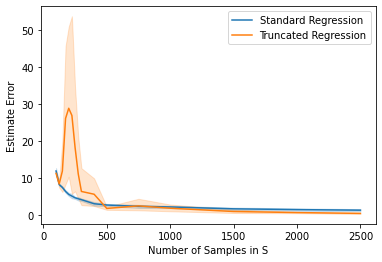

In [183]:
ax = sns.lineplot(data=logs, x='num_samples', y='ols_epsilon', label='Standard Regression')
ax = sns.lineplot(data=logs, x='num_samples', y='unknown_epsilon', label='Truncated Regression')
ax.set(xlabel='Number of Samples in S', ylabel='Estimate Error')

In [185]:
unknown_logs = unknown_logs[unknown_logs['num_samples'] > 300]

[Text(0.5, 0, 'Number of Samples in S'), Text(0, 0.5, 'Estimate Error')]

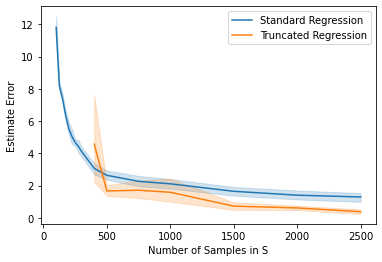

In [186]:
ax =sns.lineplot(data=ols_logs, x='num_samples', y='ols_epsilon', label='Standard Regression')
ax = sns.lineplot(data=unknown_logs, x='num_samples', y='unknown_epsilon', label='Truncated Regression')
ax.set(xlabel='Number of Samples in S', ylabel='Estimate Error')

In [128]:
(scaled_kinterval(stand_y_trunc) != 1).nonzero(as_tuple=False)

tensor([], size=(0, 2), dtype=torch.int64)

In [142]:
ols_var

tensor([[6.6700]])

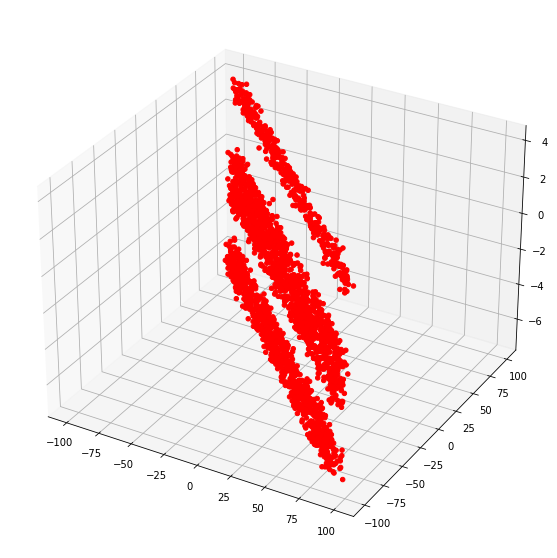

In [40]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
# data = ch.from_numpy(np.linspace(-3.0, 3.0, 100)).unsqueeze(1).float()

# ax.scatter3D(X[:,0], X[:,1], noised, color="blue", alpha=.01)
ax.scatter3D(x_trunc[:,0], x_trunc[:,1], y_trunc, color="red", alpha=1.0)

# ax.view_init(10, -150)

In [105]:
X = np.arange(-100, 100, 1)
Y = np.arange(-100, 100, 1)
X, Y = np.meshgrid(X, Y)

pred = Tensor([])
for i in range(X.shape[0]): 
    inp = Tensor(np.concatenate([np.expand_dims(X[i], 1), np.expand_dims(Y[i], 1)], 1))
    pred = ch.cat([pred, gt(inp)], dim=1)

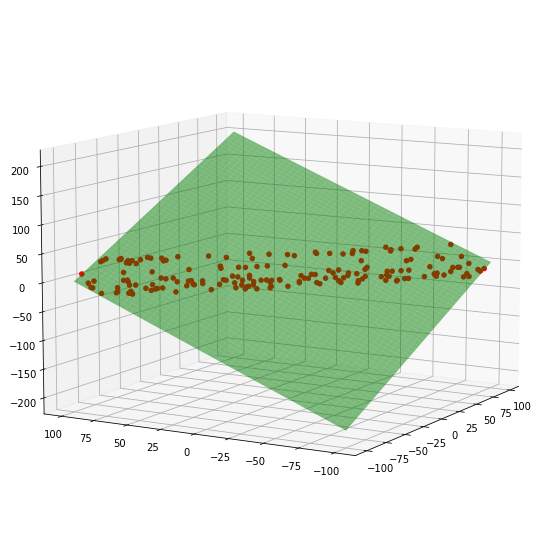

In [109]:
with ch.no_grad():
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection='3d')
    ax.scatter3D(x_trunc[:,0], x_trunc[:,1], y_trunc, color="red", alpha=1.0)
    ax.plot_surface(X, Y, pred.numpy(), color='green', alpha=.5)
    
ax.view_init(10, -150)

In [107]:
s

175

In [89]:
Y.shape

(16, 16)

In [ ]:
import matplotlib.patches as mpatches
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
data = ch.from_numpy(np.linspace(-3.0, 3.0, 100)).unsqueeze(1).float()

ax.scatter3D(x_trunc[:,0], x_trunc[:,1], y_trunc, color="grey", alpha=.5)
with ch.no_grad():
    X = np.arange(-2, 2, 0.25)
    Y = np.arange(-2, 2, 0.25)
    X, Y = np.meshgrid(X, Y)

    # plot predicted regression
    pred = Tensor([results(Tensor(np.concatenate([np.expand_dims(X[i], 1), np.expand_dims(Y[i], 1)], 1)).float()).numpy().flatten() for i in range(X.shape[0])]).numpy()
    ax.plot_surface(X, Y, pred, color="green", alpha=.15)
    
    # plot empirical regression - obtained via OLS
    emp = np.array([S.dataset.reg.predict(np.concatenate([np.expand_dims(X[i], 1), np.expand_dims(Y[i], 1)], 1)).flatten() for i in range(X.shape[0])])
    ax.plot_surface(X, Y, emp, color="red", alpha=.15)
    
    # plot actual regression - based off of synthetic data
    act = ch.cat([(Tensor(np.concatenate([np.expand_dims(X[i], 1), np.expand_dims(Y[i], 1)], 1)).float().mm(W) + W0) for i in range(X.shape[0])], 1).numpy()
    ax.plot_surface(X, Y, act, color="blue", alpha=.15)
    


red_patch = mpatches.Patch(color='red', label='OLS')

green_patch = mpatches.Patch(color='green', label='delphi')
blue_patch = mpatches.Patch(color='blue', label="actual")
plt.legend(handles=[red_patch, blue_patch, green_patch], loc="center right")

ax.view_init(10, -150)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

ax.set_xlabel('X_0')
ax.set_ylabel('X_1')
ax.set_zlabel('Y')

In [145]:
dist.sample(ch.Size([10000])).norm(dim=-1).max()

tensor(1.6702)

In [154]:
u = Uniform(-1/d, 1/d)

s = u.sample(ch.Size([10000, d]))

In [46]:
(x_trunc@w+w0 - y_trunc)

tensor([[-8.0481],
        [-4.1819],
        [-3.8256],
        ...,
        [ 0.5905],
        [-2.1130],
        [-1.7292]])

In [47]:
unknown_var

tensor([[9.3957]], grad_fn=<MulBackward0>)

In [44]:
x = y = np.arange(-9.5, 15.0, 0.15)
np.meshgrid(x, y)[0].shape

(164, 164)

In [44]:
ols_params

tensor([0.1744, 2.7350])

In [52]:
ch.abs((x_trunc@w + w0) - y_trunc).mean(0)

tensor([2.5809])

In [68]:
((X@w + w0) - noised).var(0)

tensor([9.8567])

In [58]:
(x_trunc@w + w0 - y_trunc).var(0)

tensor([4.2200])

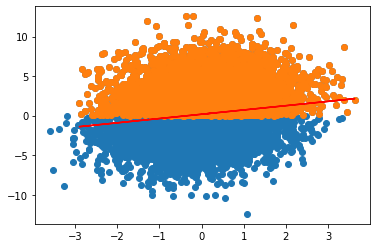

In [89]:
plt.scatter(X, noised)
plt.scatter(x_trunc, y_trunc)
plt.plot(x_trunc, x_trunc@w + w0, color='r')

In [61]:
data = Tensor(np.expand_dims(np.linspace(-3, 3), 1))

In [76]:
x_half, y_half = X[:5000], noised[:5000]

In [77]:
(x_half@w + w0 - y_half).var(0)

tensor([10.1086])

In [86]:
(x_trunc@w - y_trunc).var(0)

tensor([4.2200])

In [81]:
w0

tensor([[0.1702]])

In [24]:
rand = ch.randn(100, 16, 1)

In [25]:
rand > 0.0

tensor([[[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [ True]],

        [[ True],
         [False],
         [False],
         ...,
         [ True],
         [False],
         [False]],

        [[ True],
         [False],
         [ True],
         ...,
         [ True],
         [False],
         [False]],

        ...,

        [[False],
         [ True],
         [False],
         ...,
         [False],
         [ True],
         [ True]],

        [[False],
         [False],
         [False],
         ...,
         [ True],
         [False],
         [False]],

        [[ True],
         [False],
         [ True],
         ...,
         [ True],
         [ True],
         [False]]])

In [100]:
samples

[100,
 125,
 150,
 175,
 200,
 225,
 250,
 275,
 300,
 400,
 500,
 750,
 1000,
 1500,
 2000,
 2500]

In [103]:
y = []
for s in samples: 
    y.append(1/(s**(.25)))

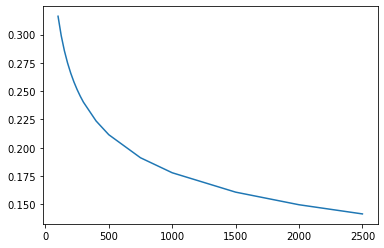

In [104]:
plt.plot(samples, y)